In [121]:
# ============================================================
# Celda 00: Configuración del proyecto, rutas, entorno y chequeos
# ============================================================
# Objetivo de esta celda:
# - Definir la ruta raíz del proyecto (C:\Quant\GESTOR DE IA) y subcarpetas estándar.
# - Crear carpetas si faltan (data/raw, data/processed, cache, logs, reports, notebooks, src, configs).
# - Cargar variables de entorno desde .env (por ejemplo: OPENAI_API_KEY).
# - Hacer chequeos básicos del entorno (Python, librerías clave, escritura en disco).
#
# Resultado esperado (verificado con prints):
# - Que las rutas existan y queden impresas.
# - Que se detecte el archivo .env (si existe) y se confirme si hay OPENAI_API_KEY.
# - Que podamos escribir/leer un archivo de prueba en data/cache.

from __future__ import annotations

import os
import sys
import platform
from pathlib import Path
from datetime import datetime

# Recomendación: mantener 1 sola fuente de verdad para la raíz del proyecto
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")

# Subcarpetas estándar del proyecto
DIRS = {
    "DATA_RAW": PROJECT_ROOT / "data" / "raw",
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "NOTEBOOKS": PROJECT_ROOT / "notebooks",
    "SRC": PROJECT_ROOT / "src",
    "CONFIGS": PROJECT_ROOT / "configs",
    "LOGS": PROJECT_ROOT / "logs",
    "REPORTS": PROJECT_ROOT / "reports",
}

# 1) Crear estructura si falta
for name, p in DIRS.items():
    p.mkdir(parents=True, exist_ok=True)

# 2) Cargar .env si existe (OPENAI_API_KEY, etc.)
ENV_PATH = PROJECT_ROOT / ".env"
dotenv_loaded = False
try:
    from dotenv import load_dotenv
    if ENV_PATH.exists():
        load_dotenv(ENV_PATH)
        dotenv_loaded = True
except Exception as e:
    print(f"[WARN] No se pudo importar/cargar python-dotenv: {e}")

# 3) Chequeos mínimos de entorno
print("========== CHEQUEO ENTORNO ==========")
print(f"Fecha/hora local: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python: {sys.version.split()[0]} | Ejecutable: {sys.executable}")
print(f"OS: {platform.system()} {platform.release()} ({platform.version()})")
print("=====================================\n")

print("========== RUTAS DEL PROYECTO ==========")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
for name, p in DIRS.items():
    print(f"{name:>13}: {p}  | exists={p.exists()}")
print("========================================\n")

print("========== VARIABLES DE ENTORNO (.env) ==========")
print(f".env encontrado: {ENV_PATH.exists()} | dotenv_loaded: {dotenv_loaded}")
# No imprimimos la key; solo confirmamos presencia
has_openai_key = bool(os.getenv("OPENAI_API_KEY"))
print(f"OPENAI_API_KEY presente: {has_openai_key}")
if ENV_PATH.exists() and not has_openai_key:
    print("[INFO] Agrega tu API key en C:\\Quant\\GESTOR DE IA\\.env con esta línea:")
    print("       OPENAI_API_KEY=tu_key_aqui")
print("=================================================\n")

# 4) Prueba rápida de escritura/lectura en cache (para asegurar permisos)
test_file = DIRS["DATA_CACHE"] / "_write_test.txt"
test_content = f"ok - {datetime.now().isoformat()}"
test_file.write_text(test_content, encoding="utf-8")
read_back = test_file.read_text(encoding="utf-8")

print("========== PRUEBA DISCO ==========")
print(f"Archivo test: {test_file}")
print(f"Contenido OK: {read_back == test_content}")
print("==================================")


========== CHEQUEO ENTORNO ==========
Fecha/hora local: 2025-12-14 20:33:01
Python: 3.13.7 | Ejecutable: c:\Quant\GESTOR DE IA\.venv\Scripts\python.exe
OS: Windows 11 (10.0.26200)

========== RUTAS DEL PROYECTO ==========
PROJECT_ROOT: C:\Quant\GESTOR DE IA
     DATA_RAW: C:\Quant\GESTOR DE IA\data\raw  | exists=True
DATA_PROCESSED: C:\Quant\GESTOR DE IA\data\processed  | exists=True
   DATA_CACHE: C:\Quant\GESTOR DE IA\data\cache  | exists=True
    NOTEBOOKS: C:\Quant\GESTOR DE IA\notebooks  | exists=True
          SRC: C:\Quant\GESTOR DE IA\src  | exists=True
      CONFIGS: C:\Quant\GESTOR DE IA\configs  | exists=True
         LOGS: C:\Quant\GESTOR DE IA\logs  | exists=True
      REPORTS: C:\Quant\GESTOR DE IA\reports  | exists=True

========== VARIABLES DE ENTORNO (.env) ==========
.env encontrado: True | dotenv_loaded: True
OPENAI_API_KEY presente: True

========== PRUEBA DISCO ==========
Archivo test: C:\Quant\GESTOR DE IA\data\cache\_write_test.txt
Contenido OK: True


In [122]:
# ============================================================
# Celda 01: Auditoría de datos (Yahoo Finance) — Precios + Estados Financieros
# ============================================================
# Objetivo de esta celda:
# - Cargar el universo de tickers (configs/universe.csv) o crear un universo de ejemplo si no existe.
# - Descargar (y cachear) precios históricos "max" por ticker usando yfinance.
# - Descargar (y auditar) estados financieros disponibles en Yahoo vía yfinance:
#   - Balance Sheet (anual / trimestral)
#   - Income Statement (anual / trimestral)
#   - Cash Flow (anual / trimestral)
# - Construir una tabla de auditoría para medir:
#   - Cobertura de precios (fecha inicio/fin, #filas, años de historia)
#   - Cantidad de periodos financieros disponibles (limitación típica en Yahoo)
#   - Errores por ticker (si los hay)
# - Guardar resultados en reports/ para decidir si Yahoo es suficiente para el experimento.
#
# Resultado esperado (verificado con prints):
# - audit_df con 1 fila por ticker.
# - Archivos guardados en:
#   - reports/yahoo_data_audit.csv
#   - reports/yahoo_data_audit.parquet
# - Resumen rápido: cuántos tickers tienen >= X años de precios y cuántos tienen >= N periodos financieros.

from __future__ import annotations

import os
import time
import json
import traceback
from pathlib import Path
from datetime import datetime

import pandas as pd

# Reutilizamos PROJECT_ROOT y DIRS si ya están en memoria desde la Celda 00.
# Si reiniciaste el kernel y no existen, define aquí de forma defensiva.
try:
    PROJECT_ROOT
    DIRS
except NameError:
    PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
    DIRS = {
        "DATA_RAW": PROJECT_ROOT / "data" / "raw",
        "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
        "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
        "NOTEBOOKS": PROJECT_ROOT / "notebooks",
        "SRC": PROJECT_ROOT / "src",
        "CONFIGS": PROJECT_ROOT / "configs",
        "LOGS": PROJECT_ROOT / "logs",
        "REPORTS": PROJECT_ROOT / "reports",
    }
    for _, p in DIRS.items():
        p.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 1) Dependencias (verificación)
# -----------------------------
def ensure_package(import_name: str, pip_name: str | None = None) -> None:
    """
    Verifica import; si falla, intenta instalarlo dentro del entorno del notebook.
    Nota: requiere que el kernel tenga permisos de pip (normalmente sí).
    """
    try:
        __import__(import_name)
    except Exception:
        pip_name = pip_name or import_name
        print(f"[INFO] Instalando dependencia faltante: {pip_name}")
        import sys
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        __import__(import_name)

ensure_package("yfinance", "yfinance")
ensure_package("pyarrow", "pyarrow")

import yfinance as yf

print("========== CONFIG AUDITORÍA ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print("======================================\n")

# -----------------------------
# 2) Cargar universo de tickers
# -----------------------------
UNIVERSE_PATH = DIRS["CONFIGS"] / "universe.csv"

if UNIVERSE_PATH.exists():
    universe_df = pd.read_csv(UNIVERSE_PATH)
    # Esperamos una columna 'ticker'. Si no existe, tomamos la primera columna.
    if "ticker" in universe_df.columns:
        tickers = universe_df["ticker"].dropna().astype(str).str.strip().tolist()
    else:
        tickers = universe_df.iloc[:, 0].dropna().astype(str).str.strip().tolist()
    tickers = [t for t in tickers if t]
    print(f"[OK] Universo cargado desde: {UNIVERSE_PATH} | tickers={len(tickers)}")
else:
    # Universo mínimo de ejemplo (modifica luego en configs/universe.csv)
    tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "JPM", "JNJ", "KO", "XOM"]
    pd.DataFrame({"ticker": tickers}).to_csv(UNIVERSE_PATH, index=False, encoding="utf-8")
    print(f"[WARN] No existía {UNIVERSE_PATH}. Se creó un universe.csv de ejemplo con {len(tickers)} tickers.")
    print("       Puedes editarlo y volver a ejecutar esta celda.\n")

# -----------------------------
# 3) Helpers: cache + descarga
# -----------------------------
PRICE_CACHE_DIR = DIRS["DATA_CACHE"] / "yahoo_prices"
PRICE_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def cache_path_prices(ticker: str) -> Path:
    safe = ticker.replace("/", "_").replace("\\", "_").replace(":", "_")
    return PRICE_CACHE_DIR / f"{safe}_prices.parquet"

def fetch_prices_max(ticker: str, use_cache: bool = True, sleep_s: float = 0.25) -> pd.DataFrame:
    """
    Descarga precios históricos 'max' desde Yahoo usando yfinance.
    Cachea a parquet para evitar re-descargas.
    """
    p = cache_path_prices(ticker)
    if use_cache and p.exists():
        df = pd.read_parquet(p)
        return df

    t = yf.Ticker(ticker)
    # auto_adjust=False para mantener OHLC sin ajustar; Adj Close viene aparte si está disponible
    df = t.history(period="max", auto_adjust=False, actions=False)

    # Normalización mínima
    if df is None or df.empty:
        df = pd.DataFrame()

    else:
        df = df.reset_index()
        # Asegurar nombres consistentes
        # yfinance puede traer "Date" o "Datetime" según activo; normalizamos a "date"
        date_col = "Date" if "Date" in df.columns else ("Datetime" if "Datetime" in df.columns else None)
        if date_col:
            df = df.rename(columns={date_col: "date"})
        # Asegurar que date sea datetime
        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Guardar cache
    if not df.empty:
        df.to_parquet(p, index=False)

    time.sleep(sleep_s)
    return df

def periods_count(df: pd.DataFrame) -> int:
    """En yfinance, estados financieros vienen con columnas = periodos. Cuenta columnas (periodos) si hay data."""
    if df is None or df.empty:
        return 0
    # df típicamente: index = line items, columns = fechas/periodos
    return int(df.shape[1])

def latest_period(df: pd.DataFrame):
    if df is None or df.empty:
        return None
    try:
        cols = list(df.columns)
        # A veces son timestamps; intentamos parsear
        parsed = pd.to_datetime(cols, errors="coerce")
        if parsed.notna().any():
            return parsed.max().date().isoformat()
        return str(cols[-1])
    except Exception:
        return None

# -----------------------------
# 4) Auditoría por ticker
# -----------------------------
ERROR_LOG = DIRS["LOGS"] / "yahoo_data_audit_errors.log"

rows = []
errors = []

for i, ticker in enumerate(tickers, start=1):
    print(f"[{i:>3}/{len(tickers)}] Audit: {ticker}")
    row = {
        "ticker": ticker,
        "price_rows": 0,
        "price_start": None,
        "price_end": None,
        "price_years": None,
        "bs_annual_periods": 0,
        "is_annual_periods": 0,
        "cf_annual_periods": 0,
        "bs_quarterly_periods": 0,
        "is_quarterly_periods": 0,
        "cf_quarterly_periods": 0,
        "bs_annual_latest": None,
        "is_annual_latest": None,
        "cf_annual_latest": None,
        "bs_quarterly_latest": None,
        "is_quarterly_latest": None,
        "cf_quarterly_latest": None,
        "status": "ok",
        "error": None,
    }

    try:
        t = yf.Ticker(ticker)

        # Precios
        prices = fetch_prices_max(ticker, use_cache=True)
        if not prices.empty and "date" in prices.columns:
            row["price_rows"] = int(len(prices))
            dmin = prices["date"].min()
            dmax = prices["date"].max()
            row["price_start"] = dmin.date().isoformat() if pd.notna(dmin) else None
            row["price_end"] = dmax.date().isoformat() if pd.notna(dmax) else None
            if pd.notna(dmin) and pd.notna(dmax):
                row["price_years"] = round((dmax - dmin).days / 365.25, 2)

        # Estados financieros (anual / trimestral)
        # Balance Sheet
        bs_a = t.balance_sheet
        bs_q = t.quarterly_balance_sheet
        # Income Statement
        is_a = t.financials
        is_q = t.quarterly_financials
        # Cash Flow
        cf_a = t.cashflow
        cf_q = t.quarterly_cashflow

        row["bs_annual_periods"] = periods_count(bs_a)
        row["bs_quarterly_periods"] = periods_count(bs_q)
        row["is_annual_periods"] = periods_count(is_a)
        row["is_quarterly_periods"] = periods_count(is_q)
        row["cf_annual_periods"] = periods_count(cf_a)
        row["cf_quarterly_periods"] = periods_count(cf_q)

        row["bs_annual_latest"] = latest_period(bs_a)
        row["bs_quarterly_latest"] = latest_period(bs_q)
        row["is_annual_latest"] = latest_period(is_a)
        row["is_quarterly_latest"] = latest_period(is_q)
        row["cf_annual_latest"] = latest_period(cf_a)
        row["cf_quarterly_latest"] = latest_period(cf_q)

    except Exception as e:
        row["status"] = "error"
        row["error"] = f"{type(e).__name__}: {e}"
        errors.append(
            {
                "ticker": ticker,
                "error": row["error"],
                "traceback": traceback.format_exc(),
            }
        )

    rows.append(row)

# -----------------------------
# 5) Construir tabla audit + guardar
# -----------------------------
audit_df = pd.DataFrame(rows)

out_csv = DIRS["REPORTS"] / "yahoo_data_audit.csv"
out_pq  = DIRS["REPORTS"] / "yahoo_data_audit.parquet"

audit_df.to_csv(out_csv, index=False, encoding="utf-8")
audit_df.to_parquet(out_pq, index=False)

# Guardar errores (si existen)
if errors:
    with open(ERROR_LOG, "a", encoding="utf-8") as f:
        f.write("\n" + "="*80 + "\n")
        f.write(f"[{datetime.now().isoformat()}] Errores en auditoría Yahoo\n")
        for err in errors:
            f.write(json.dumps(err, ensure_ascii=False) + "\n")

# -----------------------------
# 6) Resumen ejecutivo (prints)
# -----------------------------
print("\n========== RESULTADOS AUDITORÍA ==========")
print(f"Tickers auditados: {len(audit_df)}")
print(f"Errores: {int((audit_df['status'] == 'error').sum())}")
print(f"Guardado CSV: {out_csv}")
print(f"Guardado Parquet: {out_pq}")

# Umbrales iniciales (puedes cambiarlos)
MIN_PRICE_YEARS = 10        # para backtests largos
MIN_ANNUAL_PERIODS = 8      # ideal para value/ratios multi-año (Yahoo usualmente NO llega aquí)

ok_price = (audit_df["price_years"].fillna(0) >= MIN_PRICE_YEARS).sum()
ok_bs_a  = (audit_df["bs_annual_periods"].fillna(0) >= MIN_ANNUAL_PERIODS).sum()
ok_is_a  = (audit_df["is_annual_periods"].fillna(0) >= MIN_ANNUAL_PERIODS).sum()
ok_cf_a  = (audit_df["cf_annual_periods"].fillna(0) >= MIN_ANNUAL_PERIODS).sum()

print("\n--- Cobertura (umbral preliminar) ---")
print(f"Precios >= {MIN_PRICE_YEARS} años: {ok_price}/{len(audit_df)}")
print(f"Balance anual >= {MIN_ANNUAL_PERIODS} periodos: {ok_bs_a}/{len(audit_df)}")
print(f"Income anual  >= {MIN_ANNUAL_PERIODS} periodos: {ok_is_a}/{len(audit_df)}")
print(f"Cashflow anual >= {MIN_ANNUAL_PERIODS} periodos: {ok_cf_a}/{len(audit_df)}")

print("\n--- Estadísticas rápidas ---")
print("Años de precios (describe):")
print(audit_df["price_years"].describe(include="all"))

print("\nPeriodos financieros anuales (medianas):")
print({
    "bs_annual_median": float(audit_df["bs_annual_periods"].median()),
    "is_annual_median": float(audit_df["is_annual_periods"].median()),
    "cf_annual_median": float(audit_df["cf_annual_periods"].median()),
})

print("========================================\n")

# Mostrar las primeras filas para inspección manual rápida
display(audit_df.head(10))

# ------------------------------------------------------------
# Resumen de la celda (lo más importante):
# - Se creó/leyó el universo de tickers.
# - Se descargaron y cachearon precios "max" por ticker.
# - Se midió cuántos periodos de estados financieros entrega Yahoo (anual y trimestral).
# - Se guardó una tabla "yahoo_data_audit" para decidir si Yahoo alcanza o hay que añadir otra fuente.
# ------------------------------------------------------------


========== CONFIG AUDITORÍA ==========
Fecha/hora: 2025-12-14 20:33:01
PROJECT_ROOT: C:\Quant\GESTOR DE IA

[OK] Universo cargado desde: C:\Quant\GESTOR DE IA\configs\universe.csv | tickers=10
[  1/10] Audit: AAPL
[  2/10] Audit: MSFT
[  3/10] Audit: GOOGL
[  4/10] Audit: AMZN
[  5/10] Audit: NVDA
[  6/10] Audit: TSLA
[  7/10] Audit: JPM
[  8/10] Audit: JNJ
[  9/10] Audit: KO
[ 10/10] Audit: XOM

========== RESULTADOS AUDITORÍA ==========
Tickers auditados: 10
Errores: 0
Guardado CSV: C:\Quant\GESTOR DE IA\reports\yahoo_data_audit.csv
Guardado Parquet: C:\Quant\GESTOR DE IA\reports\yahoo_data_audit.parquet

--- Cobertura (umbral preliminar) ---
Precios >= 10 años: 10/10
Balance anual >= 8 periodos: 0/10
Income anual  >= 8 periodos: 0/10
Cashflow anual >= 8 periodos: 0/10

--- Estadísticas rápidas ---
Años de precios (describe):
count    10.000000
mean     41.455000
std      18.287904
min      15.460000
25%      27.312500
50%      42.375000
75%      59.390000
max      63.940000
Name: pr

,ticker,price_rows,price_start,price_end,price_years,bs_annual_periods,is_annual_periods,cf_annual_periods,bs_quarterly_periods,is_quarterly_periods,cf_quarterly_periods,bs_annual_latest,is_annual_latest,cf_annual_latest,bs_quarterly_latest,is_quarterly_latest,cf_quarterly_latest,status,error
0,AAPL,11343,1980-12-12,2025-12-12,45.00,5,5,5,5,5,7,2025-09-30,2025-09-30,2025-09-30,2025-09-30,2025-09-30,2025-09-30,ok,None
1,MSFT,10017,1986-03-13,2025-12-12,39.75,5,4,5,7,5,7,2025-06-30,2025-06-30,2025-06-30,2025-09-30,2025-09-30,2025-09-30,ok,None
2,GOOGL,5365,2004-08-19,2025-12-12,21.31,5,4,5,7,7,5,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
3,AMZN,7191,1997-05-15,2025-12-12,28.58,5,5,4,7,5,7,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
4,NVDA,6766,1999-01-22,2025-12-12,26.89,5,4,5,7,5,5,2025-01-31,2025-01-31,2025-01-31,2025-10-31,2025-10-31,2025-10-31,ok,None
5,TSLA,3890,2010-06-29,2025-12-12,15.46,5,5,5,7,7,6,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
6,JPM,11531,1980-03-17,2025-12-12,45.74,5,5,4,6,7,5,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
7,JNJ,16096,1962-01-02,2025-12-12,63.94,5,4,5,6,7,5,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
8,KO,16096,1962-01-02,2025-12-12,63.94,5,5,5,7,7,6,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None
9,XOM,16096,1962-01-02,2025-12-12,63.94,4,5,5,5,7,5,2024-12-31,2024-12-31,2024-12-31,2025-09-30,2025-09-30,2025-09-30,ok,None


In [123]:
# ============================================================
# Celda 02A: Configurar SIMFIN_API_KEY (ya proporcionada) + persistir en .env
# ============================================================
# Objetivo de esta celda:
# - Tomar tu SIMFIN_API_KEY (ya la indicaste) y guardarla/actualizarla en:
#   C:\Quant\GESTOR DE IA\.env
# - Cargarla en el entorno actual (os.environ) para que SimFin autentique.
# - Validar presencia (sin imprimir la key) y dejar listo el reintento de descarga.
#
# Resultado esperado:
# - SIMFIN_API_KEY presente: True
# - Listo para re-ejecutar la Celda 02 (SimFin audit) y que ya no salga 401.

from __future__ import annotations

import os
from pathlib import Path

# 1) Ruta del proyecto y .env
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
ENV_PATH = PROJECT_ROOT / ".env"

# 2) TU API KEY (tal como la proporcionaste)
SIMFIN_API_KEY_VALUE = "e9ffc056-013b-4799-b84a-3cb51388874f"

def upsert_env_var(env_path: Path, key: str, value: str) -> None:
    """
    Inserta o actualiza KEY=VALUE dentro de un archivo .env.
    - Si la variable existe, la reemplaza.
    - Si no existe, la agrega al final.
    """
    env_path.parent.mkdir(parents=True, exist_ok=True)
    lines = []
    if env_path.exists():
        lines = env_path.read_text(encoding="utf-8").splitlines()

    found = False
    new_lines = []
    for line in lines:
        if line.strip().startswith(f"{key}="):
            new_lines.append(f"{key}={value}")
            found = True
        else:
            new_lines.append(line)

    if not found:
        new_lines.append(f"{key}={value}")

    env_path.write_text("\n".join(new_lines) + "\n", encoding="utf-8")

# 3) Persistir en .env y cargar en entorno actual
upsert_env_var(ENV_PATH, "SIMFIN_API_KEY", SIMFIN_API_KEY_VALUE)
os.environ["SIMFIN_API_KEY"] = SIMFIN_API_KEY_VALUE

# 4) Validación (sin mostrar la key)
print("========== ESTADO KEYS ==========")
print(f".env: {ENV_PATH} | exists={ENV_PATH.exists()}")
print(f"OPENAI_API_KEY presente: {bool(os.getenv('OPENAI_API_KEY'))}")
print(f"SIMFIN_API_KEY presente: {bool(os.getenv('SIMFIN_API_KEY'))}")
print("================================\n")

print("[OK] Listo. Ahora re-ejecuta la Celda 02 (SimFin audit).")

# ------------------------------------------------------------
# Resumen de la celda (lo más importante):
# - Se insertó/actualizó SIMFIN_API_KEY en el archivo .env del proyecto.
# - Se cargó SIMFIN_API_KEY en el entorno actual del kernel.
# - Queda listo el acceso autenticado para que SimFin descargue datasets (evitando 401).
# ------------------------------------------------------------


========== ESTADO KEYS ==========
.env: C:\Quant\GESTOR DE IA\.env | exists=True
OPENAI_API_KEY presente: True
SIMFIN_API_KEY presente: True

[OK] Listo. Ahora re-ejecuta la Celda 02 (SimFin audit).


In [124]:
# ============================================================
# Celda 02: Auditoría de Fundamentales Históricos (SimFin) — Anual + Trimestral
# ============================================================
# Objetivo de esta celda:
# - Descargar (o cargar desde cache) estados financieros históricos usando SimFin.
# - Filtrar al universo de tickers (configs/universe.csv).
# - Medir cobertura real (años/periodos disponibles) por ticker para:
#   - Balance Sheet (annual / quarterly)
#   - Income Statement (annual / quarterly)
#   - Cash Flow (annual / quarterly)
# - Guardar:
#   - reports/simfin_data_audit.csv y .parquet
#   - data/raw/simfin_universe/*  (datos filtrados al universo, listos para features)
#
# Resultado esperado (verificado con prints):
# - simfin_audit_df con 1 fila por ticker + cobertura por dataset/variant.
# - Resumen: cuántos tickers cumplen umbrales largos (ej. >= 15 años anuales).
#
# Notas:
# - Si no tienes SIMFIN_API_KEY, la celda intenta igualmente. Si falla, te deja el mensaje exacto.
# - Puedes agregar SIMFIN_API_KEY en C:\Quant\GESTOR DE IA\.env (igual que OPENAI_API_KEY).

from __future__ import annotations

import os
import sys
import json
import traceback
from pathlib import Path
from datetime import datetime

import pandas as pd
from IPython.display import display

# Reutilizamos PROJECT_ROOT y DIRS si vienen de la Celda 00.
try:
    PROJECT_ROOT
    DIRS
except NameError:
    PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
    DIRS = {
        "DATA_RAW": PROJECT_ROOT / "data" / "raw",
        "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
        "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
        "NOTEBOOKS": PROJECT_ROOT / "notebooks",
        "SRC": PROJECT_ROOT / "src",
        "CONFIGS": PROJECT_ROOT / "configs",
        "LOGS": PROJECT_ROOT / "logs",
        "REPORTS": PROJECT_ROOT / "reports",
    }
    for _, p in DIRS.items():
        p.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 1) Helper: asegurar paquetes
# -----------------------------
def ensure_package(import_name: str, pip_name: str | None = None) -> None:
    try:
        __import__(import_name)
    except Exception:
        pip_name = pip_name or import_name
        print(f"[INFO] Instalando dependencia faltante: {pip_name}")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        __import__(import_name)

ensure_package("simfin", "simfin")
ensure_package("pyarrow", "pyarrow")

import simfin as sf

print("========== CONFIG SIMFIN AUDIT ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print("=========================================\n")

# -----------------------------
# 2) Cargar universo
# -----------------------------
UNIVERSE_PATH = DIRS["CONFIGS"] / "universe.csv"
if not UNIVERSE_PATH.exists():
    raise FileNotFoundError(
        f"No existe {UNIVERSE_PATH}. Ejecuta la celda anterior o crea configs/universe.csv con una columna 'ticker'."
    )

universe_df = pd.read_csv(UNIVERSE_PATH)
if "ticker" in universe_df.columns:
    tickers = universe_df["ticker"].dropna().astype(str).str.strip().tolist()
else:
    tickers = universe_df.iloc[:, 0].dropna().astype(str).str.strip().tolist()
tickers = [t for t in tickers if t]

print(f"[OK] Universo: {len(tickers)} tickers (desde {UNIVERSE_PATH})\n")

# -----------------------------
# 3) Config SimFin (cache local)
# -----------------------------
SIMFIN_DATA_DIR = DIRS["DATA_CACHE"] / "simfin"
SIMFIN_DATA_DIR.mkdir(parents=True, exist_ok=True)
sf.set_data_dir(str(SIMFIN_DATA_DIR))

simfin_key = os.getenv("SIMFIN_API_KEY")
if simfin_key:
    try:
        sf.set_api_key(simfin_key)
        print("[OK] SIMFIN_API_KEY detectada y configurada.\n")
    except Exception as e:
        print(f"[WARN] No se pudo configurar SIMFIN_API_KEY: {e}\n")
else:
    print("[INFO] No se detectó SIMFIN_API_KEY. Se intentará cargar igualmente.\n"
          "       Si falla, agrega en .env:  SIMFIN_API_KEY=tu_key\n")

# -----------------------------
# 4) Helpers robustos de carga
# -----------------------------
def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def simfin_load(dataset: str, variant: str, market: str = "us") -> pd.DataFrame:
    """
    Intenta cargar datasets de SimFin con varias firmas (por compatibilidad).
    dataset: 'income' | 'balance' | 'cashflow'
    variant: 'annual' | 'quarterly'
    """
    # Intento 1: sf.load(...)
    try:
        return sf.load(dataset, variant=variant, market=market)
    except TypeError:
        try:
            return sf.load(dataset=dataset, variant=variant, market=market)
        except Exception:
            pass
    except Exception:
        pass

    # Intento 2: funciones específicas (si existen)
    fn_map = {"income": "load_income", "balance": "load_balance", "cashflow": "load_cashflow"}
    fn_name = fn_map.get(dataset)
    if fn_name and hasattr(sf, fn_name):
        fn = getattr(sf, fn_name)
        return fn(variant=variant, market=market)

    raise RuntimeError(f"No se pudo cargar dataset SimFin: dataset={dataset}, variant={variant}, market={market}")

def audit_periods(df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    """
    Devuelve tabla por ticker con:
    - periods: #periodos (años para annual; FY+FP para quarterly)
    - fy_min / fy_max
    - years_span (fy_max - fy_min + 1)
    - publish_min / publish_max (si existe Publish Date)
    """
    if df is None or df.empty:
        return pd.DataFrame({"ticker": tickers}).assign(periods=0, fy_min=None, fy_max=None, years_span=None,
                                                       publish_min=None, publish_max=None)

    # Detectar columnas clave
    c_ticker = pick_col(df, ["Ticker", "ticker"])
    c_fy     = pick_col(df, ["Fiscal Year", "FiscalYear", "fy", "fiscal_year"])
    c_fp     = pick_col(df, ["Fiscal Period", "FiscalPeriod", "fp", "fiscal_period"])
    c_pub    = pick_col(df, ["Publish Date", "PublishDate", "publish_date", "Report Date", "ReportDate"])

    if c_ticker is None or c_fy is None:
        raise RuntimeError(f"SimFin dataframe no trae columnas esperadas (Ticker/Fiscal Year). Columns={list(df.columns)[:30]}")

    df_u = df[df[c_ticker].isin(tickers)].copy()
    df_u.rename(columns={c_ticker: "ticker", c_fy: "fy"}, inplace=True)

    if c_pub:
        df_u.rename(columns={c_pub: "publish_date"}, inplace=True)
        df_u["publish_date"] = pd.to_datetime(df_u["publish_date"], errors="coerce")
    else:
        df_u["publish_date"] = pd.NaT

    # Annual: periodos = #Fiscal Year
    # Quarterly: periodos = # (Fiscal Year, Fiscal Period)
    if c_fp:
        df_u.rename(columns={c_fp: "fp"}, inplace=True)
        # quarterly
        tmp = df_u.dropna(subset=["fy", "fp"]).drop_duplicates(subset=["ticker", "fy", "fp"])
        grp = tmp.groupby("ticker")
        out = grp.agg(
            periods=("fy", "size"),
            fy_min=("fy", "min"),
            fy_max=("fy", "max"),
            publish_min=("publish_date", "min"),
            publish_max=("publish_date", "max"),
        ).reset_index()
    else:
        # annual
        tmp = df_u.dropna(subset=["fy"]).drop_duplicates(subset=["ticker", "fy"])
        grp = tmp.groupby("ticker")
        out = grp.agg(
            periods=("fy", "size"),
            fy_min=("fy", "min"),
            fy_max=("fy", "max"),
            publish_min=("publish_date", "min"),
            publish_max=("publish_date", "max"),
        ).reset_index()

    out["years_span"] = out.apply(
        lambda r: (int(r["fy_max"]) - int(r["fy_min"]) + 1) if pd.notna(r["fy_min"]) and pd.notna(r["fy_max"]) else None,
        axis=1
    )

    # Completar tickers faltantes
    base = pd.DataFrame({"ticker": tickers})
    out = base.merge(out, on="ticker", how="left")
    out["periods"] = out["periods"].fillna(0).astype(int)

    # Fechas a string para reporte limpio
    for c in ["publish_min", "publish_max"]:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce").dt.date.astype("string")

    return out

# -----------------------------
# 5) Descargar/cargar datasets
# -----------------------------
# Guardaremos los datos filtrados al universo en data/raw/simfin_universe/
SIMFIN_UNI_DIR = DIRS["DATA_RAW"] / "simfin_universe"
SIMFIN_UNI_DIR.mkdir(parents=True, exist_ok=True)

datasets = [
    ("balance", "annual"),
    ("balance", "quarterly"),
    ("income", "annual"),
    ("income", "quarterly"),
    ("cashflow", "annual"),
    ("cashflow", "quarterly"),
]

loaded = {}
errors = []
for ds, variant in datasets:
    try:
        print(f"[LOAD] SimFin {ds} | {variant}")
        df = simfin_load(ds, variant, market="us")
        loaded[(ds, variant)] = df

        # Guardar versión filtrada al universo (reduce tamaño y acelera celdas futuras)
        # Nota: esto guarda "raw filtrado", no features.
        c_ticker = pick_col(df, ["Ticker", "ticker"])
        if c_ticker and not df.empty:
            df_u = df[df[c_ticker].isin(tickers)].copy()
        else:
            df_u = pd.DataFrame()

        out_pq = SIMFIN_UNI_DIR / f"simfin_{ds}_{variant}_universe.parquet"
        df_u.to_parquet(out_pq, index=False)
        print(f"       -> guardado: {out_pq} | filas: {len(df_u)}")

    except Exception as e:
        err = {
            "dataset": ds,
            "variant": variant,
            "error": f"{type(e).__name__}: {e}",
            "traceback": traceback.format_exc(),
        }
        errors.append(err)
        print(f"[ERROR] {ds} {variant}: {err['error']}")

# Log de errores (si existen)
SIMFIN_ERR_LOG = DIRS["LOGS"] / "simfin_data_audit_errors.log"
if errors:
    with open(SIMFIN_ERR_LOG, "a", encoding="utf-8") as f:
        f.write("\n" + "="*80 + "\n")
        f.write(f"[{datetime.now().isoformat()}] Errores en auditoría SimFin\n")
        for err in errors:
            f.write(json.dumps(err, ensure_ascii=False) + "\n")
    print(f"\n[WARN] Hubo errores. Revisa: {SIMFIN_ERR_LOG}\n")

# -----------------------------
# 6) Construir auditoría por ticker
# -----------------------------
# Si algún dataset no cargó, audit_periods devuelve zeros al detectar df vacío.
audit_parts = {}

# Balance annual / quarterly
audit_parts["bs_a"] = audit_periods(loaded.get(("balance", "annual"), pd.DataFrame()), tickers)
audit_parts["bs_q"] = audit_periods(loaded.get(("balance", "quarterly"), pd.DataFrame()), tickers)

# Income annual / quarterly
audit_parts["is_a"] = audit_periods(loaded.get(("income", "annual"), pd.DataFrame()), tickers)
audit_parts["is_q"] = audit_periods(loaded.get(("income", "quarterly"), pd.DataFrame()), tickers)

# Cashflow annual / quarterly
audit_parts["cf_a"] = audit_periods(loaded.get(("cashflow", "annual"), pd.DataFrame()), tickers)
audit_parts["cf_q"] = audit_periods(loaded.get(("cashflow", "quarterly"), pd.DataFrame()), tickers)

# Merge final
simfin_audit_df = pd.DataFrame({"ticker": tickers})

def merge_audit(base: pd.DataFrame, part: pd.DataFrame, prefix: str) -> pd.DataFrame:
    part = part.copy()
    ren = {
        "periods": f"{prefix}_periods",
        "fy_min": f"{prefix}_fy_min",
        "fy_max": f"{prefix}_fy_max",
        "years_span": f"{prefix}_years_span",
        "publish_min": f"{prefix}_publish_min",
        "publish_max": f"{prefix}_publish_max",
    }
    part.rename(columns=ren, inplace=True)
    return base.merge(part, on="ticker", how="left")

simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["bs_a"], "bs_annual")
simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["bs_q"], "bs_quarterly")
simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["is_a"], "is_annual")
simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["is_q"], "is_quarterly")
simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["cf_a"], "cf_annual")
simfin_audit_df = merge_audit(simfin_audit_df, audit_parts["cf_q"], "cf_quarterly")

# Guardar reporte
out_csv = DIRS["REPORTS"] / "simfin_data_audit.csv"
out_pq  = DIRS["REPORTS"] / "simfin_data_audit.parquet"
simfin_audit_df.to_csv(out_csv, index=False, encoding="utf-8")
simfin_audit_df.to_parquet(out_pq, index=False)

# -----------------------------
# 7) Resumen ejecutivo (prints)
# -----------------------------
MIN_ANNUAL_YEARS = 15  # umbral de "histórico largo" para value (ajústalo)
ok_bs = (simfin_audit_df["bs_annual_periods"].fillna(0) >= MIN_ANNUAL_YEARS).sum()
ok_is = (simfin_audit_df["is_annual_periods"].fillna(0) >= MIN_ANNUAL_YEARS).sum()
ok_cf = (simfin_audit_df["cf_annual_periods"].fillna(0) >= MIN_ANNUAL_YEARS).sum()

print("\n========== RESULTADOS AUDITORÍA SIMFIN ==========")
print(f"Tickers auditados: {len(simfin_audit_df)}")
print(f"Guardado CSV: {out_csv}")
print(f"Guardado Parquet: {out_pq}")
print("\n--- Cobertura (umbral preliminar) ---")
print(f"Balance anual >= {MIN_ANNUAL_YEARS} años/periodos: {ok_bs}/{len(simfin_audit_df)}")
print(f"Income anual  >= {MIN_ANNUAL_YEARS} años/periodos: {ok_is}/{len(simfin_audit_df)}")
print(f"Cashflow anual >= {MIN_ANNUAL_YEARS} años/periodos: {ok_cf}/{len(simfin_audit_df)}")

print("\n--- Medianas de periodos anuales ---")
print({
    "bs_annual_median": float(simfin_audit_df["bs_annual_periods"].median()),
    "is_annual_median": float(simfin_audit_df["is_annual_periods"].median()),
    "cf_annual_median": float(simfin_audit_df["cf_annual_periods"].median()),
})

print("\n--- Primeras filas (inspección) ---")
display(simfin_audit_df.head(10))

# ------------------------------------------------------------
# Resumen de la celda (lo más importante):
# - Se configuró SimFin con cache local y (si existe) SIMFIN_API_KEY.
# - Se intentó cargar Balance/Income/Cashflow en anual y trimestral.
# - Se guardaron los datos filtrados al universo para acelerar el pipeline.
# - Se generó simfin_data_audit para decidir si ya tenemos histórico largo suficiente.
# ------------------------------------------------------------


========== CONFIG SIMFIN AUDIT ==========
Fecha/hora: 2025-12-14 20:33:02
PROJECT_ROOT: C:\Quant\GESTOR DE IA

[OK] Universo: 10 tickers (desde C:\Quant\GESTOR DE IA\configs\universe.csv)

[OK] SIMFIN_API_KEY detectada y configurada.

[LOAD] SimFin balance | annual
Dataset "us-balance-annual" on disk (0 days old).
- Loading from disk ... Done!
       -> guardado: C:\Quant\GESTOR DE IA\data\raw\simfin_universe\simfin_balance_annual_universe.parquet | filas: 35
[LOAD] SimFin balance | quarterly
Dataset "us-balance-quarterly" on disk (0 days old).
- Loading from disk ... Done!
       -> guardado: C:\Quant\GESTOR DE IA\data\raw\simfin_universe\simfin_balance_quarterly_universe.parquet | filas: 153
[LOAD] SimFin income | annual
Dataset "us-income-annual" on disk (0 days old).
- Loading from disk ... Done!
       -> guardado: C:\Quant\GESTOR DE IA\data\raw\simfin_universe\simfin_income_annual_universe.parquet | filas: 35
[LOAD] SimFin income | quarterly
Dataset "us-income-quarterly" on disk 

,ticker,bs_annual_periods,bs_annual_fy_min,bs_annual_fy_max,bs_annual_publish_min,bs_annual_publish_max,bs_annual_years_span,bs_quarterly_periods,bs_quarterly_fy_min,bs_quarterly_fy_max,...,cf_annual_fy_max,cf_annual_publish_min,cf_annual_publish_max,cf_annual_years_span,cf_quarterly_periods,cf_quarterly_fy_min,cf_quarterly_fy_max,cf_quarterly_publish_min,cf_quarterly_publish_max,cf_quarterly_years_span
0,AAPL,5,2020.0,2024.0,2020-10-30,2024-11-01,5.0,19,2020.0,2024.0,...,2024.0,2020-10-30,2024-11-01,5.0,19,2020.0,2024.0,2020-05-01,2024-11-01,5.0
1,MSFT,5,2020.0,2024.0,2020-07-30,2024-07-30,5.0,19,2020.0,2025.0,...,2024.0,2020-07-30,2024-07-30,5.0,19,2020.0,2025.0,2020-04-29,2024-10-30,6.0
2,GOOGL,0,NaN,NaN,<NA>,<NA>,NaN,0,NaN,NaN,...,NaN,<NA>,<NA>,NaN,0,NaN,NaN,<NA>,<NA>,NaN
3,AMZN,4,2020.0,2023.0,2021-02-03,2024-02-02,4.0,19,2020.0,2024.0,...,2023.0,2021-02-03,2024-01-27,4.0,19,2020.0,2024.0,2020-05-01,2024-11-01,5.0
4,NVDA,5,2019.0,2023.0,2020-02-20,2024-02-21,5.0,20,2019.0,2024.0,...,2023.0,2020-02-20,2024-02-21,5.0,20,2019.0,2024.0,2020-02-20,2024-11-20,6.0
5,TSLA,4,2020.0,2023.0,2021-02-08,2024-01-29,4.0,19,2020.0,2024.0,...,2023.0,2021-02-08,2024-01-29,4.0,19,2020.0,2024.0,2020-04-30,2024-10-24,5.0
6,JPM,0,NaN,NaN,<NA>,<NA>,NaN,0,NaN,NaN,...,NaN,<NA>,<NA>,NaN,0,NaN,NaN,<NA>,<NA>,NaN
7,JNJ,4,2020.0,2023.0,2021-02-22,2024-02-16,4.0,19,2020.0,2024.0,...,2023.0,2021-02-22,2024-02-16,4.0,20,2019.0,2024.0,2020-02-18,2024-10-23,6.0
8,KO,4,2020.0,2023.0,2021-02-25,2024-02-20,4.0,19,2020.0,2024.0,...,2023.0,2021-02-25,2024-02-20,4.0,19,2020.0,2024.0,2020-04-24,2024-10-24,5.0
9,XOM,4,2020.0,2023.0,2021-02-24,2024-02-28,4.0,19,2020.0,2024.0,...,2023.0,2021-02-24,2024-02-28,4.0,19,2020.0,2024.0,2020-05-06,2024-11-04,5.0


In [125]:
# ============================================================
# Celda 03 (FIX v2): Dataset "Gold" (mensual) — Precios Yahoo + Fundamentales SimFin (as-of)
# ============================================================
# Objetivo de esta celda:
# - Cargar precios cacheados y convertirlos a frecuencia mensual (month-end).
# - Cargar fundamentales trimestrales (SimFin) y unificarlos por (ticker, fy, fp).
# - Mapear line-items a nombres estándar (NA-safe si faltan).
# - Calcular features value/quality sin romper.
# - Hacer as-of join mensual (evitando look-ahead).
# - Guardar artefactos en data/processed/.
#
# FIX v2 (cambio clave):
# - Normaliza llaves temporales para merge_asof:
#   * Remueve timezone (p.ej. America/New_York) en precios
#   * Asegura datetime64[ns] naive en ambos lados
#   * Normaliza a medianoche para coherencia
# ============================================================

from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

# ------------------------------------------------------------
# 0) Rutas / universo
# ------------------------------------------------------------
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_RAW": PROJECT_ROOT / "data" / "raw",
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "CONFIGS": PROJECT_ROOT / "configs",
    "REPORTS": PROJECT_ROOT / "reports",
    "LOGS": PROJECT_ROOT / "logs",
}
for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

universe_path = DIRS["CONFIGS"] / "universe.csv"
universe_df = pd.read_csv(universe_path)
tickers = universe_df["ticker"].dropna().astype(str).str.upper().str.strip().tolist()

print("========== CONFIG CELDA 03 (FIX v2) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tickers: {len(tickers)} | Ejemplo: {tickers[:5]}")
print("==============================================\n")

# ------------------------------------------------------------
# 1) PRECIOS: cargar cache y convertir a mensual (month-end)
# ------------------------------------------------------------
PRICE_CACHE_DIR = DIRS["DATA_CACHE"] / "yahoo_prices"
PRICE_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def _strip_tz_datetime_series(s: pd.Series) -> pd.Series:
    """
    Quita timezone si existe (tz-aware -> tz-naive) SIN convertir horas.
    """
    s = pd.to_datetime(s, errors="coerce")
    tz = getattr(s.dt, "tz", None)
    if tz is not None:
        s = s.dt.tz_localize(None)
    return s

def price_cache_path(ticker: str) -> Path:
    safe = ticker.replace("/", "_").replace("\\", "_").replace(":", "_")
    return PRICE_CACHE_DIR / f"{safe}_prices.parquet"

def load_prices_cached(ticker: str) -> pd.DataFrame:
    p = price_cache_path(ticker)
    if not p.exists():
        raise FileNotFoundError(
            f"No existe cache de precios para {ticker}. Ejecuta la Celda 01 (Yahoo audit) para generar caches."
        )
    df = pd.read_parquet(p)
    if "date" not in df.columns:
        raise ValueError(f"Cache de precios {p} no trae columna 'date'.")
    df["date"] = _strip_tz_datetime_series(df["date"])
    return df

prices_monthly_list = []
missing_prices = []

for tkr in tickers:
    try:
        df = load_prices_cached(tkr)
        if df.empty:
            missing_prices.append(tkr)
            continue

        price_col = "Adj Close" if "Adj Close" in df.columns else ("Close" if "Close" in df.columns else None)
        if price_col is None:
            missing_prices.append(tkr)
            continue

        tmp = df[["date", price_col]].dropna().copy()
        tmp = tmp.rename(columns={price_col: "price"})
        tmp = tmp.set_index("date").sort_index()

        # Month-end (último dato del mes)
        m = tmp.resample("ME").last().dropna().reset_index()
        m["ticker"] = tkr
        m["ret_m"] = m["price"].pct_change()

        # FIX: asegurar month_end tz-naive y normalizado
        m["date"] = _strip_tz_datetime_series(m["date"]).dt.normalize()

        prices_monthly_list.append(m)

    except Exception:
        missing_prices.append(tkr)

prices_monthly = pd.concat(prices_monthly_list, ignore_index=True) if prices_monthly_list else pd.DataFrame()

prices_out = DIRS["DATA_PROCESSED"] / "prices_monthly.parquet"
if not prices_monthly.empty:
    prices_monthly.to_parquet(prices_out, index=False)

print("========== PRECIOS MENSUALES ==========")
print(f"Tickers con precios OK: {prices_monthly['ticker'].nunique() if not prices_monthly.empty else 0}/{len(tickers)}")
print(f"Archivo: {prices_out} | filas: {len(prices_monthly)}")
if missing_prices:
    print(f"[WARN] Sin precios/corrupto: {missing_prices}")
print("======================================\n")

# ------------------------------------------------------------
# 2) FUNDAMENTALES SIMFIN: cargar parquets filtrados al universo (quarterly)
# ------------------------------------------------------------
SIMFIN_UNI_DIR = DIRS["DATA_RAW"] / "simfin_universe"
paths = {
    "bs_q": SIMFIN_UNI_DIR / "simfin_balance_quarterly_universe.parquet",
    "is_q": SIMFIN_UNI_DIR / "simfin_income_quarterly_universe.parquet",
    "cf_q": SIMFIN_UNI_DIR / "simfin_cashflow_quarterly_universe.parquet",
}
for k, p in paths.items():
    if not p.exists():
        raise FileNotFoundError(f"No existe {p}. Re-ejecuta la Celda 02 (SimFin audit) para generar estos archivos.")

bs_q = pd.read_parquet(paths["bs_q"])
is_q = pd.read_parquet(paths["is_q"])
cf_q = pd.read_parquet(paths["cf_q"])

print("========== FUNDAMENTALES SIMFIN (RAW) ==========")
print(f"BS quarterly filas: {len(bs_q)} | columnas: {len(bs_q.columns)}")
print(f"IS quarterly filas: {len(is_q)} | columnas: {len(is_q.columns)}")
print(f"CF quarterly filas: {len(cf_q)} | columnas: {len(cf_q.columns)}")
print("===============================================\n")

# ------------------------------------------------------------
# 3) Normalización de llaves + utilidades de mapeo robusto
# ------------------------------------------------------------
def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def normalize_keys(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    c_ticker = pick_col(df, ["Ticker", "ticker"])
    c_fy     = pick_col(df, ["Fiscal Year", "FiscalYear", "fy"])
    c_fp     = pick_col(df, ["Fiscal Period", "FiscalPeriod", "fp"])
    c_rd     = pick_col(df, ["Report Date", "ReportDate", "report_date"])
    c_pd     = pick_col(df, ["Publish Date", "PublishDate", "publish_date"])
    c_cur    = pick_col(df, ["Currency", "currency"])

    if c_ticker is None or c_fy is None or c_fp is None:
        raise RuntimeError(f"SimFin df no trae llaves esperadas. Cols sample: {list(df.columns)[:35]}")

    ren = {c_ticker: "ticker", c_fy: "fy", c_fp: "fp"}
    if c_rd:  ren[c_rd]  = "report_date"
    if c_pd:  ren[c_pd]  = "publish_date"
    if c_cur: ren[c_cur] = "currency"
    df.rename(columns=ren, inplace=True)

    df["ticker"] = df["ticker"].astype(str).str.upper().str.strip()
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce")
    df["fp"] = df["fp"].astype(str).str.upper().str.strip()

    if "report_date" in df.columns:
        df["report_date"] = _strip_tz_datetime_series(df["report_date"]).dt.normalize()
    else:
        df["report_date"] = pd.NaT

    if "publish_date" in df.columns:
        df["publish_date"] = _strip_tz_datetime_series(df["publish_date"]).dt.normalize()
    else:
        df["publish_date"] = pd.NaT

    if "currency" not in df.columns:
        df["currency"] = None

    df = df[df["ticker"].isin(tickers)].copy()
    return df

def select_first_existing_ci(df: pd.DataFrame, candidates: list[str]) -> str | None:
    cols = list(df.columns)
    low_map = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand in df.columns:
            return cand
        if cand.lower() in low_map:
            return low_map[cand.lower()]
    return None

def safe_div(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    out = a / b
    out = out.where(np.isfinite(out), np.nan)
    return out

bs_q = normalize_keys(bs_q)
is_q = normalize_keys(is_q)
cf_q = normalize_keys(cf_q)

KEYS = ["ticker", "fy", "fp"]

# ------------------------------------------------------------
# 4) Mapear line-items a nombres estándar (con candidatos ampliados)
# ------------------------------------------------------------
# Balance
COL_ASSETS = select_first_existing_ci(bs_q, ["Total Assets", "TotalAssets", "Assets"])
COL_LIAB   = select_first_existing_ci(bs_q, ["Total Liabilities", "TotalLiabilities", "Liabilities"])
COL_EQUITY = select_first_existing_ci(bs_q, [
    "Total Equity", "TotalEquity", "Total Shareholders Equity", "Total Shareholders' Equity",
    "Stockholders Equity", "StockholdersEquity"
])
COL_CA     = select_first_existing_ci(bs_q, ["Current Assets", "CurrentAssets", "Total Current Assets", "TotalCurrentAssets"])
COL_CL     = select_first_existing_ci(bs_q, ["Current Liabilities", "CurrentLiabilities", "Total Current Liabilities", "TotalCurrentLiabilities"])

# Income
COL_REV    = select_first_existing_ci(is_q, ["Revenue", "Revenues", "Total Revenue", "TotalRevenue", "Sales", "Sales Revenue", "SalesRevenueNet"])
COL_NI     = select_first_existing_ci(is_q, ["Net Income", "NetIncome", "Net Income (Common)", "NetIncomeLoss"])

# Cashflow
COL_CFO    = select_first_existing_ci(cf_q, [
    "Net Cash from Operating Activities",
    "NetCashProvidedByUsedInOperatingActivities",
    "Operating Cash Flow",
    "NetCashFromOperatingActivities"
])

# CAPEX: lista ampliada (porque en tu dataset no apareció con el nombre esperado)
COL_CAPEX  = select_first_existing_ci(cf_q, [
    "Capital Expenditures", "CapEx", "CAPEX",
    "PaymentsToAcquirePropertyPlantAndEquipment",
    "Purchase of Property, Plant & Equipment",
    "Purchase of Property, Plant and Equipment",
    "Purchase of PPE",
    "Purchase of Fixed Assets"
])

print("========== MAPEO DE COLUMNAS (SimFin -> estándar) ==========")
print({
    "assets": COL_ASSETS,
    "liabilities": COL_LIAB,
    "equity": COL_EQUITY,
    "current_assets": COL_CA,
    "current_liabilities": COL_CL,
    "revenue": COL_REV,
    "net_income": COL_NI,
    "cfo": COL_CFO,
    "capex": COL_CAPEX
})
print("===========================================================\n")

# Si capex no aparece, mostramos posibles columnas candidatas para inspección rápida
if COL_CAPEX is None:
    ccols = [c for c in cf_q.columns if any(k in c.lower() for k in ["cap", "expend", "property", "plant", "equipment", "ppe", "fixed"])]
    print("[INFO] No se encontró CAPEX. Columnas candidatas en Cashflow:")
    print(ccols[:50], "..." if len(ccols) > 50 else "")
    print()

def compact(df: pd.DataFrame, keep_cols: list[str]) -> pd.DataFrame:
    keep_cols = [c for c in keep_cols if c and c in df.columns]
    base = KEYS + ["report_date", "publish_date", "currency"]
    base = [c for c in base if c in df.columns]
    cols = list(dict.fromkeys(base + keep_cols))
    return df[cols].copy()

bs_s = compact(bs_q, [COL_ASSETS, COL_LIAB, COL_EQUITY, COL_CA, COL_CL])
is_s = compact(is_q, [COL_REV, COL_NI])
cf_s = compact(cf_q, [COL_CFO, COL_CAPEX] if COL_CAPEX else [COL_CFO])

# Renombrar a estándar
bs_ren = {}
if COL_ASSETS: bs_ren[COL_ASSETS] = "assets"
if COL_LIAB:   bs_ren[COL_LIAB]   = "liabilities"
if COL_EQUITY: bs_ren[COL_EQUITY] = "equity"
if COL_CA:     bs_ren[COL_CA]     = "current_assets"
if COL_CL:     bs_ren[COL_CL]     = "current_liabilities"
bs_s.rename(columns=bs_ren, inplace=True)

is_ren = {}
if COL_REV: is_ren[COL_REV] = "revenue"
if COL_NI:  is_ren[COL_NI]  = "net_income"
is_s.rename(columns=is_ren, inplace=True)

cf_ren = {}
if COL_CFO:   cf_ren[COL_CFO]   = "cfo"
if COL_CAPEX: cf_ren[COL_CAPEX] = "capex"
cf_s.rename(columns=cf_ren, inplace=True)

# ------------------------------------------------------------
# 5) Merge fundamentales por (ticker, fy, fp) + coalesce de fechas
# ------------------------------------------------------------
fund = bs_s.merge(is_s, on=KEYS, how="outer", suffixes=("", "_is")).merge(
    cf_s, on=KEYS, how="outer", suffixes=("", "_cf")
)

# Coalesce de report_date
for src in ["report_date", "report_date_is", "report_date_cf"]:
    if src not in fund.columns:
        fund[src] = pd.NaT
fund["report_date"] = fund["report_date"].combine_first(fund["report_date_is"]).combine_first(fund["report_date_cf"])
fund.drop(columns=["report_date_is", "report_date_cf"], inplace=True, errors="ignore")
fund["report_date"] = _strip_tz_datetime_series(fund["report_date"]).dt.normalize()

# Coalesce de publish_date
for src in ["publish_date", "publish_date_is", "publish_date_cf"]:
    if src not in fund.columns:
        fund[src] = pd.NaT
fund["publish_date"] = fund["publish_date"].combine_first(fund["publish_date_is"]).combine_first(fund["publish_date_cf"])
fund.drop(columns=["publish_date_is", "publish_date_cf"], inplace=True, errors="ignore")
fund["publish_date"] = _strip_tz_datetime_series(fund["publish_date"]).dt.normalize()

# ------------------------------------------------------------
# 6) Asegurar columnas estándar aunque falten (NA-safe)
# ------------------------------------------------------------
STANDARD_FIELDS = [
    "assets", "liabilities", "equity",
    "current_assets", "current_liabilities",
    "revenue", "net_income",
    "cfo", "capex"
]
for c in STANDARD_FIELDS:
    if c not in fund.columns:
        fund[c] = pd.NA

for c in STANDARD_FIELDS:
    fund[c] = pd.to_numeric(fund[c], errors="coerce")

# ------------------------------------------------------------
# 7) Features deterministas (NA-safe)
# ------------------------------------------------------------
fund["debt_to_equity"] = safe_div(fund["liabilities"], fund["equity"])
fund["current_ratio"]  = safe_div(fund["current_assets"], fund["current_liabilities"])
fund["net_margin"]     = safe_div(fund["net_income"], fund["revenue"])
fund["cfo_margin"]     = safe_div(fund["cfo"], fund["revenue"])

# FCF solo si hay capex (si no, queda NaN; no forzamos)
if fund["capex"].notna().any():
    fund["capex_out"] = -fund["capex"].abs()
    fund["fcf"] = fund["cfo"] + fund["capex_out"]
    fund["fcf_margin"] = safe_div(fund["fcf"], fund["revenue"])
else:
    fund["capex_out"] = pd.NA
    fund["fcf"] = pd.NA
    fund["fcf_margin"] = pd.NA

fund["roa"] = safe_div(fund["net_income"], fund["assets"])
fund["roe"] = safe_div(fund["net_income"], fund["equity"])

fund_out = DIRS["DATA_PROCESSED"] / "fundamentals_quarterly_features.parquet"
fund.to_parquet(fund_out, index=False)

print("========== FUNDAMENTALES (FEATURES) ==========")
print(f"Archivo: {fund_out} | filas: {len(fund)} | tickers: {fund['ticker'].nunique()}")
cols_check = ["assets","liabilities","equity","current_assets","current_liabilities","revenue","net_income","cfo","capex","fcf","roe","roa","debt_to_equity","current_ratio"]
cov = {c: float(fund[c].notna().mean()) for c in cols_check}
print("Cobertura no-nula (ratio de no-NaN):")
print(cov)
print("=============================================\n")

# ------------------------------------------------------------
# 8) As-Of Join mensual (FIX: tipos datetime compatibles)
# ------------------------------------------------------------
if prices_monthly.empty:
    raise RuntimeError("No hay precios mensuales para construir el panel.")

prices_monthly = prices_monthly.sort_values(["ticker", "date"]).copy()
prices_monthly = prices_monthly.rename(columns={"date": "month_end"})

# FIX: month_end tz-naive + normalize
prices_monthly["month_end"] = _strip_tz_datetime_series(prices_monthly["month_end"]).dt.normalize()

# FIX: report_date tz-naive + normalize
fund = fund.sort_values(["ticker", "report_date"]).copy()
fund["report_date"] = _strip_tz_datetime_series(fund["report_date"]).dt.normalize()

panels = []
for tkr in sorted(prices_monthly["ticker"].unique()):
    pm = prices_monthly[prices_monthly["ticker"] == tkr].dropna(subset=["month_end"]).sort_values("month_end")
    ff = fund[(fund["ticker"] == tkr) & (fund["report_date"].notna())].sort_values("report_date")

    if ff.empty:
        panels.append(pm.copy())
        continue

    joined = pd.merge_asof(
        pm,
        ff,
        left_on="month_end",
        right_on="report_date",
        direction="backward",
        allow_exact_matches=True
    )
    panels.append(joined)

panel_gold = pd.concat(panels, ignore_index=True)
panel_gold["has_fund"] = panel_gold["report_date"].notna()

first_valid = panel_gold.loc[panel_gold["has_fund"], "month_end"].min()
last_valid  = panel_gold["month_end"].max()

print("========== PANEL GOLD (MENSUAL) ==========")
print(f"Filas: {len(panel_gold)} | tickers: {panel_gold['ticker'].nunique()}")
print(f"Primer month_end con fundamentales asignados: {first_valid}")
print(f"Último month_end disponible: {last_valid}")
print("==========================================\n")

panel_out = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
panel_gold.to_parquet(panel_out, index=False)
print(f"[OK] Guardado panel: {panel_out}\n")

display(panel_gold.head(10))

# ------------------------------------------------------------
# Resumen de la celda (lo más importante):
# - Se arregló el merge_asof: month_end y report_date ahora son datetime64[ns] tz-naive (compatibles).
# - Se mantiene el as-of join (sin look-ahead) y el panel gold queda persistido.
# - Queda pendiente mapear CAPEX (si SimFin no lo trae con este plan, lo tratamos como feature faltante).
# ------------------------------------------------------------


========== CONFIG CELDA 03 (FIX v2) ==========
Fecha/hora: 2025-12-14 20:33:02
Tickers: 10 | Ejemplo: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

========== PRECIOS MENSUALES ==========
Tickers con precios OK: 10/10
Archivo: C:\Quant\GESTOR DE IA\data\processed\prices_monthly.parquet | filas: 4985

========== FUNDAMENTALES SIMFIN (RAW) ==========
BS quarterly filas: 153 | columnas: 30
IS quarterly filas: 154 | columnas: 28
CF quarterly filas: 154 | columnas: 28

========== MAPEO DE COLUMNAS (SimFin -> estándar) ==========
{'assets': 'Total Assets', 'liabilities': 'Total Liabilities', 'equity': 'Total Equity', 'current_assets': 'Total Current Assets', 'current_liabilities': 'Total Current Liabilities', 'revenue': 'Revenue', 'net_income': 'Net Income', 'cfo': 'Net Cash from Operating Activities', 'capex': None}

[INFO] No se encontró CAPEX. Columnas candidatas en Cashflow:
['Change in Working Capital', 'Change in Fixed Assets & Intangibles'] 

========== FUNDAMENTALES (FEATURES) =========

,month_end,price,ticker_x,ret_m,ticker_y,fy,fp,report_date,publish_date,currency,...,current_ratio,net_margin,cfo_margin,capex_out,fcf,fcf_margin,roa,roe,ticker,has_fund
0,1980-12-31,0.116784,AAPL,NaN,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1981-01-31,0.096678,AAPL,-0.172163,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,1981-02-28,0.090690,AAPL,-0.061943,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,1981-03-31,0.083845,AAPL,-0.075475,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,1981-04-30,0.097106,AAPL,0.158162,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,1981-05-31,0.113362,AAPL,0.167398,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,1981-06-30,0.088978,AAPL,-0.215095,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,1981-07-31,0.085556,AAPL,-0.038460,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,1981-08-31,0.068873,AAPL,-0.194997,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,1981-09-30,0.052189,AAPL,-0.242242,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [126]:
# ============================================================
# Celda 04 (FIX v2): Scoring + Backtest (mensual) — Baseline + (Opcional) IA
# ============================================================
# FIX v2:
# - Elimina tickers basura tipo "NONE"/"NAN" y filtra estrictamente al universo (configs/universe.csv).
# - Define asof_date = publish_date (si existe) else report_date.
# - Evita look-ahead: has_fund=True solo si asof_date <= month_end.
# ============================================================

from __future__ import annotations

import os
import math
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

# ------------------------------------------------------------
# 0) Config general
# ------------------------------------------------------------
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "REPORTS": PROJECT_ROOT / "reports",
    "LOGS": PROJECT_ROOT / "logs",
    "CONFIGS": PROJECT_ROOT / "configs",
}
for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

BACKTEST_YEARS = 5
TOP_K = 5
MIN_NAMES_REQUIRED = 3

W_QUALITY = 1.0
W_RISK = 0.6

DO_AI = False
AI_WEIGHT_IN_FINAL = 0.7
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-5-mini")

print("========== CONFIG CELDA 04 (FIX v2) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | TOP_K={TOP_K} | DO_AI={DO_AI} | MODEL={OPENAI_MODEL}")
print("==============================================\n")

# ------------------------------------------------------------
# 1) Universo (filtro obligatorio)
# ------------------------------------------------------------
universe_path = DIRS["CONFIGS"] / "universe.csv"
universe_df = pd.read_csv(universe_path)
universe = universe_df["ticker"].dropna().astype(str).str.upper().str.strip().tolist()
universe_set = set(universe)

print("========== UNIVERSO ==========")
print(f"Tickers universo: {len(universe)} | {universe}")
print("================================\n")

# ------------------------------------------------------------
# 2) Cargar panel mensual Gold
# ------------------------------------------------------------
panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
if not panel_path.exists():
    raise FileNotFoundError(f"No existe {panel_path}. Ejecuta Celda 03 primero.")

panel = pd.read_parquet(panel_path)

print("========== PANEL (RAW) ==========")
print(f"Archivo: {panel_path}")
print(f"Shape: {panel.shape}")
print(f"Cols sample: {list(panel.columns)[:20]}")
print("=================================\n")

# ------------------------------------------------------------
# 3) Sanitización: ticker único + datetimes + filtro universo + anti look-ahead
# ------------------------------------------------------------
BAD_TICKERS = {"NONE", "NAN", "NAT", "", "NULL"}

def _strip_tz(s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s, errors="coerce")
    if hasattr(s.dt, "tz") and s.dt.tz is not None:
        s = s.dt.tz_localize(None)
    return s

def sanitize_panel(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # month_end
    if "month_end" not in df.columns:
        if "date" in df.columns:
            df.rename(columns={"date": "month_end"}, inplace=True)
        else:
            raise KeyError("No existe month_end (ni date) en el panel.")

    df["month_end"] = _strip_tz(df["month_end"]).dt.normalize()

    # ticker
    if "ticker_x" in df.columns:
        base = df["ticker_x"]
        if "ticker_y" in df.columns:
            base = base.combine_first(df["ticker_y"])
        df["ticker"] = base
    elif "ticker" in df.columns:
        pass
    else:
        raise KeyError("No encuentro ticker/ticker_x(/ticker_y) en el panel.")

    # No conviertas a string hasta limpiar nulos
    df["ticker"] = df["ticker"].where(df["ticker"].notna(), pd.NA)
    df["ticker"] = df["ticker"].astype("string")
    df["ticker"] = df["ticker"].str.upper().str.strip()

    # limpiar basura
    df.loc[df["ticker"].isin(BAD_TICKERS), "ticker"] = pd.NA

    # filtro universo (esto elimina "NONE" y cualquier ticker fuera del scope)
    df = df[df["ticker"].isin(universe_set)].copy()

    # quitar columnas duplicadas heredadas
    df.drop(columns=[c for c in ["ticker_x", "ticker_y"] if c in df.columns], inplace=True, errors="ignore")

    # Fechas de fundamentales
    if "report_date" in df.columns:
        df["report_date"] = _strip_tz(df["report_date"]).dt.normalize()
    else:
        df["report_date"] = pd.NaT

    if "publish_date" in df.columns:
        df["publish_date"] = _strip_tz(df["publish_date"]).dt.normalize()
    else:
        df["publish_date"] = pd.NaT

    # asof_date: preferimos publish_date para evitar look-ahead
    df["asof_date"] = df["publish_date"].combine_first(df["report_date"])

    # has_fund (anti look-ahead): solo si la info estaba disponible al cierre del mes
    df["has_fund"] = df["asof_date"].notna() & (df["asof_date"] <= df["month_end"])

    # dedup
    df = df.sort_values(["ticker", "month_end"])
    df = df.drop_duplicates(subset=["ticker", "month_end"], keep="last")

    return df

panel = sanitize_panel(panel)

tickers_found = sorted(panel["ticker"].unique().tolist())
missing_from_panel = sorted(list(universe_set - set(tickers_found)))

print("========== PANEL (SANITIZADO) ==========")
print(f"Tickers únicos en panel: {len(tickers_found)} | {tickers_found}")
print(f"Faltan del universo: {missing_from_panel}")
print(f"Rango month_end: {panel['month_end'].min()} -> {panel['month_end'].max()}")
print(f"% filas con fundamentales (anti look-ahead): {panel['has_fund'].mean():.2%}")
print("=======================================\n")

# Guardar panel saneado para que quede definitivo
panel.to_parquet(panel_path, index=False)
print(f"[OK] Panel saneado guardado (overwrite): {panel_path}\n")

# ------------------------------------------------------------
# 4) Preparar backtest window + retorno forward
# ------------------------------------------------------------
panel = panel.sort_values(["ticker", "month_end"]).copy()

# ret_m
if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price para construir retornos.")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

# Window
last_dt = panel["month_end"].max()
if BACKTEST_YEARS is not None:
    start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)
    panel_bt = panel[panel["month_end"] >= start_dt].copy()
else:
    panel_bt = panel.copy()

panel_bt = panel_bt[panel_bt["ret_fwd_1m"].notna()].copy()

print("========== BACKTEST WINDOW ==========")
print(f"Desde: {panel_bt['month_end'].min()}  |  Hasta: {panel_bt['month_end'].max()}")
print(f"Filas: {len(panel_bt):,} | Tickers: {panel_bt['ticker'].nunique()}")
print("=====================================\n")

# ------------------------------------------------------------
# 5) Score Baseline (determinista)
# ------------------------------------------------------------
FEATURES_BASE = ["roe","roa","net_margin","cfo_margin","debt_to_equity","current_ratio"]
for c in FEATURES_BASE:
    if c not in panel_bt.columns:
        panel_bt[c] = np.nan

def winsorize_series(s: pd.Series, p_low=0.05, p_high=0.95) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 8:
        return s
    lo = s.quantile(p_low)
    hi = s.quantile(p_high)
    return s.clip(lower=lo, upper=hi)

def zscore_series(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean(skipna=True)
    sd = s.std(skipna=True, ddof=0)
    if sd is None or sd == 0 or not np.isfinite(sd):
        return s * np.nan
    return (s - mu) / sd

def cross_section_z(df: pd.DataFrame, col: str, invert: bool=False) -> pd.Series:
    def _z(g):
        x = winsorize_series(g[col])
        z = zscore_series(x)
        return -z if invert else z
    return df.groupby("month_end", group_keys=False).apply(_z)

panel_bt["z_roe"]        = cross_section_z(panel_bt, "roe")
panel_bt["z_roa"]        = cross_section_z(panel_bt, "roa")
panel_bt["z_net_margin"] = cross_section_z(panel_bt, "net_margin")
panel_bt["z_cfo_margin"] = cross_section_z(panel_bt, "cfo_margin")

panel_bt["z_debt_to_eq"]    = cross_section_z(panel_bt, "debt_to_equity", invert=True)
panel_bt["z_current_ratio"] = cross_section_z(panel_bt, "current_ratio")

panel_bt["score_quality"] = panel_bt[["z_roe","z_roa","z_net_margin","z_cfo_margin"]].mean(axis=1, skipna=True)
panel_bt["score_risk"]    = panel_bt[["z_debt_to_eq","z_current_ratio"]].mean(axis=1, skipna=True)

panel_bt["score_baseline"] = (W_QUALITY * panel_bt["score_quality"]) + (W_RISK * panel_bt["score_risk"])

# IMPORTANTE: solo permitimos score si has_fund=True (anti look-ahead)
panel_bt.loc[~panel_bt["has_fund"], "score_baseline"] = np.nan

cov_monthly = panel_bt.groupby("month_end")["score_baseline"].apply(lambda x: x.notna().mean())
print("========== SCORE BASELINE ==========")
print(f"Cobertura mensual promedio (score_baseline no-NaN): {cov_monthly.mean():.2%}")
last_month = panel_bt["month_end"].max()
print(f"Último mes en ventana: {last_month}")
display(
    panel_bt[panel_bt["month_end"] == last_month]
    .sort_values("score_baseline", ascending=False)
    [["month_end","ticker","score_baseline","score_quality","score_risk","roe","roa","debt_to_equity","current_ratio","asof_date","has_fund"]]
    .head(12)
)
print("===================================\n")

# ------------------------------------------------------------
# 6) Backtest Top-K mensual (equal-weight)
# ------------------------------------------------------------
def backtest_topk_monthly(df: pd.DataFrame, score_col: str, top_k: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    months = sorted(df["month_end"].unique())
    rows = []
    holdings_rows = []
    prev_hold = set()

    for m in months:
        g = df[df["month_end"] == m].copy()
        g = g[g[score_col].notna()].copy()

        if len(g) < MIN_NAMES_REQUIRED:
            continue

        g = g.sort_values(score_col, ascending=False).head(top_k).copy()
        names = g["ticker"].tolist()

        w = 1.0 / len(names)
        port_ret = float(np.nanmean(g["ret_fwd_1m"].values))

        curr_hold = set(names)
        turnover = (len(curr_hold.symmetric_difference(prev_hold)) / max(1, len(prev_hold.union(curr_hold))))
        prev_hold = curr_hold

        rows.append({"month_end": m, "n": len(names), "port_ret_1m": port_ret, "turnover": turnover})
        for t in names:
            holdings_rows.append({"month_end": m, "ticker": t, "weight": w})

    bt = pd.DataFrame(rows).sort_values("month_end")
    hold = pd.DataFrame(holdings_rows).sort_values(["month_end","ticker"])
    return bt, hold

bt_baseline, hold_baseline = backtest_topk_monthly(panel_bt, "score_baseline", TOP_K)
if bt_baseline.empty:
    raise RuntimeError("Backtest baseline vacío (no hay meses con suficientes activos rankeables).")

def perf_metrics_monthly(bt: pd.DataFrame, ret_col="port_ret_1m") -> dict:
    r = bt[ret_col].astype(float).dropna()
    if len(r) < 6:
        return {"months": int(len(r))}
    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    mdd = float(dd.min())

    years = len(r) / 12.0
    cagr = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan

    vol = float(r.std(ddof=0) * math.sqrt(12))
    mu  = float(r.mean() * 12)
    sharpe = float(mu / vol) if vol > 0 else np.nan

    return {
        "months": int(len(r)),
        "cagr": cagr,
        "vol": vol,
        "sharpe_0rf": sharpe,
        "max_drawdown": mdd,
        "avg_turnover": float(bt["turnover"].mean()),
    }

m_base = perf_metrics_monthly(bt_baseline)

print("========== BACKTEST BASELINE (RESULTADOS) ==========")
print(m_base)
print("Últimos 12 meses (retornos):")
display(bt_baseline.tail(12))
print("====================================================\n")

bt_base_path = DIRS["REPORTS"] / "backtest_baseline_monthly.csv"
hold_base_path = DIRS["REPORTS"] / "holdings_baseline.parquet"
bt_baseline.to_csv(bt_base_path, index=False)
hold_baseline.to_parquet(hold_base_path, index=False)
print(f"[OK] Guardado: {bt_base_path}")
print(f"[OK] Guardado: {hold_base_path}\n")

# ------------------------------------------------------------
# Resumen:
# - Panel saneado + filtro al universo.
# - Anti look-ahead usando asof_date (publish_date si existe).
# - Score baseline mensual + backtest Top-K mensual.
# - IA queda apagada (DO_AI=False) por ahora.
# ------------------------------------------------------------


========== CONFIG CELDA 04 (FIX v2) ==========
Fecha/hora: 2025-12-14 20:33:02
BACKTEST_YEARS=5 | TOP_K=5 | DO_AI=False | MODEL=gpt-5.2

========== UNIVERSO ==========
Tickers universo: 10 | ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'JNJ', 'KO', 'XOM']

========== PANEL (RAW) ==========
Archivo: C:\Quant\GESTOR DE IA\data\processed\panel_monthly_gold.parquet
Shape: (4985, 32)
Cols sample: ['month_end', 'price', 'ticker_x', 'ret_m', 'ticker_y', 'fy', 'fp', 'report_date', 'publish_date', 'currency', 'assets', 'liabilities', 'equity', 'current_assets', 'current_liabilities', 'currency_is', 'revenue', 'net_income', 'currency_cf', 'cfo']

========== PANEL (SANITIZADO) ==========
Tickers únicos en panel: 8 | ['AAPL', 'AMZN', 'JNJ', 'KO', 'MSFT', 'NVDA', 'TSLA', 'XOM']
Faltan del universo: ['GOOGL', 'JPM']
Rango month_end: 1962-01-31 00:00:00 -> 2025-12-31 00:00:00
% filas con fundamentales (anti look-ahead): 8.71%

[OK] Panel saneado guardado (overwrite): C:\Quant\GESTOR DE IA

,month_end,ticker,score_baseline,score_quality,score_risk,roe,roa,debt_to_equity,current_ratio,asof_date,has_fund
4028,2025-11-30,NVDA,2.928471,1.939376,1.648493,0.293009,0.201108,0.456972,4.104618,2024-11-20,True
3704,2025-11-30,MSFT,0.733855,0.630440,0.172359,0.085732,0.047163,0.817766,1.301441,2024-10-30,True
4215,2025-11-30,TSLA,-0.258056,-0.610897,0.588069,0.030731,0.018131,0.694979,1.843837,2024-10-24,True
4983,2025-11-30,XOM,-0.514269,-0.670775,0.260843,0.031151,0.018640,0.671187,1.347978,2024-11-04,True
539,2025-11-30,AAPL,-0.596332,0.293520,-1.483087,0.258753,0.040375,5.408780,0.924504,2024-11-01,True
1908,2025-11-30,JNJ,-0.646215,-0.470102,-0.293522,0.038399,0.015110,1.541221,1.028787,2024-10-23,True
883,2025-11-30,AMZN,-0.691240,-0.605956,-0.142140,0.059147,0.026218,1.255928,1.088650,2024-11-01,True
3226,2025-11-30,KO,-0.956215,-0.505606,-0.751015,0.101158,0.026801,2.774455,1.060170,2024-10-24,True



========== BACKTEST BASELINE (RESULTADOS) ==========
{'months': 40, 'cagr': 0.14849136720884948, 'vol': 0.20928577131169857, 'sharpe_0rf': 0.7697615430453741, 'max_drawdown': -0.3406931933555082, 'avg_turnover': 0.3314285714285714}
Últimos 12 meses (retornos):


,month_end,n,port_ret_1m,turnover
28,2024-12-31,5,-0.036750,0.0
29,2025-01-31,5,-0.039957,0.0
30,2025-02-28,5,-0.063081,0.0
31,2025-03-31,5,-0.001704,0.0
32,2025-04-30,5,0.111834,0.0
33,2025-05-31,5,0.048376,0.0
34,2025-06-30,5,0.043229,0.0
35,2025-07-31,5,0.033302,0.0
36,2025-08-31,5,0.101779,0.0
37,2025-09-30,5,0.037544,0.0



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\backtest_baseline_monthly.csv
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\holdings_baseline.parquet



In [127]:
# ============================================================
# Celda 05 (v5): AI Scoring (por reporte) + Backtest IA (mensual) con cobertura
# ============================================================
# Objetivo:
# - Puntuar reportes únicos (ticker + asof_date) con OpenAI Responses + Structured Outputs (strict).
# - Cache incremental (Parquet).
# - Selección de reportes "todo" BALANCEADA por ticker (evita sesgo AAPL-first).
# - Reporte de cobertura mensual de IA.
# - Backtest IA_STRICT (solo IA) y IA_HYBRID (fallback baseline si falta IA).
# ============================================================

from __future__ import annotations

import os, json, time, math, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

# -----------------------------
# 0) Config general
# -----------------------------
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "REPORTS": PROJECT_ROOT / "reports",
    "LOGS": PROJECT_ROOT / "logs",
    "CONFIGS": PROJECT_ROOT / "configs",
}
for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

BACKTEST_YEARS = 5
TOP_K = 5

# Recomendación profesional: si TOP_K=5, pide mínimo 5 para “estricto”
MIN_NAMES_REQUIRED_STRICT = 5
MIN_NAMES_REQUIRED_HYBRID = 5

W_QUALITY = 1.0
W_RISK    = 0.6

MAX_REPORTS_PER_RUN = 120           # Sube para completar rápido (129 en tu caso)
SLEEP_BETWEEN_CALLS = 0.6
MAX_RETRIES = 5
STORE_OPENAI = False

PREFERRED_MODELS = [
    os.getenv("OPENAI_MODEL", "").strip() or "gpt-5.2",
    "gpt-5.2",
    "gpt-5",
    "gpt-4.1",
]
REASONING_EFFORT = (os.getenv("OPENAI_REASONING_EFFORT", "high") or "high").strip().lower()

AI_WEIGHT_IN_FINAL = 0.7

print("========== CONFIG CELDA 05 (v5) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | TOP_K={TOP_K}")
print(f"MAX_REPORTS_PER_RUN={MAX_REPORTS_PER_RUN} | STORE={STORE_OPENAI}")
print("==========================================\n")

# -----------------------------
# 1) Cargar .env explícitamente
# -----------------------------
try:
    from dotenv import load_dotenv
    env_path = PROJECT_ROOT / ".env"
    if env_path.exists():
        load_dotenv(env_path, override=True)
except Exception:
    pass

# -----------------------------
# 2) Dependencias HTTP
# -----------------------------
try:
    import requests
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"])
    import requests

OPENAI_API_KEY = (os.getenv("OPENAI_API_KEY") or "").strip().strip('"').strip("'")
OPENAI_ORG_ID = (os.getenv("OPENAI_ORG_ID") or "").strip()
OPENAI_PROJECT_ID = (os.getenv("OPENAI_PROJECT_ID") or "").strip()

if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY no está presente. Revisa C:\\Quant\\GESTOR DE IA\\.env y reinicia kernel.")

def openai_headers() -> dict:
    h = {"Authorization": f"Bearer {OPENAI_API_KEY}", "Content-Type": "application/json"}
    if OPENAI_ORG_ID:
        h["OpenAI-Organization"] = OPENAI_ORG_ID
    if OPENAI_PROJECT_ID:
        h["OpenAI-Project"] = OPENAI_PROJECT_ID
    return h

# -----------------------------
# 3) Preflight /v1/models
# -----------------------------
def openai_list_models() -> list[str]:
    url = "https://api.openai.com/v1/models"
    r = requests.get(url, headers=openai_headers(), timeout=60)
    if r.status_code != 200:
        print("\n[OPENAI PREFLIGHT ERROR]")
        print("Status:", r.status_code)
        print("Body (primeros 800 chars):", (r.text or "")[:800])
        raise RuntimeError(f"Preflight falló {r.status_code}.")
    data = r.json().get("data", [])
    ids = []
    for m in data:
        mid = m.get("id")
        if isinstance(mid, str):
            ids.append(mid)
    return sorted(set(ids))

available_models = openai_list_models()

def choose_model(preferred: list[str], available: list[str]) -> str:
    avail = set(available)
    for m in preferred:
        if m and m in avail:
            return m
    for m in available:
        if m.startswith("gpt-"):
            return m
    return available[0]

OPENAI_MODEL = choose_model(PREFERRED_MODELS, available_models)
print(f"[OK] Modelos disponibles: {len(available_models)} | Modelo elegido: {OPENAI_MODEL} | reasoning={REASONING_EFFORT}\n")

# -----------------------------
# 4) Cargar universo + panel saneado
# -----------------------------
universe_path = DIRS["CONFIGS"] / "universe.csv"
universe_df = pd.read_csv(universe_path)
universe = universe_df["ticker"].dropna().astype(str).str.upper().str.strip().tolist()
universe_set = set(universe)

panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
if not panel_path.exists():
    raise FileNotFoundError(f"No existe {panel_path}. Ejecuta Celda 04 primero.")

panel = pd.read_parquet(panel_path)
panel["ticker"] = panel["ticker"].astype(str).str.upper().str.strip()
panel = panel[panel["ticker"].isin(universe_set)].copy()

for c in ["month_end", "report_date", "publish_date", "asof_date"]:
    if c in panel.columns:
        panel[c] = pd.to_datetime(panel[c], errors="coerce")
        if hasattr(panel[c].dt, "tz") and panel[c].dt.tz is not None:
            panel[c] = panel[c].dt.tz_localize(None)
        panel[c] = panel[c].dt.normalize()

if "asof_date" not in panel.columns:
    panel["asof_date"] = panel.get("publish_date", pd.NaT).combine_first(panel.get("report_date", pd.NaT))

panel["has_fund"] = panel["asof_date"].notna() & (panel["asof_date"] <= panel["month_end"])

tickers_found = sorted(panel["ticker"].unique().tolist())
missing = sorted(list(universe_set - set(tickers_found)))

print("========== PANEL / UNIVERSO ==========")
print(f"Tickers universo: {len(universe)} | {universe}")
print(f"Tickers en panel: {len(tickers_found)} | {tickers_found}")
print(f"Faltan del universo: {missing}")
print(f"% has_fund (anti look-ahead): {panel['has_fund'].mean():.2%}")
print("======================================\n")

# -----------------------------
# 5) Ventana backtest + retorno forward
# -----------------------------
panel = panel.sort_values(["ticker", "month_end"]).copy()

if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price.")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

last_dt = panel["month_end"].max()
start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)
panel_bt = panel[(panel["month_end"] >= start_dt) & (panel["ret_fwd_1m"].notna())].copy()

print("========== BACKTEST WINDOW ==========")
print(f"Desde: {panel_bt['month_end'].min()}  |  Hasta: {panel_bt['month_end'].max()}")
print(f"Filas: {len(panel_bt):,} | Tickers: {panel_bt['ticker'].nunique()}")
print("=====================================\n")

# -----------------------------
# 6) Baseline score (autónomo)
# -----------------------------
FEATURES_BASE = ["roe","roa","net_margin","cfo_margin","debt_to_equity","current_ratio"]
for c in FEATURES_BASE:
    if c not in panel_bt.columns:
        panel_bt[c] = np.nan

def winsorize_series(s: pd.Series, p_low=0.05, p_high=0.95) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 8:
        return s
    lo = s.quantile(p_low)
    hi = s.quantile(p_high)
    return s.clip(lower=lo, upper=hi)

def zscore_series(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean(skipna=True)
    sd = s.std(skipna=True, ddof=0)
    if sd is None or sd == 0 or not np.isfinite(sd):
        return s * np.nan
    return (s - mu) / sd

def cross_section_z(df: pd.DataFrame, col: str, invert: bool=False) -> pd.Series:
    def _z(g):
        x = winsorize_series(g[col])
        z = zscore_series(x)
        return -z if invert else z
    return df.groupby("month_end", group_keys=False).apply(_z)

panel_bt["z_roe"]        = cross_section_z(panel_bt, "roe")
panel_bt["z_roa"]        = cross_section_z(panel_bt, "roa")
panel_bt["z_net_margin"] = cross_section_z(panel_bt, "net_margin")
panel_bt["z_cfo_margin"] = cross_section_z(panel_bt, "cfo_margin")
panel_bt["z_debt_to_eq"]    = cross_section_z(panel_bt, "debt_to_equity", invert=True)
panel_bt["z_current_ratio"] = cross_section_z(panel_bt, "current_ratio")

panel_bt["score_quality"] = panel_bt[["z_roe","z_roa","z_net_margin","z_cfo_margin"]].mean(axis=1, skipna=True)
panel_bt["score_risk"]    = panel_bt[["z_debt_to_eq","z_current_ratio"]].mean(axis=1, skipna=True)
panel_bt["score_baseline"] = (W_QUALITY * panel_bt["score_quality"]) + (W_RISK * panel_bt["score_risk"])
panel_bt.loc[~panel_bt["has_fund"], "score_baseline"] = np.nan

# -----------------------------
# 7) Reportes únicos para IA (ticker + asof_date)
# -----------------------------
NUM_FIELDS_FOR_AI = [
    "assets","liabilities","equity","current_assets","current_liabilities",
    "revenue","net_income","cfo",
    "roe","roa","net_margin","cfo_margin","debt_to_equity","current_ratio"
]
for c in NUM_FIELDS_FOR_AI:
    if c not in panel_bt.columns:
        panel_bt[c] = np.nan

rep = (
    panel_bt[panel_bt["has_fund"]]
    [["ticker","asof_date","report_date","publish_date"] + NUM_FIELDS_FOR_AI]
    .drop_duplicates(subset=["ticker","asof_date"])
    .sort_values(["ticker","asof_date"])
    .copy()
)
rep["report_id"] = rep["ticker"] + "_" + rep["asof_date"].dt.strftime("%Y%m%d")

print("========== REPORTES (PARA IA) ==========")
print(f"Reportes únicos en ventana: {len(rep)}")
display(rep[["ticker","asof_date","report_id"]].head(10))
print("========================================\n")

# -----------------------------
# 8) Cache IA + selección BALANCEADA (round-robin por ticker)
# -----------------------------
AI_CACHE_DIR = DIRS["DATA_CACHE"] / "ai_scores"
AI_CACHE_DIR.mkdir(parents=True, exist_ok=True)
ai_cache_path = AI_CACHE_DIR / "ai_report_scores.parquet"

if ai_cache_path.exists():
    ai_cache = pd.read_parquet(ai_cache_path)
    ai_cache["report_id"] = ai_cache["report_id"].astype(str)
    have = set(ai_cache["report_id"].tolist())
else:
    ai_cache = pd.DataFrame()
    have = set()

missing_rep = rep[~rep["report_id"].isin(have)].copy()
missing_count = len(missing_rep)

# round-robin: tomar n por ticker
tickers_rep = sorted(missing_rep["ticker"].unique().tolist())
if len(tickers_rep) == 0:
    todo = missing_rep
else:
    n_per = max(1, MAX_REPORTS_PER_RUN // len(tickers_rep))
    chunks = []
    for t in tickers_rep:
        chunks.append(missing_rep[missing_rep["ticker"] == t].head(n_per))
    todo = pd.concat(chunks, ignore_index=True)
    # si faltan cupos, llenar con el resto (ordenado por asof_date)
    if len(todo) < MAX_REPORTS_PER_RUN:
        remaining = missing_rep[~missing_rep["report_id"].isin(set(todo["report_id"]))].copy()
        remaining = remaining.sort_values(["asof_date"]).head(MAX_REPORTS_PER_RUN - len(todo))
        todo = pd.concat([todo, remaining], ignore_index=True)

todo = todo.head(MAX_REPORTS_PER_RUN).copy()

print("========== AI CACHE STATUS (REPORTS) ==========")
print(f"En cache: {len(have)} | Faltan totales: {missing_count} | Puntuar ahora: {len(todo)}")
print(f"Cache path: {ai_cache_path}")
print("==============================================\n")

# -----------------------------
# 9) OpenAI scoring (Structured Outputs strict)
# -----------------------------
SCHEMA = {
    "type": "object",
    "properties": {
        "overall_score": {"type": "number", "minimum": 0, "maximum": 100},
        "quality_score": {"type": "number", "minimum": 0, "maximum": 100},
        "risk_score":    {"type": "number", "minimum": 0, "maximum": 100},
        "confidence":    {"type": "number", "minimum": 0, "maximum": 1},
        "flags": {"type": "array", "items": {"type": "string"}, "maxItems": 6},
        "rationale": {"type": "string", "maxLength": 400}
    },
    "required": ["overall_score","quality_score","risk_score","confidence","flags","rationale"],
    "additionalProperties": False
}

def extract_output_text(resp_json: dict) -> str:
    if isinstance(resp_json, dict):
        if isinstance(resp_json.get("output_text"), str) and resp_json["output_text"].strip():
            return resp_json["output_text"]
        out = resp_json.get("output", [])
        if isinstance(out, list):
            for item in out:
                content = item.get("content", [])
                if isinstance(content, list):
                    for c in content:
                        if isinstance(c, dict) and isinstance(c.get("text"), str) and c["text"].strip():
                            return c["text"]
    return ""

def openai_score_one(row: pd.Series) -> dict:
    payload_numbers = {k: (None if pd.isna(row.get(k)) else float(row.get(k))) for k in NUM_FIELDS_FOR_AI}

    prompt = (
        "Eres un analista fundamental cuantitativo.\n"
        "Devuelve estrictamente el JSON del schema.\n\n"
        "Reglas:\n"
        "- No inventes datos: si falta un campo, trátalo como desconocido.\n"
        "- overall_score: 0-100 (atractividad fundamental total)\n"
        "- quality_score: 0-100 (calidad/fortaleza del negocio)\n"
        "- risk_score: 0-100 (riesgo financiero; 100 = más riesgo)\n"
        "- confidence: 0-1 según completitud/consistencia\n"
        "- flags: máximo 6 banderas concretas\n"
        "- rationale: <=400 caracteres\n\n"
        f"TICKER: {row['ticker']}\n"
        f"ASOF_DATE: {row['asof_date'].date()}\n"
        f"DATA: {json.dumps(payload_numbers, ensure_ascii=False)}\n"
    )

    body = {
        "model": OPENAI_MODEL,
        "input": [
            {"role": "system", "content": "Responde estrictamente en el JSON Schema provisto (strict)."},
            {"role": "user", "content": prompt},
        ],
        "text": {
            "format": {
                "type": "json_schema",
                "name": "fundamental_report_score",
                "strict": True,
                "schema": SCHEMA
            }
        },
        "max_output_tokens": 500,
    }

    if OPENAI_MODEL.startswith(("gpt-5", "o")) and REASONING_EFFORT in ("low","medium","high"):
        body["reasoning"] = {"effort": REASONING_EFFORT}

    if STORE_OPENAI is False:
        body["store"] = False

    url = "https://api.openai.com/v1/responses"

    last_err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.post(url, headers=openai_headers(), json=body, timeout=90)

            if r.status_code in (429, 500, 502, 503, 504):
                last_err = f"HTTP {r.status_code}: {(r.text or '')[:300]}"
                time.sleep((SLEEP_BETWEEN_CALLS + 0.6) * attempt)
                continue

            if r.status_code != 200:
                last_err = f"HTTP {r.status_code}: {(r.text or '')[:800]}"
                raise RuntimeError(last_err)

            txt = extract_output_text(r.json())
            obj = json.loads(txt)
            return obj

        except Exception as e:
            last_err = str(e)
            time.sleep((SLEEP_BETWEEN_CALLS + 0.6) * attempt)

    raise RuntimeError(f"OpenAI call failed. Last error: {last_err}")

new_rows = []
if len(todo) > 0:
    print("[RUN] Scoring IA por REPORTE (faltantes, balanceado)...")
    for i, (_, row) in enumerate(todo.iterrows(), start=1):
        rid = row["report_id"]
        try:
            out = openai_score_one(row)
            new_rows.append({
                "report_id": rid,
                "ticker": row["ticker"],
                "asof_date": row["asof_date"],
                "report_date": row["report_date"],
                "publish_date": row["publish_date"],
                "model": OPENAI_MODEL,
                "created_at": datetime.now(),
                **out
            })
            print(f"  - OK {i}/{len(todo)} | {rid} | overall={out.get('overall_score'):.1f} conf={out.get('confidence'):.2f}")
            time.sleep(SLEEP_BETWEEN_CALLS)
        except Exception as e:
            err_path = DIRS["LOGS"] / "openai_ai_scoring_errors.log"
            with open(err_path, "a", encoding="utf-8") as f:
                f.write(f"[{datetime.now().isoformat()}] {rid} | {repr(e)}\n")
            print(f"  [ERR] {rid}: {e}")

new_df = pd.DataFrame(new_rows)

if ai_cache_path.exists():
    ai_cache = pd.read_parquet(ai_cache_path)

ai_all = pd.concat([ai_cache, new_df], ignore_index=True) if not ai_cache.empty else new_df.copy()
if ai_all.empty:
    raise RuntimeError("Cache IA vacío: revisa logs/openai_ai_scoring_errors.log")

ai_all = ai_all.drop_duplicates(subset=["report_id"], keep="last")
ai_all.to_parquet(ai_cache_path, index=False)

print(f"\n[OK] Cache IA guardado: {ai_cache_path} | filas: {len(ai_all)}")
print(f"[INFO] Progreso: {len(ai_all)}/{len(rep)} reportes en ventana ({len(ai_all)/len(rep):.1%})\n")

# -----------------------------
# 10) Merge IA al panel + score final
# -----------------------------
panel_bt["report_id"] = np.where(
    panel_bt["has_fund"],
    panel_bt["ticker"] + "_" + panel_bt["asof_date"].dt.strftime("%Y%m%d"),
    pd.NA
)

panel_bt = panel_bt.merge(
    ai_all[["report_id","overall_score","quality_score","risk_score","confidence","flags","rationale"]],
    on="report_id",
    how="left"
)

panel_bt["z_ai_overall"] = cross_section_z(panel_bt, "overall_score", invert=False)
panel_bt["score_ai_final"] = panel_bt["score_baseline"] + (AI_WEIGHT_IN_FINAL * panel_bt["z_ai_overall"])
panel_bt.loc[~panel_bt["has_fund"], "score_ai_final"] = np.nan

# HYBRID: si falta IA, usar baseline (sirve mientras llenas cache)
panel_bt["score_ai_hybrid"] = panel_bt["score_ai_final"]
panel_bt.loc[panel_bt["score_ai_hybrid"].isna() & panel_bt["has_fund"], "score_ai_hybrid"] = panel_bt["score_baseline"]

# -----------------------------
# 11) Cobertura IA por mes (diagnóstico)
# -----------------------------
cov = (
    panel_bt.groupby("month_end")
    .agg(
        n_total=("ticker", "count"),
        n_has_fund=("has_fund", "sum"),
        n_ai=("overall_score", lambda s: s.notna().sum()),
        n_ai_rank=("score_ai_final", lambda s: s.notna().sum()),
    )
    .reset_index()
)
cov["ai_coverage_on_fund"] = np.where(cov["n_has_fund"] > 0, cov["n_ai"] / cov["n_has_fund"], np.nan)

print("========== COBERTURA IA (por mes) ==========")
print("Últimos 12 meses de cobertura:")
display(cov.tail(12))
print("===========================================\n")

# -----------------------------
# 12) Backtest Top-K mensual
# -----------------------------
def backtest_topk_monthly(df: pd.DataFrame, score_col: str, top_k: int, min_names_required: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    months = sorted(df["month_end"].unique())
    rows, holdings_rows = [], []
    prev_hold = set()

    for m in months:
        g = df[df["month_end"] == m].copy()
        g = g[g[score_col].notna()].copy()
        if len(g) < min_names_required:
            continue

        g = g.sort_values(score_col, ascending=False).head(top_k).copy()
        names = g["ticker"].tolist()
        w = 1.0 / len(names)

        port_ret = float(np.nanmean(g["ret_fwd_1m"].values))
        curr_hold = set(names)
        turnover = (len(curr_hold.symmetric_difference(prev_hold)) / max(1, len(prev_hold.union(curr_hold))))
        prev_hold = curr_hold

        rows.append({"month_end": m, "n": len(names), "port_ret_1m": port_ret, "turnover": turnover})
        for t in names:
            holdings_rows.append({"month_end": m, "ticker": t, "weight": w})

    bt = pd.DataFrame(rows).sort_values("month_end")
    hold = pd.DataFrame(holdings_rows).sort_values(["month_end","ticker"])
    return bt, hold

def perf_metrics_monthly(bt: pd.DataFrame, ret_col="port_ret_1m") -> dict:
    r = bt[ret_col].astype(float).dropna()
    if len(r) < 6:
        return {"months": int(len(r))}
    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    mdd = float(dd.min())

    years = len(r) / 12.0
    cagr = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan

    vol = float(r.std(ddof=0) * math.sqrt(12))
    mu  = float(r.mean() * 12)
    sharpe = float(mu / vol) if vol > 0 else np.nan

    return {
        "months": int(len(r)),
        "cagr": cagr,
        "vol": vol,
        "sharpe_0rf": sharpe,
        "max_drawdown": mdd,
        "avg_turnover": float(bt["turnover"].mean()),
    }

bt_strict, hold_strict = backtest_topk_monthly(panel_bt, "score_ai_final", TOP_K, MIN_NAMES_REQUIRED_STRICT)
bt_hybrid, hold_hybrid = backtest_topk_monthly(panel_bt, "score_ai_hybrid", TOP_K, MIN_NAMES_REQUIRED_HYBRID)

print("========== BACKTEST IA_STRICT ==========")
print(perf_metrics_monthly(bt_strict))
print("Últimos 12 meses (IA_STRICT):")
display(bt_strict.tail(12))
print("========================================\n")

print("========== BACKTEST IA_HYBRID (fallback baseline) ==========")
print(perf_metrics_monthly(bt_hybrid))
print("Últimos 12 meses (IA_HYBRID):")
display(bt_hybrid.tail(12))
print("========================================\n")

# Guardar artefactos
bt_strict_path = DIRS["REPORTS"] / "backtest_ai_strict_monthly.csv"
hold_strict_path = DIRS["REPORTS"] / "holdings_ai_strict.parquet"
bt_hybrid_path = DIRS["REPORTS"] / "backtest_ai_hybrid_monthly.csv"
hold_hybrid_path = DIRS["REPORTS"] / "holdings_ai_hybrid.parquet"
cov_path = DIRS["REPORTS"] / "ai_coverage_by_month.csv"

bt_strict.to_csv(bt_strict_path, index=False)
hold_strict.to_parquet(hold_strict_path, index=False)
bt_hybrid.to_csv(bt_hybrid_path, index=False)
hold_hybrid.to_parquet(hold_hybrid_path, index=False)
cov.to_csv(cov_path, index=False)

print("[OK] Guardados:")
print(" -", bt_strict_path)
print(" -", hold_strict_path)
print(" -", bt_hybrid_path)
print(" -", hold_hybrid_path)
print(" -", cov_path)

# Resumen:
# - Cache IA incrementa con selección balanceada por ticker.
# - Cobertura IA por mes visible y auditable.
# - IA_STRICT y IA_HYBRID comparables mientras completas el cache.


========== CONFIG CELDA 05 (v5) ==========
Fecha/hora: 2025-12-14 20:33:03
BACKTEST_YEARS=5 | TOP_K=5
MAX_REPORTS_PER_RUN=120 | STORE=False

[OK] Modelos disponibles: 103 | Modelo elegido: gpt-5.2 | reasoning=high

========== PANEL / UNIVERSO ==========
Tickers universo: 10 | ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'JNJ', 'KO', 'XOM']
Tickers en panel: 8 | ['AAPL', 'AMZN', 'JNJ', 'KO', 'MSFT', 'NVDA', 'TSLA', 'XOM']
Faltan del universo: ['GOOGL', 'JPM']
% has_fund (anti look-ahead): 8.71%

========== BACKTEST WINDOW ==========
Desde: 2020-12-31 00:00:00  |  Hasta: 2025-11-30 00:00:00
Filas: 480 | Tickers: 8

========== REPORTES (PARA IA) ==========
Reportes únicos en ventana: 129


,ticker,asof_date,report_id
481,AAPL,2021-01-28,AAPL_20210128
484,AAPL,2021-04-29,AAPL_20210429
487,AAPL,2021-07-28,AAPL_20210728
490,AAPL,2021-10-29,AAPL_20211029
493,AAPL,2022-01-28,AAPL_20220128
496,AAPL,2022-04-29,AAPL_20220429
499,AAPL,2022-07-29,AAPL_20220729
502,AAPL,2022-10-28,AAPL_20221028
506,AAPL,2023-02-03,AAPL_20230203
509,AAPL,2023-05-05,AAPL_20230505



========== AI CACHE STATUS (REPORTS) ==========
En cache: 129 | Faltan totales: 0 | Puntuar ahora: 0
Cache path: C:\Quant\GESTOR DE IA\data\cache\ai_scores\ai_report_scores.parquet


[OK] Cache IA guardado: C:\Quant\GESTOR DE IA\data\cache\ai_scores\ai_report_scores.parquet | filas: 129
[INFO] Progreso: 129/129 reportes en ventana (100.0%)

========== COBERTURA IA (por mes) ==========
Últimos 12 meses de cobertura:


,month_end,n_total,n_has_fund,n_ai,n_ai_rank,ai_coverage_on_fund
48,2024-12-31,8,8,8,8,1.0
49,2025-01-31,8,8,8,8,1.0
50,2025-02-28,8,8,8,8,1.0
51,2025-03-31,8,8,8,8,1.0
52,2025-04-30,8,8,8,8,1.0
53,2025-05-31,8,8,8,8,1.0
54,2025-06-30,8,8,8,8,1.0
55,2025-07-31,8,8,8,8,1.0
56,2025-08-31,8,8,8,8,1.0
57,2025-09-30,8,8,8,8,1.0



========== BACKTEST IA_STRICT ==========
{'months': 36, 'cagr': 0.1445190404668084, 'vol': 0.22519826177265473, 'sharpe_0rf': 0.7148836264998487, 'max_drawdown': -0.31755287696064727, 'avg_turnover': 0.2969576719576719}
Últimos 12 meses (IA_STRICT):


,month_end,n,port_ret_1m,turnover
24,2024-12-31,5,-0.018701,0.0
25,2025-01-31,5,-0.071619,0.0
26,2025-02-28,5,-0.097480,0.0
27,2025-03-31,5,0.014523,0.0
28,2025-04-30,5,0.138685,0.0
29,2025-05-31,5,0.051651,0.0
30,2025-06-30,5,0.049524,0.0
31,2025-07-31,5,0.022284,0.0
32,2025-08-31,5,0.096238,0.0
33,2025-09-30,5,0.057141,0.0



========== BACKTEST IA_HYBRID (fallback baseline) ==========
{'months': 36, 'cagr': 0.1445190404668084, 'vol': 0.22519826177265473, 'sharpe_0rf': 0.7148836264998487, 'max_drawdown': -0.31755287696064727, 'avg_turnover': 0.2969576719576719}
Últimos 12 meses (IA_HYBRID):


,month_end,n,port_ret_1m,turnover
24,2024-12-31,5,-0.018701,0.0
25,2025-01-31,5,-0.071619,0.0
26,2025-02-28,5,-0.097480,0.0
27,2025-03-31,5,0.014523,0.0
28,2025-04-30,5,0.138685,0.0
29,2025-05-31,5,0.051651,0.0
30,2025-06-30,5,0.049524,0.0
31,2025-07-31,5,0.022284,0.0
32,2025-08-31,5,0.096238,0.0
33,2025-09-30,5,0.057141,0.0



[OK] Guardados:
 - C:\Quant\GESTOR DE IA\reports\backtest_ai_strict_monthly.csv
 - C:\Quant\GESTOR DE IA\reports\holdings_ai_strict.parquet
 - C:\Quant\GESTOR DE IA\reports\backtest_ai_hybrid_monthly.csv
 - C:\Quant\GESTOR DE IA\reports\holdings_ai_hybrid.parquet
 - C:\Quant\GESTOR DE IA\reports\ai_coverage_by_month.csv


In [128]:
# ============================================================
# Celda 06 (FINAL v3.1): IA Manager (mensual)
# decisiones + ejecución + backtest + relleno HOLD + compatibilidad legacy
# ============================================================
# Incluye parches:
# - Anti look-ahead robusto (asof_date/has_fund)
# - Merge IA por report_id (ticker + asof_date)
# - Structured Outputs (JSON Schema strict) via Responses API
# - Cache mensual incremental + compatibilidad legacy:
#     * soporta weights_json y weights_applied_json
#     * garantiza decision_type (AI/FALLBACK/HOLD/LEGACY)
# - Relleno automático de meses faltantes con HOLD (sin OpenAI) si aplica
# - Backtest net/gross + turnover_oneway + tcost + holdings + trades
# - Exporta artefactos auditables en /reports
# ============================================================

from __future__ import annotations

import os
import json
import time
import math
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

# ------------------------------------------------------------
# 0) Config (ajusta aquí)
# ------------------------------------------------------------
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "REPORTS": PROJECT_ROOT / "reports",
    "LOGS": PROJECT_ROOT / "logs",
    "CONFIGS": PROJECT_ROOT / "configs",
}
for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

BACKTEST_YEARS = 5
TOP_K = 5
MIN_NAMES_REQUIRED = 3

ALLOW_CASH = True
MAX_WEIGHT = 0.35
MIN_WEIGHT = 0.05

TCOST_BPS = 10  # 10 bps = 0.10% por 100% de turnover one-way

# Toggles (parches operativos)
DO_OPENAI_CALLS = True      # si False: NO llama OpenAI, solo usa cache + HOLD si falta
FILL_HOLD_MONTHS = True     # si True: rellena meses sin decisión con HOLD (carry prev_weights)

MAX_MONTHS_PER_RUN = 60     # límite de meses nuevos a decidir por corrida
SLEEP_BETWEEN_CALLS = 0.6
MAX_RETRIES = 5
STORE_OPENAI = False        # Responses API: store=False

OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-5.2")
REASONING_EFFORT = os.getenv("REASONING_EFFORT", "high")

print("========== CONFIG CELDA 06 (FINAL v3.1) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | TOP_K={TOP_K} | ALLOW_CASH={ALLOW_CASH}")
print(f"MIN_WEIGHT={MIN_WEIGHT:.2f} | MAX_WEIGHT={MAX_WEIGHT:.2f} | TCOST_BPS={TCOST_BPS}")
print(f"DO_OPENAI_CALLS={DO_OPENAI_CALLS} | FILL_HOLD_MONTHS={FILL_HOLD_MONTHS} | MAX_MONTHS_PER_RUN={MAX_MONTHS_PER_RUN}")
print(f"MODEL={OPENAI_MODEL} | REASONING_EFFORT={REASONING_EFFORT} | STORE={STORE_OPENAI}")
print("=================================================\n")

# ------------------------------------------------------------
# Helpers: env (.env opcional)
# ------------------------------------------------------------
try:
    from dotenv import load_dotenv
    load_dotenv(PROJECT_ROOT / ".env")
except Exception:
    pass

# ------------------------------------------------------------
# 1) Cargar universo + panel mensual (gold)
# ------------------------------------------------------------
universe_path = DIRS["CONFIGS"] / "universe.csv"
if not universe_path.exists():
    raise FileNotFoundError(f"No existe {universe_path}. Crea configs/universe.csv con columna ticker.")

universe_df = pd.read_csv(universe_path)
universe = universe_df["ticker"].dropna().astype(str).str.upper().str.strip().tolist()
universe_set = set(universe)

panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
if not panel_path.exists():
    raise FileNotFoundError(f"No existe {panel_path}. Ejecuta Celda 04 (FIX v2) para generarlo.")

panel = pd.read_parquet(panel_path)

# Normalización
panel["ticker"] = panel["ticker"].astype(str).str.upper().str.strip()
panel = panel[panel["ticker"].isin(universe_set)].copy()

panel["month_end"] = pd.to_datetime(panel["month_end"], errors="coerce")
if getattr(panel["month_end"].dt, "tz", None) is not None and panel["month_end"].dt.tz is not None:
    panel["month_end"] = panel["month_end"].dt.tz_localize(None)
panel["month_end"] = panel["month_end"].dt.normalize()

for c in ["report_date", "publish_date", "asof_date"]:
    if c in panel.columns:
        panel[c] = pd.to_datetime(panel[c], errors="coerce")
        if getattr(panel[c].dt, "tz", None) is not None and panel[c].dt.tz is not None:
            panel[c] = panel[c].dt.tz_localize(None)
        panel[c] = panel[c].dt.normalize()

# Asegurar asof_date + has_fund (anti look-ahead)
if "asof_date" not in panel.columns:
    panel["asof_date"] = panel.get("publish_date", pd.NaT).combine_first(panel.get("report_date", pd.NaT))

panel["has_fund"] = panel["asof_date"].notna() & (panel["asof_date"] <= panel["month_end"])

# Retornos (mensual + forward 1m)
panel = panel.sort_values(["ticker", "month_end"]).copy()
if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price para construir retornos.")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

# Ventana backtest
last_dt = panel["month_end"].max()
start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)
panel_bt = panel[(panel["month_end"] >= start_dt) & (panel["ret_fwd_1m"].notna())].copy()

months_all = sorted(panel_bt["month_end"].unique())

print("========== PANEL / VENTANA ==========")
print(f"Ventana: {panel_bt['month_end'].min()} -> {panel_bt['month_end'].max()} | filas: {len(panel_bt)}")
print(f"Meses en ventana: {len(months_all)}")
print(f"Tickers en ventana: {panel_bt['ticker'].nunique()} | {sorted(panel_bt['ticker'].unique().tolist())}")
print(f"% has_fund (anti look-ahead): {panel_bt['has_fund'].mean():.2%}")
print("=====================================\n")

# ------------------------------------------------------------
# 2) Cargar AI scores por reporte y mergearlos
# ------------------------------------------------------------
ai_scores_path = DIRS["DATA_CACHE"] / "ai_scores" / "ai_report_scores.parquet"
if not ai_scores_path.exists():
    raise FileNotFoundError(f"No existe {ai_scores_path}. Ejecuta Celda 05 (scoring por reporte).")

ai_scores = pd.read_parquet(ai_scores_path).copy()
ai_scores["report_id"] = ai_scores["report_id"].astype(str)

# report_id en panel: ticker + asof_date (solo si has_fund)
panel_bt["report_id"] = np.where(
    panel_bt["has_fund"],
    panel_bt["ticker"] + "_" + panel_bt["asof_date"].dt.strftime("%Y%m%d"),
    pd.NA
)

keep_ai_cols = ["report_id", "overall_score", "quality_score", "risk_score", "confidence", "flags", "rationale"]
for c in keep_ai_cols:
    if c not in ai_scores.columns:
        ai_scores[c] = pd.NA

panel_bt = panel_bt.merge(ai_scores[keep_ai_cols], on="report_id", how="left")

print("========== IA MERGE (por reporte) ==========")
print(f"Scores IA disponibles en cache: {len(ai_scores)}")
print(f"Cobertura IA en ventana (overall_score notna): {panel_bt['overall_score'].notna().mean():.2%}")
print("===========================================\n")

# ------------------------------------------------------------
# 3) OpenAI client (Responses API) + preflight
# ------------------------------------------------------------
try:
    import requests
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"])
    import requests

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
HEADERS = None
if DO_OPENAI_CALLS:
    if not OPENAI_API_KEY:
        raise RuntimeError("OPENAI_API_KEY no está presente. Ponla en C:\\Quant\\GESTOR DE IA\\.env o como variable de entorno.")
    HEADERS = {
        "Authorization": f"Bearer {OPENAI_API_KEY}",
        "Content-Type": "application/json",
    }

def extract_output_text(resp_json: dict) -> str:
    if isinstance(resp_json, dict):
        if isinstance(resp_json.get("output_text"), str) and resp_json["output_text"].strip():
            return resp_json["output_text"]
        out = resp_json.get("output", [])
        if isinstance(out, list):
            for item in out:
                content = item.get("content", [])
                if isinstance(content, list):
                    for c in content:
                        if isinstance(c, dict) and isinstance(c.get("text"), str) and c["text"].strip():
                            return c["text"]
    return ""

# Preflight (opcional)
if DO_OPENAI_CALLS:
    try:
        r = requests.get("https://api.openai.com/v1/models", headers=HEADERS, timeout=30)
        r.raise_for_status()
        n_models = len(r.json().get("data", []))
        print(f"[OK] Preflight: {n_models} modelos | Usando: {OPENAI_MODEL} | reasoning={REASONING_EFFORT}\n")
    except Exception as e:
        print(f"[WARN] Preflight falló: {e}\n")

# ------------------------------------------------------------
# 4) Esquema (Structured Outputs) para decisión mensual
# ------------------------------------------------------------
DECISION_SCHEMA = {
    "type": "object",
    "properties": {
        "cash_weight": {"type": "number", "minimum": 0, "maximum": 1},
        "positions": {
            "type": "array",
            "minItems": 0,
            "maxItems": 12,
            "items": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string"},
                    "weight": {"type": "number", "minimum": 0, "maximum": 1}
                },
                "required": ["ticker", "weight"],
                "additionalProperties": False
            }
        },
        "expected_turnover": {"type": "string", "enum": ["low", "medium", "high"]},
        "key_reasons": {"type": "array", "items": {"type": "string"}, "minItems": 2, "maxItems": 8},
        "risk_summary": {"type": "string", "maxLength": 500}
    },
    "required": ["cash_weight", "positions", "expected_turnover", "key_reasons", "risk_summary"],
    "additionalProperties": False
}

# ------------------------------------------------------------
# 5) Utilidades: proyección de pesos a restricciones + sanitizado
# ------------------------------------------------------------
def ensure_float_dict(d: dict) -> dict:
    out = {}
    for k, v in (d or {}).items():
        try:
            kk = str(k).upper().strip()
            out[kk] = float(v)
        except Exception:
            continue
    return out

def _project_with_bounds(weights: np.ndarray, lo: float, hi: float, total: float = 1.0) -> np.ndarray:
    w = np.array(weights, dtype=float)
    w[~np.isfinite(w)] = 0.0
    w = np.clip(w, lo, hi)

    if w.sum() <= total:
        return w

    w = w * (total / w.sum())

    if lo > 0:
        for _ in range(6):
            below = w < lo
            if not below.any():
                break
            fixed = below.sum() * lo
            if fixed >= total:
                w[:] = 0.0
                w[below] = total / below.sum()
                return np.clip(w, 0.0, hi)
            w[below] = lo
            rem = total - w[below].sum()
            idx = ~below
            if idx.sum() == 0:
                break
            if w[idx].sum() == 0:
                w[idx] = rem / idx.sum()
            else:
                w[idx] = w[idx] * (rem / w[idx].sum())
            w = np.clip(w, lo, hi)

    if w.sum() > total:
        w = w * (total / w.sum())
    return w

def sanitize_decision(raw: dict, allowed: list[str]) -> tuple[dict, dict]:
    allowed_set = set(allowed)
    positions = raw.get("positions", []) if isinstance(raw, dict) else []

    clean = []
    for p in positions:
        try:
            t = str(p.get("ticker", "")).upper().strip()
            w = float(p.get("weight", 0))
        except Exception:
            continue
        if t in allowed_set and w > 0:
            clean.append((t, w))

    clean.sort(key=lambda x: x[1], reverse=True)
    clean = clean[:TOP_K]

    tick = [t for t, _ in clean]
    w0 = np.array([w for _, w in clean], dtype=float)

    if len(tick) == 0:
        weights_applied = {"CASH": 1.0} if ALLOW_CASH else {}
        decision_sane = {
            "cash_weight": float(weights_applied.get("CASH", 0.0)),
            "positions": [],
            "expected_turnover": str(raw.get("expected_turnover", "medium")) if isinstance(raw, dict) else "medium",
            "key_reasons": raw.get("key_reasons", ["No había candidatos suficientes.", "Se mantiene en caja."]) if isinstance(raw, dict) else ["Sin candidatos.", "Caja."],
            "risk_summary": str(raw.get("risk_summary", "Sin posiciones por falta de candidatos.")) if isinstance(raw, dict) else "Sin posiciones."
        }
        return decision_sane, weights_applied

    w = _project_with_bounds(w0, MIN_WEIGHT, MAX_WEIGHT, total=1.0)

    cash = max(0.0, 1.0 - float(w.sum()))
    if not ALLOW_CASH:
        if cash > 0 and w.sum() > 0:
            w = w + (cash * (w / w.sum()))
        cash = 0.0

    weights_applied = {t: float(x) for t, x in zip(tick, w)}
    if ALLOW_CASH:
        weights_applied["CASH"] = float(cash)

    decision_sane = {
        "cash_weight": float(cash),
        "positions": [{"ticker": t, "weight": float(weights_applied[t])} for t in tick],
        "expected_turnover": str(raw.get("expected_turnover", "medium")) if isinstance(raw, dict) else "medium",
        "key_reasons": raw.get("key_reasons", []) if isinstance(raw, dict) else [],
        "risk_summary": str(raw.get("risk_summary", "")) if isinstance(raw, dict) else ""
    }

    if not isinstance(decision_sane["key_reasons"], list) or len(decision_sane["key_reasons"]) < 2:
        decision_sane["key_reasons"] = [
            "Decisión basada en scores IA (overall/quality/risk) y constraints de pesos.",
            "Se mantiene cash residual para flexibilidad y control de drawdown."
        ]

    return decision_sane, weights_applied

# ------------------------------------------------------------
# 6) Llamada OpenAI (mensual) con JSON Schema strict
# ------------------------------------------------------------
DECISION_URL = "https://api.openai.com/v1/responses"

def openai_decide_month(month_end: pd.Timestamp, candidates_df: pd.DataFrame, prev_weights: dict) -> dict:
    cols = [
        "ticker",
        "overall_score", "quality_score", "risk_score", "confidence",
        "roe", "roa", "net_margin", "cfo_margin", "debt_to_equity", "current_ratio"
    ]
    for c in cols:
        if c not in candidates_df.columns:
            candidates_df[c] = np.nan

    cand = []
    for _, r in candidates_df.iterrows():
        row = {"ticker": str(r["ticker"]).upper().strip()}
        for k in cols[1:]:
            v = r.get(k)
            row[k] = None if pd.isna(v) else float(v)
        cand.append(row)

    prompt = (
        "Eres un gestor cuantitativo fundamental (long-only) que arma un portafolio mensual.\n"
        "Devuelve estrictamente el JSON del schema.\n\n"
        "Reglas duras (OBLIGATORIAS):\n"
        f"- Máximo {TOP_K} posiciones.\n"
        f"- Peso por acción entre {MIN_WEIGHT:.2f} y {MAX_WEIGHT:.2f} (si incluyes la acción).\n"
        f"- Puedes usar cash si ALLOW_CASH={ALLOW_CASH}. cash_weight debe ser >=0.\n"
        "- La suma de pesos de acciones + cash_weight debe ser <= 1.0.\n"
        "- No inventes tickers: usa solo tickers listados en CANDIDATES.\n"
        "- Prefiere calidad alta (quality_score/roe/roa) y riesgo razonable (risk_score, debt_to_equity).\n"
        "- Minimiza turnover si no hay mejora clara (considera prev_weights).\n\n"
        f"MONTH_END: {month_end.date()}\n"
        f"PREV_WEIGHTS: {json.dumps(prev_weights, ensure_ascii=False)}\n"
        f"CANDIDATES: {json.dumps(cand, ensure_ascii=False)}\n"
    )

    body = {
        "model": OPENAI_MODEL,
        "input": [
            {"role": "system", "content": "Responde estrictamente en el JSON Schema provisto (strict)."},
            {"role": "user", "content": prompt},
        ],
        "text": {
            "format": {
                "type": "json_schema",
                "name": "monthly_portfolio_decision",
                "strict": True,
                "schema": DECISION_SCHEMA
            }
        },
        "max_output_tokens": 500,
        "reasoning": {"effort": REASONING_EFFORT},
    }
    if STORE_OPENAI is False:
        body["store"] = False

    last_err = None
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            r = requests.post(DECISION_URL, headers=HEADERS, json=body, timeout=60)
            if r.status_code in (429, 500, 502, 503, 504):
                last_err = f"HTTP {r.status_code}: {r.text[:200]}"
                time.sleep((SLEEP_BETWEEN_CALLS + 0.6) * attempt)
                continue
            r.raise_for_status()
            txt = extract_output_text(r.json())
            obj = json.loads(txt)
            return obj
        except Exception as e:
            last_err = str(e)
            time.sleep((SLEEP_BETWEEN_CALLS + 0.6) * attempt)

    raise RuntimeError(f"OpenAI call failed. Last error: {last_err}")

# ------------------------------------------------------------
# 7) Cache decisiones (mensual) + compatibilidad legacy
# ------------------------------------------------------------
AI_PORT_DIR = DIRS["DATA_CACHE"] / "ai_portfolio"
AI_PORT_DIR.mkdir(parents=True, exist_ok=True)
decisions_path = AI_PORT_DIR / "ai_monthly_decisions.parquet"

def normalize_decisions_df(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame()

    x = df.copy()

    # month_end
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()

    # Compatibilidad nombres de columnas de pesos:
    # Canon: weights_applied_json y weights_json (duplicadas por compat)
    if "weights_applied_json" not in x.columns and "weights_json" in x.columns:
        x["weights_applied_json"] = x["weights_json"]
    if "weights_json" not in x.columns and "weights_applied_json" in x.columns:
        x["weights_json"] = x["weights_applied_json"]

    # decision_json debe existir
    if "decision_json" not in x.columns:
        x["decision_json"] = pd.NA

    # decision_type (parche)
    if "decision_type" not in x.columns:
        x["decision_type"] = pd.NA
    x["decision_type"] = x["decision_type"].fillna("LEGACY")

    # columnas útiles si faltan
    for col, default in [
        ("n_positions", pd.NA),
        ("cash_weight", pd.NA),
        ("expected_turnover", pd.NA),
        ("risk_summary", pd.NA),
        ("key_reasons", pd.NA),
        ("model", pd.NA),
        ("created_at", pd.NaT),
    ]:
        if col not in x.columns:
            x[col] = default

    return x

if decisions_path.exists():
    decisions_cache = normalize_decisions_df(pd.read_parquet(decisions_path))
else:
    decisions_cache = pd.DataFrame()

# filtrar a ventana (por seguridad)
decisions_cache = decisions_cache[decisions_cache["month_end"].isin(months_all)].copy()
decisions_cache = decisions_cache.dropna(subset=["month_end"]).sort_values("month_end")

have_months = set(decisions_cache["month_end"].unique().tolist())

print("========== CACHE DECISIONES (mensual) ==========")
print(f"Meses en ventana: {len(months_all)}")
print(f"Meses ya en cache: {len(have_months)}")
print(f"Cache path: {decisions_path}")
print("===============================================\n")

# ------------------------------------------------------------
# 8) Auditoría meses (elegibilidad) + creación incremental
# ------------------------------------------------------------
# Tabla audit: por mes, cuántos elegibles hay con has_fund y IA
audit_rows = []
for m in months_all:
    g0 = panel_bt[panel_bt["month_end"] == m]
    elig = g0[g0["has_fund"] & g0["overall_score"].notna()]
    tick_elig = sorted(elig["ticker"].unique().tolist())
    audit_rows.append({
        "month_end": m,
        "n_tickers_total": int(g0["ticker"].nunique()),
        "n_eligible_hasfund_and_ai": int(len(tick_elig)),
        "eligible_tickers": ",".join(tick_elig)
    })
audit_months = pd.DataFrame(audit_rows).sort_values("month_end")

missing_months = [m for m in months_all if m not in have_months]

print("========== AUDITORÍA MESES ==========")
print(f"Meses en ventana: {len(months_all)}")
print(f"Meses en cache:   {len(have_months)}")
print(f"Meses faltantes:  {len(missing_months)}")
print("====================================")
if len(missing_months) > 0:
    display(audit_months[audit_months["month_end"].isin(missing_months)].head(30))
print()

# Para continuidad: prev_weights desde el último mes cacheado (si existe)
prev_weights = {"CASH": 1.0} if ALLOW_CASH else {}
if len(have_months) > 0:
    last_cached = max(have_months)
    lr = decisions_cache[decisions_cache["month_end"] == last_cached].tail(1)
    if len(lr) == 1:
        try:
            prev_weights = ensure_float_dict(json.loads(lr["weights_applied_json"].iloc[0]))
        except Exception:
            try:
                prev_weights = ensure_float_dict(json.loads(lr["weights_json"].iloc[0]))
            except Exception:
                prev_weights = {"CASH": 1.0} if ALLOW_CASH else {}

prev_weights = ensure_float_dict(prev_weights)

# Meses a correr (solo nuevos)
months_to_run = [m for m in months_all if m not in have_months]
months_to_run = months_to_run[:MAX_MONTHS_PER_RUN]

new_decisions = []
n_ai = 0
n_fallback = 0
n_hold = 0

# --- 8A) OpenAI decisions (si DO_OPENAI_CALLS=True) ---
if DO_OPENAI_CALLS and len(months_to_run) > 0:
    print("========== EJECUCIÓN IA (mensual) ==========")
    print(f"Meses candidatos a crear: {len(months_to_run)} (cap MAX_MONTHS_PER_RUN)")
    print("===========================================\n")

    for m in months_to_run:
        g = panel_bt[panel_bt["month_end"] == m].copy()
        g = g[g["has_fund"] & g["overall_score"].notna()].copy()

        if g["ticker"].nunique() < MIN_NAMES_REQUIRED:
            continue

        allowed = sorted(g["ticker"].unique().tolist())

        try:
            raw = openai_decide_month(m, g, prev_weights)
            decision_sane, weights_applied = sanitize_decision(raw, allowed)

            weights_applied = ensure_float_dict(weights_applied)

            row = {
                "month_end": m,
                "decision_json": json.dumps(decision_sane, ensure_ascii=False),
                "weights_applied_json": json.dumps(weights_applied, ensure_ascii=False),
                "weights_json": json.dumps(weights_applied, ensure_ascii=False),  # compat
                "decision_type": "AI",
                "n_positions": int(len([k for k in weights_applied.keys() if k != "CASH"])),
                "cash_weight": float(weights_applied.get("CASH", 0.0)),
                "expected_turnover": decision_sane.get("expected_turnover", "medium"),
                "risk_summary": decision_sane.get("risk_summary", ""),
                "key_reasons": json.dumps(decision_sane.get("key_reasons", []), ensure_ascii=False),
                "model": OPENAI_MODEL,
                "created_at": datetime.now(),
            }
            new_decisions.append(row)
            prev_weights = weights_applied
            n_ai += 1
            print(f"  - OK | {m.date()} | n_pos={row['n_positions']} | cash={row['cash_weight']:.2f}")

            time.sleep(SLEEP_BETWEEN_CALLS)

        except Exception as e:
            err_path = DIRS["LOGS"] / "openai_ai_manager_errors.log"
            with open(err_path, "a", encoding="utf-8") as f:
                f.write(f"[{datetime.now().isoformat()}] {m.date()} | {repr(e)}\n")

            # fallback: topK por overall_score (equal-weight)
            gg = g.sort_values("overall_score", ascending=False).head(TOP_K).copy()
            names = gg["ticker"].tolist()
            if len(names) < MIN_NAMES_REQUIRED:
                continue

            w = 1.0 / len(names)
            weights_applied = {t: float(w) for t in names}
            if ALLOW_CASH:
                weights_applied["CASH"] = 0.0

            decision_sane = {
                "cash_weight": float(weights_applied.get("CASH", 0.0)),
                "positions": [{"ticker": t, "weight": float(weights_applied[t])} for t in names],
                "expected_turnover": "medium",
                "key_reasons": ["FALLBACK por error de API/parseo.", "Selección top por overall_score con pesos iguales."],
                "risk_summary": "Fallback: decisión mecánica por score."
            }

            row = {
                "month_end": m,
                "decision_json": json.dumps(decision_sane, ensure_ascii=False),
                "weights_applied_json": json.dumps(weights_applied, ensure_ascii=False),
                "weights_json": json.dumps(weights_applied, ensure_ascii=False),  # compat
                "decision_type": "FALLBACK",
                "n_positions": int(len(names)),
                "cash_weight": float(weights_applied.get("CASH", 0.0)),
                "expected_turnover": "medium",
                "risk_summary": decision_sane["risk_summary"],
                "key_reasons": json.dumps(decision_sane["key_reasons"], ensure_ascii=False),
                "model": OPENAI_MODEL,
                "created_at": datetime.now(),
            }
            new_decisions.append(row)
            prev_weights = ensure_float_dict(weights_applied)
            n_fallback += 1
            print(f"  [FALLBACK] {m.date()} | {e}")

# Consolidar (cache + nuevos)
new_df = pd.DataFrame(new_decisions) if len(new_decisions) else pd.DataFrame()
new_df = normalize_decisions_df(new_df)

if not decisions_cache.empty and not new_df.empty:
    decisions_all = pd.concat([decisions_cache, new_df], ignore_index=True)
elif not decisions_cache.empty:
    decisions_all = decisions_cache.copy()
else:
    decisions_all = new_df.copy()

decisions_all = normalize_decisions_df(decisions_all)
decisions_all = decisions_all.dropna(subset=["month_end"])
decisions_all = decisions_all.drop_duplicates(subset=["month_end"], keep="last").sort_values("month_end")

# --- 8B) Relleno HOLD si aún faltan meses ---
have_months2 = set(decisions_all["month_end"].unique().tolist())
still_missing = [m for m in months_all if m not in have_months2]

if FILL_HOLD_MONTHS and len(still_missing) > 0:
    print("[RUN] Rellenando meses faltantes con HOLD (sin llamadas a OpenAI)...")

    # prev_weights debe venir del último mes disponible antes del primero faltante
    # Construimos una serie ordenada mes a mes y rellenamos los huecos con carry.
    decisions_map = {row["month_end"]: row for _, row in decisions_all.iterrows()}

    # arrancamos desde el primer mes de ventana
    prev_w = {"CASH": 1.0} if ALLOW_CASH else {}
    for m in months_all:
        if m in decisions_map:
            try:
                prev_w = ensure_float_dict(json.loads(decisions_map[m]["weights_applied_json"]))
            except Exception:
                try:
                    prev_w = ensure_float_dict(json.loads(decisions_map[m]["weights_json"]))
                except Exception:
                    prev_w = prev_w
            continue

        # si es missing -> HOLD del prev_w
        w_hold = ensure_float_dict(prev_w)
        if len(w_hold) == 0:
            w_hold = {"CASH": 1.0} if ALLOW_CASH else {}

        # decision_sane HOLD
        positions = [{"ticker": t, "weight": float(w_hold[t])} for t in w_hold.keys() if t != "CASH" and float(w_hold[t]) > 0]
        decision_hold = {
            "cash_weight": float(w_hold.get("CASH", 0.0)),
            "positions": positions,
            "expected_turnover": "low",
            "key_reasons": ["HOLD: no hubo suficientes candidatos elegibles (has_fund + IA).", "Se mantiene la cartera previa para continuidad del backtest."],
            "risk_summary": "HOLD: carry-forward de pesos del mes anterior."
        }

        row = {
            "month_end": m,
            "decision_json": json.dumps(decision_hold, ensure_ascii=False),
            "weights_applied_json": json.dumps(w_hold, ensure_ascii=False),
            "weights_json": json.dumps(w_hold, ensure_ascii=False),  # compat
            "decision_type": "HOLD",
            "n_positions": int(len([k for k in w_hold.keys() if k != "CASH" and float(w_hold.get(k, 0)) > 0])),
            "cash_weight": float(w_hold.get("CASH", 0.0)),
            "expected_turnover": "low",
            "risk_summary": decision_hold["risk_summary"],
            "key_reasons": json.dumps(decision_hold["key_reasons"], ensure_ascii=False),
            "model": OPENAI_MODEL,
            "created_at": datetime.now(),
        }
        new_hold_df = pd.DataFrame([row])
        decisions_all = pd.concat([decisions_all, normalize_decisions_df(new_hold_df)], ignore_index=True)
        decisions_all = decisions_all.drop_duplicates(subset=["month_end"], keep="last").sort_values("month_end")
        n_hold += 1

        # prev_w no cambia (se mantiene)
        prev_w = w_hold

    decisions_all = normalize_decisions_df(decisions_all)
    decisions_all = decisions_all.dropna(subset=["month_end"]).drop_duplicates(subset=["month_end"], keep="last").sort_values("month_end")

# Guardar cache final
decisions_all = decisions_all[decisions_all["month_end"].isin(months_all)].copy()
decisions_all.to_parquet(decisions_path, index=False)

print("========== DECISIONES (CACHE ACTUALIZADO) ==========")
print(f"Nuevos meses creados esta corrida: {len(new_df)}")
print(f"  - HOLD:     {n_hold}")
print(f"  - FALLBACK: {n_fallback}")
print(f"  - AI calls usados: {n_ai}")
print(f"Cache guardado: {decisions_path} | filas (en ventana): {len(decisions_all)}")
print("===============================================\n")

# ------------------------------------------------------------
# 9) Backtest IA Manager (gross/net) + holdings + trades
# ------------------------------------------------------------
# Retornos por mes/ticker
ret_tbl = panel_bt[["month_end", "ticker", "ret_fwd_1m"]].copy()
ret_tbl["month_end"] = pd.to_datetime(ret_tbl["month_end"], errors="coerce").dt.normalize()

def parse_weights_from_row(r: pd.Series) -> dict:
    # Preferimos weights_applied_json, fallback weights_json
    for key in ["weights_applied_json", "weights_json"]:
        if key in r.index and pd.notna(r[key]):
            try:
                return ensure_float_dict(json.loads(r[key]))
            except Exception:
                continue
    return {}

rows_bt = []
rows_hold = []
rows_trades = []

dec_use = decisions_all.sort_values("month_end").reset_index(drop=True)

prev_w = {"CASH": 1.0} if ALLOW_CASH else {}

for _, dr in dec_use.iterrows():
    m = pd.to_datetime(dr["month_end"], errors="coerce")
    if pd.isna(m):
        continue
    m = m.normalize()

    w = parse_weights_from_row(dr)
    if len(w) == 0:
        continue

    # Retornos forward 1m para el month_end m
    g = ret_tbl[ret_tbl["month_end"] == m].copy()
    g = g.set_index("ticker")["ret_fwd_1m"].to_dict()

    # Si algún ticker no tiene retorno, pasarlo a cash
    w2 = dict(w)
    dropped = []
    for t in list(w2.keys()):
        if t == "CASH":
            continue
        if t not in g or pd.isna(g[t]):
            dropped.append(t)
            w2["CASH"] = float(w2.get("CASH", 0.0)) + float(w2.get(t, 0.0))
            w2.pop(t, None)

    # Normalizar por seguridad si excede 1
    total = sum(float(x) for x in w2.values() if np.isfinite(x))
    if total > 1.0 + 1e-9:
        for k in list(w2.keys()):
            w2[k] = float(w2[k]) / total

    # Gross return (cash ret=0)
    gross = 0.0
    for t, wt in w2.items():
        if t == "CASH":
            continue
        gross += float(wt) * float(g.get(t, 0.0))

    # Turnover one-way
    keys = set(prev_w.keys()).union(set(w2.keys()))
    l1 = 0.0
    for k in keys:
        l1 += abs(float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0)))
    turnover_oneway = 0.5 * l1

    tcost = turnover_oneway * (TCOST_BPS / 10000.0)
    net = gross - tcost

    rows_bt.append({
        "month_end": m,
        "n_positions": int(len([k for k in w2.keys() if k != "CASH" and float(w2.get(k, 0)) > 0])),
        "cash_weight": float(w2.get("CASH", 0.0)),
        "turnover_oneway": float(turnover_oneway),
        "tcost": float(tcost),
        "port_ret_gross_1m": float(gross),
        "port_ret_net_1m": float(net),
        "dropped_no_return": ",".join(dropped),
    })

    for t, wt in w2.items():
        rows_hold.append({"month_end": m, "ticker": t, "weight": float(wt)})

    for k in keys:
        dw = float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0))
        if abs(dw) > 1e-9:
            rows_trades.append({
                "month_end": m,
                "ticker": k,
                "prev_weight": float(prev_w.get(k, 0.0)),
                "new_weight": float(w2.get(k, 0.0)),
                "delta_weight": float(dw),
                "side": "BUY" if dw > 0 else "SELL",
            })

    prev_w = w2

bt_mgr = pd.DataFrame(rows_bt).sort_values("month_end").reset_index(drop=True)
hold_mgr = pd.DataFrame(rows_hold).sort_values(["month_end", "ticker"]).reset_index(drop=True)
trades_mgr = pd.DataFrame(rows_trades).sort_values(["month_end", "ticker"]).reset_index(drop=True)

def perf_metrics_monthly(bt: pd.DataFrame, ret_col: str) -> dict:
    r = pd.to_numeric(bt[ret_col], errors="coerce").dropna()
    if len(r) < 6:
        return {"months": int(len(r))}
    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    mdd = float(dd.min())

    years = len(r) / 12.0
    cagr = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan

    vol = float(r.std(ddof=0) * math.sqrt(12))
    mu  = float(r.mean() * 12)
    sharpe = float(mu / vol) if vol > 0 else np.nan

    return {
        "months": int(len(r)),
        "cagr": cagr,
        "vol": vol,
        "sharpe_0rf": sharpe,
        "max_drawdown": mdd,
        "avg_turnover_oneway": float(pd.to_numeric(bt["turnover_oneway"], errors="coerce").mean()),
        "avg_cash_weight": float(pd.to_numeric(bt["cash_weight"], errors="coerce").mean()),
        "avg_tcost": float(pd.to_numeric(bt["tcost"], errors="coerce").mean()),
    }

m_net = perf_metrics_monthly(bt_mgr, "port_ret_net_1m")

print("========== BACKTEST IA MANAGER (RESULTADOS) ==========")
print(m_net)
display(bt_mgr.tail(12))
print("======================================================\n")

# Guardar artefactos
bt_path = DIRS["REPORTS"] / "backtest_ai_manager_monthly.csv"
hold_path = DIRS["REPORTS"] / "holdings_ai_manager.parquet"
trades_path = DIRS["REPORTS"] / "trades_ai_manager.csv"

bt_mgr.to_csv(bt_path, index=False)
hold_mgr.to_parquet(hold_path, index=False)
trades_mgr.to_csv(trades_path, index=False)

print("[OK] Guardado:", bt_path)
print("[OK] Guardado:", hold_path)
print("[OK] Guardado:", trades_path)

# Mostrar última decisión (incluye decision_type)
last_m = bt_mgr["month_end"].max()
last_dec = decisions_all[decisions_all["month_end"] == last_m].tail(1)
if len(last_dec) == 1:
    print("\n========== ÚLTIMA DECISIÓN (desde cache) ==========")
    print("Mes:", pd.to_datetime(last_m).date())
    try:
        print("Decision:", json.loads(last_dec["decision_json"].iloc[0]) if pd.notna(last_dec["decision_json"].iloc[0]) else None)
    except Exception:
        print("Decision: <parse error>")
    try:
        wlast = last_dec["weights_applied_json"].iloc[0] if "weights_applied_json" in last_dec.columns else last_dec["weights_json"].iloc[0]
        print("Pesos:", json.loads(wlast) if pd.notna(wlast) else None)
    except Exception:
        print("Pesos: <parse error>")
    print("Tipo:", str(last_dec["decision_type"].iloc[0]) if "decision_type" in last_dec.columns else "LEGACY")
    print("===============================================\n")

# (Opcional) guardar auditoría meses elegibles
audit_out = DIRS["REPORTS"] / "ai_manager_months_audit.csv"
audit_months.to_csv(audit_out, index=False)
print(f"[OK] Guardado auditoría meses: {audit_out}")


========== CONFIG CELDA 06 (FINAL v3.1) ==========
Fecha/hora: 2025-12-14 20:33:04
BACKTEST_YEARS=5 | TOP_K=5 | ALLOW_CASH=True
MIN_WEIGHT=0.05 | MAX_WEIGHT=0.35 | TCOST_BPS=10
DO_OPENAI_CALLS=True | FILL_HOLD_MONTHS=True | MAX_MONTHS_PER_RUN=60
MODEL=gpt-5.2 | REASONING_EFFORT=high | STORE=False

========== PANEL / VENTANA ==========
Ventana: 2020-12-31 00:00:00 -> 2025-11-30 00:00:00 | filas: 480
Meses en ventana: 60
Tickers en ventana: 8 | ['AAPL', 'AMZN', 'JNJ', 'KO', 'MSFT', 'NVDA', 'TSLA', 'XOM']
% has_fund (anti look-ahead): 64.38%

========== IA MERGE (por reporte) ==========
Scores IA disponibles en cache: 129
Cobertura IA en ventana (overall_score notna): 64.38%

[OK] Preflight: 103 modelos | Usando: gpt-5.2 | reasoning=high

========== CACHE DECISIONES (mensual) ==========
Meses en ventana: 60
Meses ya en cache: 60
Cache path: C:\Quant\GESTOR DE IA\data\cache\ai_portfolio\ai_monthly_decisions.parquet

========== AUDITORÍA MESES ==========
Meses en ventana: 60
Meses en cache:

,month_end,n_positions,cash_weight,turnover_oneway,tcost,port_ret_gross_1m,port_ret_net_1m,dropped_no_return
48,2024-12-31,5,0.15,0.10,0.00010,-0.004950,-0.005050,
49,2025-01-31,5,0.15,0.10,0.00010,-0.000225,-0.000325,
50,2025-02-28,5,0.10,0.17,0.00017,-0.067642,-0.067812,
51,2025-03-31,5,0.15,0.10,0.00010,-0.003860,-0.003960,
52,2025-04-30,5,0.10,0.15,0.00015,0.119928,0.119778,
53,2025-05-31,5,0.05,0.22,0.00022,0.086121,0.085901,
54,2025-06-30,5,0.05,0.05,0.00005,0.080992,0.080942,
55,2025-07-31,5,0.05,0.00,0.00000,-0.012444,-0.012444,
56,2025-08-31,4,0.05,0.10,0.00010,0.025192,0.025092,
57,2025-09-30,5,0.05,0.10,0.00010,0.043918,0.043818,



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\backtest_ai_manager_monthly.csv
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\holdings_ai_manager.parquet
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\trades_ai_manager.csv

========== ÚLTIMA DECISIÓN (desde cache) ==========
Mes: 2025-11-30
Decision: {'cash_weight': 0.05, 'positions': [{'ticker': 'NVDA', 'weight': 0.3}, {'ticker': 'MSFT', 'weight': 0.3}, {'ticker': 'AMZN', 'weight': 0.15}, {'ticker': 'AAPL', 'weight': 0.1}, {'ticker': 'XOM', 'weight': 0.1}], 'expected_turnover': 'medium', 'key_reasons': ['Mantengo sesgo a calidad: NVDA y MSFT lideran en overall/quality con riesgo relativamente低', 'Reduzco concentración: recorto MSFT vs previo y mantengo NVDA sin subir para evitar exceso', 'Mantengo AMZN por alta confianza y perfil de crecimiento con riesgo moderado', 'Incorporo AAPL con peso contenido: buena calidad y alta confianza pero riesgo elevado (de-', 'Mantengo XOM como diversificador defensivo/valor con volatilidad baja y métricas 

In [129]:
# ============================================================
# Celda 06B (FINAL): Auditoría de meses faltantes + (opcional) HOLD fill
# - FIX: si missing_months=0, no rompe en sort_values("month_end")
# - FIX: normaliza tipos de fechas y usa set para membership robusta
# ============================================================

import os, json
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import display

PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "REPORTS": PROJECT_ROOT / "reports",
    "LOGS": PROJECT_ROOT / "logs",
    "CONFIGS": PROJECT_ROOT / "configs",
}

BACKTEST_YEARS = 5
ALLOW_CASH = True

# Cambia a True si quieres escribir HOLDs en el cache
FILL_MISSING_WITH_HOLD = True

def ensure_float_dict(d: dict) -> dict:
    out = {}
    for k, v in (d or {}).items():
        try:
            out[str(k).upper().strip()] = float(v)
        except Exception:
            continue
    return out

def safe_json_load(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip():
        try:
            return json.loads(x)
        except Exception:
            return None
    return None

def safe_json_dump(x):
    if isinstance(x, str):
        return x
    try:
        return json.dumps(x, ensure_ascii=False)
    except Exception:
        return ""

def derive_positions_from_weights(w: dict):
    pos = []
    for t, wt in (w or {}).items():
        if t == "CASH":
            continue
        try:
            wt = float(wt)
        except Exception:
            wt = 0.0
        if wt > 0:
            pos.append({"ticker": t, "weight": wt})
    pos.sort(key=lambda x: x["weight"], reverse=True)
    return pos

def migrate_decisions_cache(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        # Devolver esquema consistente
        return pd.DataFrame(columns=[
            "month_end","decision_json","weights_applied_json","created_at","model","type",
            "expected_turnover","risk_summary","key_reasons","cash_weight","n_positions"
        ])

    df = df.copy()

    if "month_end" not in df.columns:
        for alt in ["month", "date", "dt"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "month_end"})
                break

    if "decision_json" not in df.columns:
        for alt in ["decision", "decision_text", "decision_str"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "decision_json"})
                break

    # Acepta pesos en cualquiera de estas columnas
    if "weights_applied_json" not in df.columns:
        for alt in ["weights_applied_json", "weights_applied", "weights_json", "weights"]:
            if alt in df.columns:
                df["weights_applied_json"] = df[alt].apply(safe_json_dump)
                break

    # Derivar pesos desde decision_json si hace falta
    if "weights_applied_json" not in df.columns:
        def _derive(x):
            obj = safe_json_load(x)
            if not isinstance(obj, dict):
                return ""
            w = {}
            for p in obj.get("positions", []) or []:
                if isinstance(p, dict):
                    t = str(p.get("ticker","")).upper().strip()
                    try:
                        wt = float(p.get("weight", 0))
                    except Exception:
                        wt = 0.0
                    if t and wt > 0:
                        w[t] = wt
            try:
                cw = float(obj.get("cash_weight", 0.0))
            except Exception:
                cw = 0.0
            if ALLOW_CASH:
                w["CASH"] = max(0.0, cw)
            return json.dumps(ensure_float_dict(w), ensure_ascii=False)

        df["weights_applied_json"] = df["decision_json"].apply(_derive)

    df["month_end"] = pd.to_datetime(df["month_end"], errors="coerce").dt.normalize()
    df["decision_json"] = df.get("decision_json", "").fillna("").astype(str)
    df["weights_applied_json"] = df.get("weights_applied_json", "").fillna("").astype(str)

    # Columnas opcionales (para consistencia)
    for c in ["created_at", "model", "type", "expected_turnover", "risk_summary", "key_reasons", "cash_weight", "n_positions"]:
        if c not in df.columns:
            df[c] = pd.NA

    return df

print("========== CELDA 06B (FINAL) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | ALLOW_CASH={ALLOW_CASH} | FILL_MISSING_WITH_HOLD={FILL_MISSING_WITH_HOLD}")
print("======================================\n")

# --- Cargar universo
universe_path = DIRS["CONFIGS"] / "universe.csv"
universe_df = pd.read_csv(universe_path)
universe = universe_df["ticker"].dropna().astype(str).str.upper().str.strip().tolist()
universe_set = set(universe)

# --- Cargar panel
panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
panel = pd.read_parquet(panel_path).copy()
panel["ticker"] = panel["ticker"].astype(str).str.upper().str.strip()
panel = panel[panel["ticker"].isin(universe_set)].copy()

panel["month_end"] = pd.to_datetime(panel["month_end"], errors="coerce").dt.normalize()
if "asof_date" not in panel.columns:
    panel["asof_date"] = panel.get("publish_date", pd.NaT).combine_first(panel.get("report_date", pd.NaT))
panel["asof_date"] = pd.to_datetime(panel["asof_date"], errors="coerce").dt.normalize()
panel["has_fund"] = panel["asof_date"].notna() & (panel["asof_date"] <= panel["month_end"])

panel = panel.sort_values(["ticker","month_end"]).copy()
if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price.")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

last_dt = panel["month_end"].max()
start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)
panel_bt = panel[(panel["month_end"] >= start_dt) & (panel["ret_fwd_1m"].notna())].copy()

# --- Merge AI scores (solo para auditoría de elegibilidad)
ai_scores_path = DIRS["DATA_CACHE"] / "ai_scores" / "ai_report_scores.parquet"
ai_scores = pd.read_parquet(ai_scores_path).copy()
ai_scores["report_id"] = ai_scores["report_id"].astype(str)

panel_bt["report_id"] = np.where(
    panel_bt["has_fund"],
    panel_bt["ticker"] + "_" + panel_bt["asof_date"].dt.strftime("%Y%m%d"),
    pd.NA
)

keep_ai_cols = ["report_id","overall_score","quality_score","risk_score","confidence"]
for c in keep_ai_cols:
    if c not in ai_scores.columns:
        ai_scores[c] = pd.NA

panel_bt = panel_bt.merge(ai_scores[keep_ai_cols], on="report_id", how="left")

months_all = sorted(pd.to_datetime(panel_bt["month_end"]).dt.normalize().unique())

# --- Leer cache decisiones
decisions_path = DIRS["DATA_CACHE"] / "ai_portfolio" / "ai_monthly_decisions.parquet"
dec_cache = pd.read_parquet(decisions_path) if decisions_path.exists() else pd.DataFrame()
dec_cache = migrate_decisions_cache(dec_cache)

have_months = set(dec_cache["month_end"].dropna().tolist())
missing_months = [m for m in months_all if m not in have_months]
missing_set = set(pd.to_datetime(missing_months).astype("datetime64[ns]"))  # membership robusta

print("========== AUDITORÍA MESES ==========")
print(f"Meses en ventana: {len(months_all)}")
print(f"Meses en cache:   {len(have_months)}")
print(f"Meses faltantes:  {len(missing_months)}")
print("====================================\n")

rows = []
for m in missing_months:
    g = panel_bt[panel_bt["month_end"] == m].copy()
    elig = g[g["has_fund"] & g["overall_score"].notna()]
    rows.append({
        "month_end": pd.to_datetime(m).normalize(),
        "n_tickers_total": int(g["ticker"].nunique()),
        "n_eligible_hasfund_and_ai": int(elig["ticker"].nunique()),
        "eligible_tickers": ",".join(sorted(elig["ticker"].unique().tolist()))
    })

# FIX CLAVE: si rows está vacío, creamos df vacío con columnas esperadas
df_miss = pd.DataFrame(rows)
if df_miss.empty:
    df_miss = pd.DataFrame(columns=["month_end","n_tickers_total","n_eligible_hasfund_and_ai","eligible_tickers"])
else:
    df_miss = df_miss.sort_values("month_end")

display(df_miss)

# --- (Opcional) Rellenar con HOLD
if FILL_MISSING_WITH_HOLD and len(missing_months) > 0:
    print("\n[RUN] Rellenando meses faltantes con HOLD (sin llamadas a OpenAI)...")

    dec_sorted = dec_cache.sort_values("month_end").reset_index(drop=True)

    weights_by_month = {}
    for _, r in dec_sorted.iterrows():
        w = ensure_float_dict(safe_json_load(r.get("weights_applied_json","")) or {})
        if len(w) > 0 and pd.notna(r["month_end"]):
            weights_by_month[pd.to_datetime(r["month_end"]).normalize()] = w

    prev_w = {"CASH": 1.0} if ALLOW_CASH else {}
    new_rows = []

    for m in months_all:
        m = pd.to_datetime(m).normalize()

        if m in weights_by_month:
            prev_w = weights_by_month[m]
            continue

        if m.to_datetime64() not in missing_set:
            continue

        hold_w = ensure_float_dict(dict(prev_w))

        if ALLOW_CASH and "CASH" not in hold_w:
            hold_w["CASH"] = max(0.0, 1.0 - sum(v for k,v in hold_w.items() if k!="CASH"))

        decision_obj = {
            "cash_weight": float(hold_w.get("CASH", 0.0)),
            "positions": derive_positions_from_weights(hold_w),
            "expected_turnover": "low",
            "key_reasons": [
                "HOLD automático: mes sin suficientes candidatos elegibles (has_fund & IA).",
                "Se mantienen pesos del mes anterior para continuidad del backtest."
            ],
            "risk_summary": "HOLD: continuidad operativa ante baja elegibilidad; sin rebalance."
        }

        new_rows.append({
            "month_end": m,
            "decision_json": json.dumps(decision_obj, ensure_ascii=False),
            "weights_applied_json": json.dumps(hold_w, ensure_ascii=False),
            "n_positions": int(len([k for k in hold_w.keys() if k != "CASH"])),
            "cash_weight": float(hold_w.get("CASH", 0.0)),
            "expected_turnover": "low",
            "risk_summary": decision_obj["risk_summary"],
            "key_reasons": json.dumps(decision_obj["key_reasons"], ensure_ascii=False),
            "model": "HOLD_FILL",
            "type": "HOLD",
            "created_at": datetime.now(),
        })

    if len(new_rows) > 0:
        dec_new = pd.DataFrame(new_rows)
        dec_all = pd.concat([dec_cache, dec_new], ignore_index=True)
        dec_all = migrate_decisions_cache(dec_all)
        dec_all = dec_all.drop_duplicates(subset=["month_end"], keep="last").sort_values("month_end")
        dec_all.to_parquet(decisions_path, index=False)
        print(f"[OK] HOLDs añadidos. Cache actualizado: {decisions_path} | filas={len(dec_all)}")
    else:
        print("[OK] No se generaron HOLDs (no había meses realmente faltantes).")
else:
    print("[OK] No hay meses faltantes; no se requiere HOLD fill.")


========== CELDA 06B (FINAL) ==========
Fecha/hora: 2025-12-14 20:33:05
BACKTEST_YEARS=5 | ALLOW_CASH=True | FILL_MISSING_WITH_HOLD=True

========== AUDITORÍA MESES ==========
Meses en ventana: 60
Meses en cache:   60
Meses faltantes:  0



,month_end,n_tickers_total,n_eligible_hasfund_and_ai,eligible_tickers


[OK] No hay meses faltantes; no se requiere HOLD fill.


In [130]:
# ============================================================
# Celda 06C (FINAL): Recalcular IA Manager (gross/net) DESDE CACHE (sin OpenAI)
# Parches:
# - Si algún mes trae weights vacíos/corruptos => fuerza CASH=1.0 (no pierde meses)
# - Normaliza si sum != 1 (residual a CASH si ALLOW_CASH)
# ============================================================

from __future__ import annotations

import json, math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import display

PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE": PROJECT_ROOT / "data" / "cache",
    "REPORTS": PROJECT_ROOT / "reports",
}

BACKTEST_YEARS = 5
ALLOW_CASH = True
TCOST_BPS = 10  # 10 bps por 100% turnover one-way

def ensure_float_dict(d: dict) -> dict:
    out = {}
    for k, v in (d or {}).items():
        try:
            out[str(k).upper().strip()] = float(v)
        except Exception:
            continue
    return out

def safe_json_load(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip():
        try:
            return json.loads(x)
        except Exception:
            return None
    return None

def migrate_decisions_cache(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame()

    df = df.copy()

    if "month_end" not in df.columns:
        for alt in ["month", "date", "dt"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "month_end"})
                break

    if "weights_applied_json" not in df.columns:
        for alt in ["weights_applied", "weights_json", "weights"]:
            if alt in df.columns:
                df["weights_applied_json"] = df[alt].apply(lambda x: x if isinstance(x, str) else json.dumps(x, ensure_ascii=False))
                break

    if "weights_applied_json" not in df.columns:
        df["weights_applied_json"] = ""

    if "decision_json" not in df.columns:
        for alt in ["decision", "decision_text", "decision_str"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "decision_json"})
                break
    if "decision_json" not in df.columns:
        df["decision_json"] = ""

    df["month_end"] = pd.to_datetime(df["month_end"], errors="coerce").dt.normalize()
    df["decision_json"] = df["decision_json"].fillna("").astype(str)
    df["weights_applied_json"] = df["weights_applied_json"].fillna("").astype(str)

    return df

def parse_weights(s: str) -> dict:
    obj = safe_json_load(s)
    if isinstance(obj, dict):
        return ensure_float_dict(obj)
    return {}

def perf_metrics_monthly(bt: pd.DataFrame, ret_col: str) -> dict:
    r = pd.to_numeric(bt[ret_col], errors="coerce").dropna()
    if len(r) < 6:
        return {"months": int(len(r))}
    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0

    years = len(r) / 12.0
    cagr = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan
    vol = float(r.std(ddof=0) * math.sqrt(12))
    mu  = float(r.mean() * 12)
    sharpe = float(mu / vol) if vol > 0 else np.nan

    return {
        "months": int(len(r)),
        "cagr": cagr,
        "vol": vol,
        "sharpe_0rf": sharpe,
        "max_drawdown": float(dd.min()),
        "avg_turnover_oneway": float(pd.to_numeric(bt["turnover_oneway"], errors="coerce").mean()),
        "avg_cash_weight": float(pd.to_numeric(bt["cash_weight"], errors="coerce").mean()),
        "avg_tcost": float(pd.to_numeric(bt["tcost"], errors="coerce").mean()),
    }

print("========== CELDA 06C (FINAL) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | ALLOW_CASH={ALLOW_CASH} | TCOST_BPS={TCOST_BPS}")
print("======================================\n")

# 1) Leer panel y armar ventana + ret_fwd_1m
panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
panel = pd.read_parquet(panel_path).copy()
panel["ticker"] = panel["ticker"].astype(str).str.upper().str.strip()
panel["month_end"] = pd.to_datetime(panel["month_end"], errors="coerce").dt.normalize()

panel = panel.sort_values(["ticker", "month_end"]).copy()
if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price en el panel.")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

last_dt = panel["month_end"].max()
start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)
panel_bt = panel[(panel["month_end"] >= start_dt) & (panel["ret_fwd_1m"].notna())].copy()
months_all = sorted(panel_bt["month_end"].unique())

print("========== PANEL / VENTANA ==========")
print(f"Ventana: {panel_bt['month_end'].min()} -> {panel_bt['month_end'].max()} | filas: {len(panel_bt)}")
print(f"Meses en ventana: {len(months_all)}")
print("=====================================\n")

# 2) Leer decisiones cache
decisions_path = DIRS["DATA_CACHE"] / "ai_portfolio" / "ai_monthly_decisions.parquet"
dec_use = pd.read_parquet(decisions_path)
dec_use = migrate_decisions_cache(dec_use)

dec_use = dec_use[dec_use["month_end"].isin(months_all)].copy()
dec_use = dec_use.sort_values("month_end").reset_index(drop=True)

print("========== DECISIONES (CACHE) ==========")
print(f"Filas en cache (en ventana): {len(dec_use)}")
print(f"Min/Max month_end: {dec_use['month_end'].min()} -> {dec_use['month_end'].max()}")
if len(dec_use) != len(months_all):
    print(f"[WARN] meses ventana={len(months_all)} pero decisiones en ventana={len(dec_use)}")
print("========================================\n")

# 3) Backtest
ret_tbl = panel_bt[["month_end", "ticker", "ret_fwd_1m"]].copy()
ret_tbl["month_end"] = pd.to_datetime(ret_tbl["month_end"]).dt.normalize()

rows_bt, rows_hold, rows_trades = [], [], []
prev_w = {"CASH": 1.0} if ALLOW_CASH else {}

for _, dr in dec_use.iterrows():
    m = pd.to_datetime(dr["month_end"]).normalize()
    w = parse_weights(dr["weights_applied_json"])

    # PARCHE: si weights vienen vacíos => 100% CASH
    if len(w) == 0:
        w = {"CASH": 1.0} if ALLOW_CASH else {}

    # completar CASH residual si aplica
    if ALLOW_CASH:
        w = dict(w)
        if "CASH" not in w:
            w["CASH"] = 0.0
        total_no_cash = sum(float(v) for k, v in w.items() if k != "CASH")
        if total_no_cash < 1.0 - 1e-12:
            w["CASH"] = float(w.get("CASH", 0.0)) + (1.0 - total_no_cash - float(w.get("CASH", 0.0)))
        w["CASH"] = max(0.0, float(w.get("CASH", 0.0)))

    # normalizar si excede 1
    total = sum(float(x) for x in w.values() if np.isfinite(x))
    if total > 1.0 + 1e-9:
        for k in list(w.keys()):
            w[k] = float(w[k]) / total

    g = ret_tbl[ret_tbl["month_end"] == m].set_index("ticker")["ret_fwd_1m"].to_dict()

    # drop tickers sin retorno -> a CASH
    dropped = []
    w2 = dict(w)
    for t in list(w2.keys()):
        if t == "CASH":
            continue
        if t not in g or pd.isna(g[t]):
            dropped.append(t)
            w2["CASH"] = float(w2.get("CASH", 0.0)) + float(w2[t])
            w2.pop(t, None)

    # gross
    gross = 0.0
    for t, wt in w2.items():
        if t == "CASH":
            continue
        gross += float(wt) * float(g.get(t, 0.0))

    # turnover one-way
    keys = set(prev_w.keys()).union(set(w2.keys()))
    l1 = sum(abs(float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0))) for k in keys)
    turnover_oneway = 0.5 * l1

    tcost = turnover_oneway * (TCOST_BPS / 10000.0)
    net = gross - tcost

    rows_bt.append({
        "month_end": m,
        "n_positions": int(len([k for k in w2.keys() if k != "CASH"])),
        "cash_weight": float(w2.get("CASH", 0.0)),
        "turnover_oneway": float(turnover_oneway),
        "tcost": float(tcost),
        "port_ret_gross_1m": float(gross),
        "port_ret_net_1m": float(net),
        "dropped_no_return": ",".join(dropped)
    })

    for t, wt in w2.items():
        rows_hold.append({"month_end": m, "ticker": t, "weight": float(wt)})

    for k in keys:
        dw = float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0))
        if abs(dw) > 1e-9:
            rows_trades.append({
                "month_end": m,
                "ticker": k,
                "prev_weight": float(prev_w.get(k, 0.0)),
                "new_weight": float(w2.get(k, 0.0)),
                "delta_weight": float(dw),
                "side": "BUY" if dw > 0 else "SELL"
            })

    prev_w = w2

bt_mgr = pd.DataFrame(rows_bt).sort_values("month_end")
hold_mgr = pd.DataFrame(rows_hold).sort_values(["month_end", "ticker"])
trades_mgr = pd.DataFrame(rows_trades).sort_values(["month_end", "ticker"])

m_net = perf_metrics_monthly(bt_mgr, "port_ret_net_1m")

print("========== BACKTEST IA MANAGER (RECALC) ==========")
print(m_net)
display(bt_mgr.tail(12))
print("==================================================\n")

# 4) Guardar artefactos
bt_path = DIRS["REPORTS"] / "backtest_ai_manager_monthly.csv"
hold_path = DIRS["REPORTS"] / "holdings_ai_manager.parquet"
trades_path = DIRS["REPORTS"] / "trades_ai_manager.csv"

bt_mgr.to_csv(bt_path, index=False)
hold_mgr.to_parquet(hold_path, index=False)
trades_mgr.to_csv(trades_path, index=False)

print("[OK] Guardado:", bt_path)
print("[OK] Guardado:", hold_path)
print("[OK] Guardado:", trades_path)


========== CELDA 06C (FINAL) ==========
Fecha/hora: 2025-12-14 20:33:05
BACKTEST_YEARS=5 | ALLOW_CASH=True | TCOST_BPS=10

========== PANEL / VENTANA ==========
Ventana: 2020-12-31 00:00:00 -> 2025-11-30 00:00:00 | filas: 480
Meses en ventana: 60

========== DECISIONES (CACHE) ==========
Filas en cache (en ventana): 60
Min/Max month_end: 2020-12-31 00:00:00 -> 2025-11-30 00:00:00

========== BACKTEST IA MANAGER (RECALC) ==========
{'months': 60, 'cagr': 0.20349549641717313, 'vol': 0.18261513360958606, 'sharpe_0rf': 1.1115979228683304, 'max_drawdown': -0.1751336800667852, 'avg_turnover_oneway': 0.19700000000000004, 'avg_cash_weight': 0.08916666666666666, 'avg_tcost': 0.00019699999999999996}


,month_end,n_positions,cash_weight,turnover_oneway,tcost,port_ret_gross_1m,port_ret_net_1m,dropped_no_return
48,2024-12-31,5,0.15,0.10,0.00010,-0.004950,-0.005050,
49,2025-01-31,5,0.15,0.10,0.00010,-0.000225,-0.000325,
50,2025-02-28,5,0.10,0.17,0.00017,-0.067642,-0.067812,
51,2025-03-31,5,0.15,0.10,0.00010,-0.003860,-0.003960,
52,2025-04-30,5,0.10,0.15,0.00015,0.119928,0.119778,
53,2025-05-31,5,0.05,0.22,0.00022,0.086121,0.085901,
54,2025-06-30,5,0.05,0.05,0.00005,0.080992,0.080942,
55,2025-07-31,5,0.05,0.00,0.00000,-0.012444,-0.012444,
56,2025-08-31,4,0.05,0.10,0.00010,0.025192,0.025092,
57,2025-09-30,5,0.05,0.10,0.00010,0.043918,0.043818,



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\backtest_ai_manager_monthly.csv
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\holdings_ai_manager.parquet
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\trades_ai_manager.csv


========== CONFIG CELDA 07 (FINAL) ==========
Fecha/hora: 2025-12-14 20:33:05
   baseline_bt: C:\Quant\GESTOR DE IA\reports\backtest_baseline_monthly.csv | exists=True
    ai_topk_bt: C:\Quant\GESTOR DE IA\reports\backtest_ai_monthly.csv | exists=True
        mgr_bt: C:\Quant\GESTOR DE IA\reports\backtest_ai_manager_monthly.csv | exists=True
 baseline_hold: C:\Quant\GESTOR DE IA\reports\holdings_baseline.parquet | exists=True
  ai_topk_hold: C:\Quant\GESTOR DE IA\reports\holdings_ai.parquet | exists=True
      mgr_hold: C:\Quant\GESTOR DE IA\reports\holdings_ai_manager.parquet | exists=True
    mgr_trades: C:\Quant\GESTOR DE IA\reports\trades_ai_manager.csv | exists=True
 mgr_decisions: C:\Quant\GESTOR DE IA\data\cache\ai_portfolio\ai_monthly_decisions.parquet | exists=True

========== BACKTESTS CARGADOS ==========
        baseline: rows=  40 | meses= 40 | ret_col=port_ret_1m
         ai_topk: rows=  14 | meses= 14 | ret_col=port_ret_1m
  ai_manager_net: rows=  60 | meses= 60 | ret_col

,strategy,months,cagr,vol,sharpe_0rf,max_drawdown,avg_turnover,avg_cash,avg_tcost,mu_annual
3,ai_manager_gross,60,0.206292,0.182662,1.124255,-0.174227,0.197000,0.089167,0.000197,0.205359
2,ai_manager_net,60,0.203495,0.182615,1.111598,-0.175134,0.197000,0.089167,0.000197,0.202995
1,ai_topk,14,-0.158945,0.172110,-0.911387,-0.290170,0.071429,NaN,NaN,-0.156859
0,baseline,40,0.148491,0.209286,0.769762,-0.340693,0.331429,NaN,NaN,0.161100



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\strategy_comparison_summary_as_is.csv

========== COMMON WINDOW (ALL) ==========
Estrategias consideradas: 4 | Meses comunes: 14
Min/Max común: 2021-02-28 -> 2022-11-30

========== COMPARATIVO (COMMON WINDOW - ALL) ==========


,strategy,months,cagr,vol,sharpe_0rf,max_drawdown,avg_turnover,avg_cash,avg_tcost,mu_annual
3,ai_manager_gross,14,-0.077887,0.177418,-0.366758,-0.230251,0.277857,0.028571,0.000278,-0.065069
2,ai_manager_net,14,-0.080955,0.177261,-0.385893,-0.231152,0.277857,0.028571,0.000278,-0.068404
1,ai_topk,14,-0.158945,0.172110,-0.911387,-0.290170,0.071429,NaN,NaN,-0.156859
0,baseline,14,-0.193233,0.213923,-0.885770,-0.340693,0.391156,NaN,NaN,-0.189486



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\strategy_comparison_summary_common_all.csv

========== COMPARATIVO (COMMON WINDOW - BASELINE vs MANAGER) ==========
Meses comunes baseline vs manager: 40


,strategy,months,cagr,vol,sharpe_0rf,max_drawdown,avg_turnover,avg_cash,avg_tcost,mu_annual
2,ai_manager_gross_common_vs_baseline,40,0.173276,0.175677,1.002465,-0.230251,0.295500,0.065,0.000295,0.176111
1,ai_manager_net_common_vs_baseline,40,0.169199,0.175554,0.982970,-0.231152,0.295500,0.065,0.000295,0.172565
0,baseline_common_vs_mgr,40,0.148491,0.209286,0.769762,-0.340693,0.331429,NaN,NaN,0.161100



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\strategy_comparison_summary_common_baseline_vs_manager.csv



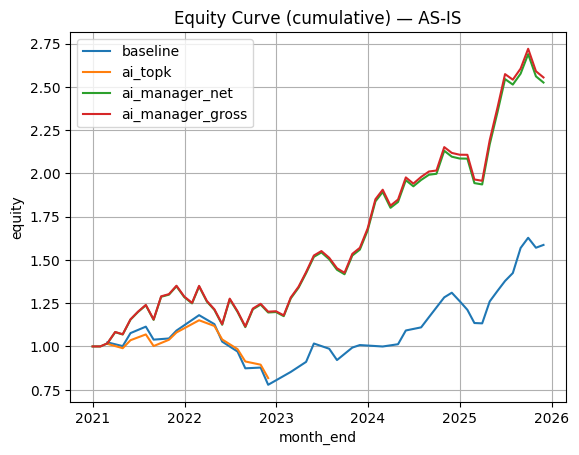

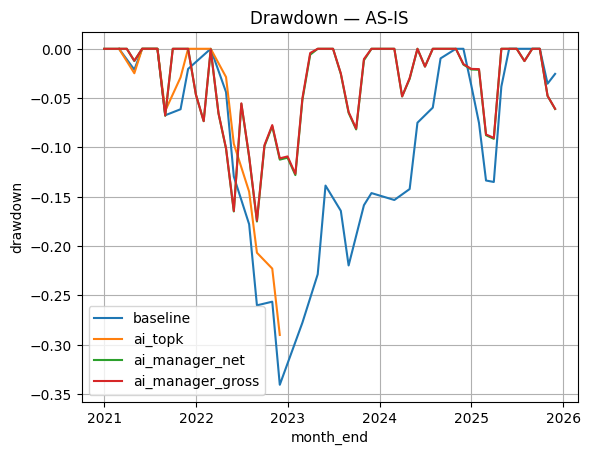

========== AUDITORÍA CONSTRAINTS (IA Manager) ==========
Meses en cache: 60 | Violaciones: 20


,month_end,sum_w,n_positions,min_w,max_w,ok_sum,ok_topk,ok_min,ok_max
0,2020-12-31,0,0,NaN,NaN,False,True,True,True
1,2021-01-31,0,0,NaN,NaN,False,True,True,True
2,2021-03-31,0,0,NaN,NaN,False,True,True,True
3,2021-06-30,0,0,NaN,NaN,False,True,True,True
4,2021-09-30,0,0,NaN,NaN,False,True,True,True
5,2021-12-31,0,0,NaN,NaN,False,True,True,True
6,2022-01-31,0,0,NaN,NaN,False,True,True,True
7,2022-03-31,0,0,NaN,NaN,False,True,True,True
8,2022-06-30,0,0,NaN,NaN,False,True,True,True
9,2022-09-30,0,0,NaN,NaN,False,True,True,True



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\ai_manager_constraints_violations.csv

========== COSTOS (IA Manager) ==========
Total tcost acumulado (aprox): 0.0118



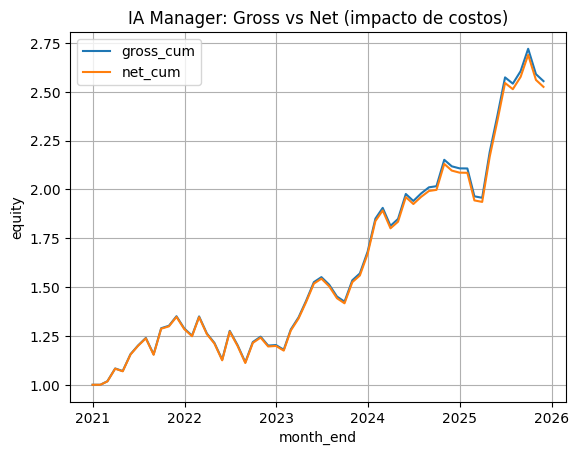

In [131]:
# ============================================================
# Celda 07 (FINAL): Auditoría profesional + Reporte comparativo
# - Incluye AS-IS
# - Incluye COMMON WINDOW (todas las estrategias disponibles)
# - FIX: agrega ventana "BASELINE vs AI_MANAGER" (intersección natural, sin recortar por ai_topk)
# - FIX: auditoría constraints soporta weights_json o weights_applied_json
# ============================================================

from __future__ import annotations

import json
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
REPORTS = PROJECT_ROOT / "reports"
CACHE = PROJECT_ROOT / "data" / "cache"

TOP_K=5
MIN_WEIGHT=0.05
MAX_WEIGHT=0.35
ALLOW_CASH=True
TCOST_BPS=10

paths = {
    "baseline_bt": REPORTS / "backtest_baseline_monthly.csv",
    "ai_topk_bt":  REPORTS / "backtest_ai_monthly.csv",
    "mgr_bt":      REPORTS / "backtest_ai_manager_monthly.csv",
    "baseline_hold": REPORTS / "holdings_baseline.parquet",
    "ai_topk_hold":  REPORTS / "holdings_ai.parquet",
    "mgr_hold":      REPORTS / "holdings_ai_manager.parquet",
    "mgr_trades":    REPORTS / "trades_ai_manager.csv",
    "mgr_decisions": CACHE / "ai_portfolio" / "ai_monthly_decisions.parquet",
}

print("========== CONFIG CELDA 07 (FINAL) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
for k, p in paths.items():
    print(f"{k:>14}: {p} | exists={p.exists()}")
print("============================================\n")

def load_csv_if_exists(p: Path) -> pd.DataFrame | None:
    if not p.exists():
        return None
    return pd.read_csv(p)

def load_parquet_if_exists(p: Path) -> pd.DataFrame | None:
    if not p.exists():
        return None
    return pd.read_parquet(p)

def perf_metrics_monthly(bt: pd.DataFrame, ret_col: str,
                         turnover_col: str | None = None,
                         cash_col: str | None = None,
                         tcost_col: str | None = None) -> dict:
    out = {}
    r = pd.to_numeric(bt[ret_col], errors="coerce").dropna()
    out["months"] = int(len(r))
    if len(r) < 6:
        return out

    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0

    years = len(r) / 12.0
    out["cagr"] = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan
    out["vol"] = float(r.std(ddof=0) * math.sqrt(12))
    out["mu_annual"] = float(r.mean() * 12)
    out["sharpe_0rf"] = float(out["mu_annual"] / out["vol"]) if out["vol"] and out["vol"] > 0 else np.nan
    out["max_drawdown"] = float(dd.min())

    if turnover_col and turnover_col in bt.columns:
        out["avg_turnover"] = float(pd.to_numeric(bt[turnover_col], errors="coerce").mean())
    if cash_col and cash_col in bt.columns:
        out["avg_cash"] = float(pd.to_numeric(bt[cash_col], errors="coerce").mean())
    if tcost_col and tcost_col in bt.columns:
        out["avg_tcost"] = float(pd.to_numeric(bt[tcost_col], errors="coerce").mean())

    return out

def equity_curve(bt: pd.DataFrame, ret_col: str) -> pd.DataFrame:
    x = bt.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x.sort_values("month_end")
    r = pd.to_numeric(x[ret_col], errors="coerce").fillna(0.0)
    x["equity"] = (1 + r).cumprod()
    x["peak"] = x["equity"].cummax()
    x["drawdown"] = (x["equity"] / x["peak"]) - 1.0
    return x[["month_end","equity","drawdown"]]

# 1) Cargar backtests
bt_baseline = load_csv_if_exists(paths["baseline_bt"])
bt_ai_topk  = load_csv_if_exists(paths["ai_topk_bt"])
bt_mgr      = load_csv_if_exists(paths["mgr_bt"])

if bt_mgr is None:
    raise FileNotFoundError("No existe backtest_ai_manager_monthly.csv. Ejecuta Celda 06C primero.")

available = []
if bt_baseline is not None and "port_ret_1m" in bt_baseline.columns:
    available.append(("baseline", bt_baseline, "port_ret_1m", "turnover", None, None))
if bt_ai_topk is not None and "port_ret_1m" in bt_ai_topk.columns:
    available.append(("ai_topk", bt_ai_topk, "port_ret_1m", "turnover", None, None))

available.append(("ai_manager_net", bt_mgr, "port_ret_net_1m", "turnover_oneway", "cash_weight", "tcost"))
if "port_ret_gross_1m" in bt_mgr.columns:
    available.append(("ai_manager_gross", bt_mgr, "port_ret_gross_1m", "turnover_oneway", "cash_weight", "tcost"))

print("========== BACKTESTS CARGADOS ==========")
for name, df, retc, *_ in available:
    m = pd.to_datetime(df["month_end"], errors="coerce").dt.normalize().nunique()
    print(f"{name:>16}: rows={len(df):>4} | meses={m:>3} | ret_col={retc}")
print("=======================================\n")

# 2) Métricas AS-IS
rows = []
for name, df, retc, toc, cashc, tcc in available:
    m = perf_metrics_monthly(df, retc, turnover_col=toc, cash_col=cashc, tcost_col=tcc)
    m["strategy"] = name
    rows.append(m)

summary_as_is = pd.DataFrame(rows)
cols_order = ["strategy","months","cagr","vol","sharpe_0rf","max_drawdown","avg_turnover","avg_cash","avg_tcost","mu_annual"]
summary_as_is = summary_as_is[[c for c in cols_order if c in summary_as_is.columns]]

print("========== COMPARATIVO (AS-IS) ==========")
display(summary_as_is.sort_values("strategy"))
print("=========================================\n")

out_summary_as_is = REPORTS / "strategy_comparison_summary_as_is.csv"
summary_as_is.to_csv(out_summary_as_is, index=False)
print(f"[OK] Guardado: {out_summary_as_is}\n")

# 3) COMMON WINDOW (todas las estrategias)
common_months = None
for _, df, _, *_ in available:
    s = set(pd.to_datetime(df["month_end"], errors="coerce").dt.normalize().dropna().unique())
    common_months = s if common_months is None else (common_months & s)
common_months = sorted(list(common_months or []))

print("========== COMMON WINDOW (ALL) ==========")
print(f"Estrategias consideradas: {len(available)} | Meses comunes: {len(common_months)}")
if common_months:
    print(f"Min/Max común: {min(common_months).date()} -> {max(common_months).date()}")
print("=========================================\n")

rows2 = []
for name, df, retc, toc, cashc, tcc in available:
    x = df.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x[x["month_end"].isin(common_months)]
    m = perf_metrics_monthly(x, retc, turnover_col=toc, cash_col=cashc, tcost_col=tcc)
    m["strategy"] = name
    rows2.append(m)

summary_common_all = pd.DataFrame(rows2)
summary_common_all = summary_common_all[[c for c in cols_order if c in summary_common_all.columns]]

print("========== COMPARATIVO (COMMON WINDOW - ALL) ==========")
display(summary_common_all.sort_values("strategy"))
print("======================================================\n")

out_summary_common_all = REPORTS / "strategy_comparison_summary_common_all.csv"
summary_common_all.to_csv(out_summary_common_all, index=False)
print(f"[OK] Guardado: {out_summary_common_all}\n")

# 4) COMMON WINDOW (BASELINE vs MANAGER) - comparación justa “real” sin recortar por ai_topk
pairs = []
if bt_baseline is not None:
    base_months = set(pd.to_datetime(bt_baseline["month_end"], errors="coerce").dt.normalize().dropna().unique())
    mgr_months  = set(pd.to_datetime(bt_mgr["month_end"], errors="coerce").dt.normalize().dropna().unique())
    common_bm = sorted(list(base_months & mgr_months))

    if common_bm:
        # baseline
        xb = bt_baseline.copy()
        xb["month_end"] = pd.to_datetime(xb["month_end"], errors="coerce").dt.normalize()
        xb = xb[xb["month_end"].isin(common_bm)]
        mb = perf_metrics_monthly(xb, "port_ret_1m", turnover_col="turnover")
        mb["strategy"] = "baseline_common_vs_mgr"
        pairs.append(mb)

        # manager net
        xm = bt_mgr.copy()
        xm["month_end"] = pd.to_datetime(xm["month_end"], errors="coerce").dt.normalize()
        xm = xm[xm["month_end"].isin(common_bm)]
        mm = perf_metrics_monthly(xm, "port_ret_net_1m", turnover_col="turnover_oneway", cash_col="cash_weight", tcost_col="tcost")
        mm["strategy"] = "ai_manager_net_common_vs_baseline"
        pairs.append(mm)

        # manager gross
        if "port_ret_gross_1m" in bt_mgr.columns:
            mg = perf_metrics_monthly(xm, "port_ret_gross_1m", turnover_col="turnover_oneway", cash_col="cash_weight", tcost_col="tcost")
            mg["strategy"] = "ai_manager_gross_common_vs_baseline"
            pairs.append(mg)

    summary_common_bm = pd.DataFrame(pairs)
    summary_common_bm = summary_common_bm[[c for c in cols_order if c in summary_common_bm.columns]]

    print("========== COMPARATIVO (COMMON WINDOW - BASELINE vs MANAGER) ==========")
    print(f"Meses comunes baseline vs manager: {len(common_bm)}")
    display(summary_common_bm.sort_values("strategy"))
    print("======================================================================\n")

    out_summary_common_bm = REPORTS / "strategy_comparison_summary_common_baseline_vs_manager.csv"
    summary_common_bm.to_csv(out_summary_common_bm, index=False)
    print(f"[OK] Guardado: {out_summary_common_bm}\n")

# 5) Gráficos: equity y drawdown AS-IS
plt.figure()
for name, df, retc, *_ in available:
    ec = equity_curve(df, retc)
    plt.plot(ec["month_end"], ec["equity"], label=name)
plt.title("Equity Curve (cumulative) — AS-IS")
plt.xlabel("month_end")
plt.ylabel("equity")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
for name, df, retc, *_ in available:
    ec = equity_curve(df, retc)
    plt.plot(ec["month_end"], ec["drawdown"], label=name)
plt.title("Drawdown — AS-IS")
plt.xlabel("month_end")
plt.ylabel("drawdown")
plt.legend()
plt.grid(True)
plt.show()

# 6) Auditoría constraints (manager)
dec = load_parquet_if_exists(paths["mgr_decisions"])
if dec is None:
    raise FileNotFoundError("No existe ai_monthly_decisions.parquet. Ejecuta Celda 06B/06 (manager) primero.")

dec = dec.copy()
dec["month_end"] = pd.to_datetime(dec["month_end"], errors="coerce").dt.normalize()
dec = dec.sort_values("month_end")

# Soporta distintos nombres de columna de pesos
weights_col = "weights_json" if "weights_json" in dec.columns else ("weights_applied_json" if "weights_applied_json" in dec.columns else None)
if weights_col is None:
    raise KeyError("No se encontró columna de pesos (weights_json / weights_applied_json) en el cache de decisiones.")

viol = []
for _, r in dec.iterrows():
    m = r["month_end"]
    try:
        w = json.loads(r[weights_col]) if isinstance(r[weights_col], str) and r[weights_col].strip() else {}
    except Exception:
        w = {}
    w = {str(k).upper().strip(): float(v) for k, v in (w or {}).items() if k is not None}

    s = sum(v for v in w.values())
    pos = [(k, v) for k, v in w.items() if k != "CASH" and v > 0]
    npos = len(pos)
    w_min = min([v for _, v in pos], default=np.nan)
    w_max = max([v for _, v in pos], default=np.nan)

    ok_sum = abs(s - 1.0) <= 1e-6
    ok_topk = npos <= TOP_K
    ok_min = (np.isnan(w_min) or w_min >= MIN_WEIGHT - 1e-9)
    ok_max = (np.isnan(w_max) or w_max <= MAX_WEIGHT + 1e-9)

    if not (ok_sum and ok_topk and ok_min and ok_max):
        viol.append({
            "month_end": str(m.date()),
            "sum_w": s,
            "n_positions": npos,
            "min_w": w_min,
            "max_w": w_max,
            "ok_sum": ok_sum,
            "ok_topk": ok_topk,
            "ok_min": ok_min,
            "ok_max": ok_max
        })

viol_df = pd.DataFrame(viol)
print("========== AUDITORÍA CONSTRAINTS (IA Manager) ==========")
print(f"Meses en cache: {dec['month_end'].nunique()} | Violaciones: {len(viol_df)}")
if not viol_df.empty:
    display(viol_df.head(20))
print("========================================================\n")

out_viol = REPORTS / "ai_manager_constraints_violations.csv"
viol_df.to_csv(out_viol, index=False)
print(f"[OK] Guardado: {out_viol}\n")

# 7) Costos: impacto acumulado (si existe)
if "tcost" in bt_mgr.columns and "port_ret_gross_1m" in bt_mgr.columns and "port_ret_net_1m" in bt_mgr.columns:
    x = bt_mgr.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x.sort_values("month_end")

    x["tcost_cum"] = pd.to_numeric(x["tcost"], errors="coerce").fillna(0).cumsum()
    x["gross_cum"] = (1 + pd.to_numeric(x["port_ret_gross_1m"], errors="coerce").fillna(0)).cumprod()
    x["net_cum"]   = (1 + pd.to_numeric(x["port_ret_net_1m"], errors="coerce").fillna(0)).cumprod()

    print("========== COSTOS (IA Manager) ==========")
    print(f"Total tcost acumulado (aprox): {x['tcost_cum'].iloc[-1]:.4f}")
    print("=========================================\n")

    plt.figure()
    plt.plot(x["month_end"], x["gross_cum"], label="gross_cum")
    plt.plot(x["month_end"], x["net_cum"], label="net_cum")
    plt.title("IA Manager: Gross vs Net (impacto de costos)")
    plt.xlabel("month_end")
    plt.ylabel("equity")
    plt.legend()
    plt.grid(True)
    plt.show()


========== CELDA FINAL (ALL-IN-ONE) ==========
Fecha/hora: 2025-12-14 20:33:06
BACKTEST_YEARS=5 | TOP_K=5 | ALLOW_CASH=True
MIN_WEIGHT=0.05 | MAX_WEIGHT=0.35 | TCOST_BPS=10
FILL_HOLD_MONTHS=True | RECALC_MANAGER_FROM_CACHE=True | RUN_FINAL_REPORT=True

[INFO] universe.csv exists=True | n_universe=10

========== PANEL / VENTANA ==========
Ventana: 2020-12-31 00:00:00 -> 2025-11-30 00:00:00 | filas: 480
Meses en ventana: 60
Tickers en ventana: 8

========== AUDITORÍA MESES ==========
Meses en ventana: 60
Meses en cache:   60
Meses faltantes:  0



,month_end,n_tickers_total,n_eligible_hasfund_and_ai,eligible_tickers


[OK] No hay meses faltantes; no se requiere HOLD fill.

========== DECISIONES (CACHE EN VENTANA) ==========
Filas en cache (en ventana): 60
Min/Max month_end: 2020-12-31 00:00:00 -> 2025-11-30 00:00:00

========== BACKTEST IA MANAGER (RECALC) ==========
NET : {'months': 60, 'cagr': 0.20349549641717313, 'vol': 0.18261513360958606, 'mu_annual': 0.2029946032047385, 'sharpe_0rf': 1.1115979228683304, 'max_drawdown': -0.1751336800667852, 'avg_turnover': 0.197, 'avg_cash': 0.08916666666666666, 'avg_tcost': 0.00019699999999999996}
GROSS: {'months': 60, 'cagr': 0.20629186294865232, 'vol': 0.1826619375881666, 'mu_annual': 0.20535860320473853, 'sharpe_0rf': 1.1242550359218477, 'max_drawdown': -0.17422733779560806, 'avg_turnover': 0.197, 'avg_cash': 0.08916666666666666, 'avg_tcost': 0.00019699999999999996}


,month_end,n_positions,cash_weight,turnover_oneway,tcost,port_ret_gross_1m,port_ret_net_1m,dropped_no_return
48,2024-12-31,5,0.15,0.10,0.00010,-0.004950,-0.005050,
49,2025-01-31,5,0.15,0.10,0.00010,-0.000225,-0.000325,
50,2025-02-28,5,0.10,0.17,0.00017,-0.067642,-0.067812,
51,2025-03-31,5,0.15,0.10,0.00010,-0.003860,-0.003960,
52,2025-04-30,5,0.10,0.15,0.00015,0.119928,0.119778,
53,2025-05-31,5,0.05,0.22,0.00022,0.086121,0.085901,
54,2025-06-30,5,0.05,0.05,0.00005,0.080992,0.080942,
55,2025-07-31,5,0.05,0.00,0.00000,-0.012444,-0.012444,
56,2025-08-31,4,0.05,0.10,0.00010,0.025192,0.025092,
57,2025-09-30,5,0.05,0.10,0.00010,0.043918,0.043818,



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\backtest_ai_manager_monthly.csv
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\holdings_ai_manager.parquet
[OK] Guardado: C:\Quant\GESTOR DE IA\reports\trades_ai_manager.csv

========== ÚLTIMA DECISIÓN (desde cache) ==========
Mes: 2025-11-30
Decision: {'cash_weight': 0.05, 'positions': [{'ticker': 'NVDA', 'weight': 0.3}, {'ticker': 'MSFT', 'weight': 0.3}, {'ticker': 'AMZN', 'weight': 0.15}, {'ticker': 'AAPL', 'weight': 0.1}, {'ticker': 'XOM', 'weight': 0.1}], 'expected_turnover': 'medium', 'key_reasons': ['Mantengo sesgo a calidad: NVDA y MSFT lideran en overall/quality con riesgo relativamente低', 'Reduzco concentración: recorto MSFT vs previo y mantengo NVDA sin subir para evitar exceso', 'Mantengo AMZN por alta confianza y perfil de crecimiento con riesgo moderado', 'Incorporo AAPL con peso contenido: buena calidad y alta confianza pero riesgo elevado (de-', 'Mantengo XOM como diversificador defensivo/valor con volatilidad baja y métricas 

,strategy,months,cagr,vol,sharpe_0rf,max_drawdown,avg_turnover,avg_cash,avg_tcost,mu_annual
3,ai_manager_gross,60,0.206292,0.182662,1.124255,-0.174227,0.197000,0.089167,0.000197,0.205359
2,ai_manager_net,60,0.203495,0.182615,1.111598,-0.175134,0.197000,0.089167,0.000197,0.202995
1,ai_topk,14,-0.158945,0.172110,-0.911387,-0.290170,0.071429,NaN,NaN,-0.156859
0,baseline,40,0.148491,0.209286,0.769762,-0.340693,0.331429,NaN,NaN,0.161100



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\strategy_comparison_summary_as_is.csv

========== COMMON WINDOW ==========
Estrategias consideradas: 4 | Meses comunes: 14
Min/Max común: 2021-02-28 -> 2022-11-30

========== COMPARATIVO (COMMON WINDOW) ==========


,strategy,months,cagr,vol,sharpe_0rf,max_drawdown,avg_turnover,avg_cash,avg_tcost,mu_annual
3,ai_manager_gross,14,-0.077887,0.177418,-0.366758,-0.230251,0.277857,0.028571,0.000278,-0.065069
2,ai_manager_net,14,-0.080955,0.177261,-0.385893,-0.231152,0.277857,0.028571,0.000278,-0.068404
1,ai_topk,14,-0.158945,0.172110,-0.911387,-0.290170,0.071429,NaN,NaN,-0.156859
0,baseline,14,-0.193233,0.213923,-0.885770,-0.340693,0.391156,NaN,NaN,-0.189486



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\strategy_comparison_summary_common_window.csv



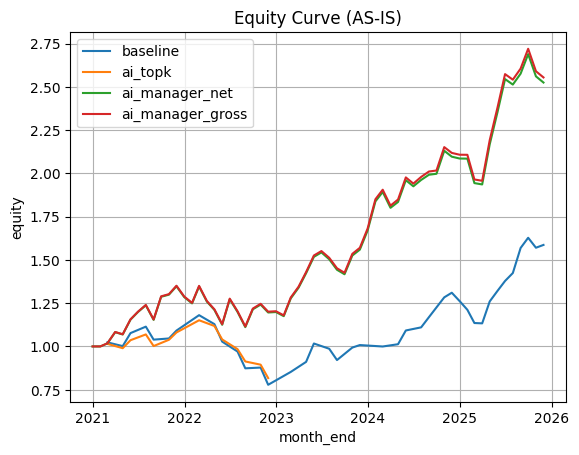

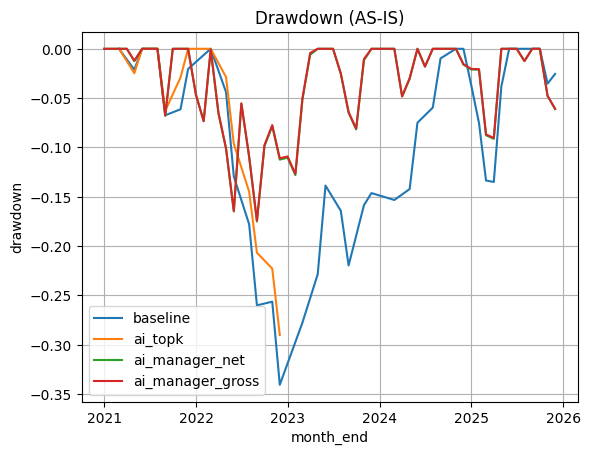

========== HOLDINGS (FRECUENCIA/PESOS) ==========


,strategy,ticker,months_in_port,avg_weight,max_weight
21,ai_manager,CASH,60,0.089167,1.000000
13,ai_manager,MSFT,58,0.275345,0.350000
14,ai_manager,JNJ,48,0.183542,0.300000
15,ai_manager,NVDA,39,0.228718,0.350000
16,ai_manager,AAPL,39,0.179231,0.250000
17,ai_manager,KO,32,0.150000,0.200000
18,ai_manager,XOM,29,0.129655,0.200000
19,ai_manager,AMZN,26,0.140385,0.200000
20,ai_manager,TSLA,13,0.134615,0.150000
9,ai_topk,AAPL,14,0.333333,0.333333



[OK] Guardado: C:\Quant\GESTOR DE IA\reports\holdings_frequency_and_weights.csv

========== AUDITORÍA CONSTRAINTS (IA Manager) ==========
Meses en cache: 60 | Violaciones: 0

[OK] Guardado: C:\Quant\GESTOR DE IA\reports\ai_manager_constraints_violations.csv

========== ÚLTIMAS 3 DECISIONES IA (texto) ==========

--- 2025-09-30 ---
weights: {'NVDA': 0.28, 'MSFT': 0.32, 'AMZN': 0.15, 'JNJ': 0.1, 'XOM': 0.1, 'CASH': 0.05000000000000001}
expected_turnover: medium
risk_summary: Riesgo global moderado: cartera sigue concentrada en mega-cap tech pero con menor concentración que el mes previo; NVDA aporta mayor volatilidad relativa, mitigada por MSFT y la inclusión de JNJ/XOM; se mantiene 5% cash;
key_reasons: ['Reducir concentración vs. mes previo bajando NVDA y MSFT desde 0.35 cada una para mejorar,', 'Mantener sesgo a calidad y baja volatilidad: NVDA y MSFT combinan altos puntajes overall/', 'Conservar AMZN por buena confianza y perfil de crecimiento, pero sin sobreponderar por q', 'Añadir

In [132]:
# ============================================================
# CELDA FINAL (ALL-IN-ONE) — Auditoría + HOLD fill + Recalc + Reporte
# Incluye parches:
# - No falla si missing_months=0 (KeyError 'month_end')
# - Cache decisions: migración robusta + compatibilidad weights_json/weights_applied_json
# - Recalc IA Manager (gross/net) desde cache (sin OpenAI)
# - Reporte comparativo (AS-IS + COMMON WINDOW) + gráficos + holdings + constraints
# ============================================================

from __future__ import annotations

import json, math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# -----------------------------
# 0) Config
# -----------------------------
PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")

DIRS = {
    "DATA_PROCESSED": PROJECT_ROOT / "data" / "processed",
    "DATA_CACHE":     PROJECT_ROOT / "data" / "cache",
    "REPORTS":        PROJECT_ROOT / "reports",
    "CONFIGS":        PROJECT_ROOT / "configs",
}

BACKTEST_YEARS = 5
TOP_K = 5
MIN_WEIGHT = 0.05
MAX_WEIGHT = 0.35
ALLOW_CASH = True
TCOST_BPS = 10  # 10 bps por 100% turnover one-way

# Switches del runner final
FILL_HOLD_MONTHS = True         # si faltan meses en cache, rellena con HOLD (sin OpenAI)
RECALC_MANAGER_FROM_CACHE = True
RUN_FINAL_REPORT = True         # comparativo + gráficos + holdings + constraints

# Tolerancias
SUM_TOL = 1e-6

print("========== CELDA FINAL (ALL-IN-ONE) ==========")
print(f"Fecha/hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"BACKTEST_YEARS={BACKTEST_YEARS} | TOP_K={TOP_K} | ALLOW_CASH={ALLOW_CASH}")
print(f"MIN_WEIGHT={MIN_WEIGHT} | MAX_WEIGHT={MAX_WEIGHT} | TCOST_BPS={TCOST_BPS}")
print(f"FILL_HOLD_MONTHS={FILL_HOLD_MONTHS} | RECALC_MANAGER_FROM_CACHE={RECALC_MANAGER_FROM_CACHE} | RUN_FINAL_REPORT={RUN_FINAL_REPORT}")
print("==============================================\n")


# -----------------------------
# 1) Utilidades
# -----------------------------
def ensure_float_dict(d: dict) -> dict:
    out = {}
    for k, v in (d or {}).items():
        try:
            out[str(k).upper().strip()] = float(v)
        except Exception:
            continue
    return out

def safe_json_load(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip():
        try:
            return json.loads(x)
        except Exception:
            return None
    return None

def safe_json_dump(x) -> str:
    if isinstance(x, str):
        return x
    try:
        return json.dumps(x, ensure_ascii=False)
    except Exception:
        return ""

def derive_positions_from_weights(w: dict):
    pos = []
    for t, wt in (w or {}).items():
        if t == "CASH":
            continue
        try:
            wt = float(wt)
        except Exception:
            wt = 0.0
        if wt > 0:
            pos.append({"ticker": t, "weight": wt})
    pos.sort(key=lambda x: x["weight"], reverse=True)
    return pos

def normalize_weights(w: dict, allow_cash: bool = True) -> dict:
    """Asegura: keys upper, floats, CASH consistente, suma<=1 normalizada si excede."""
    w = ensure_float_dict(w or {})
    # separar cash
    cash = float(w.get("CASH", 0.0)) if allow_cash else 0.0
    # limpiar negativos
    for k in list(w.keys()):
        if not np.isfinite(w[k]) or w[k] < 0:
            w.pop(k, None)
    if "CASH" in w:
        cash = max(0.0, float(w.get("CASH", 0.0)))
        if not allow_cash:
            w.pop("CASH", None)
            cash = 0.0

    # suma de riesgos
    risky_sum = sum(float(v) for k, v in w.items() if k != "CASH")
    if allow_cash:
        # si no existe CASH, lo derivamos; si existe, lo respetamos pero evitamos inconsistencias
        if "CASH" not in w:
            w["CASH"] = max(0.0, 1.0 - risky_sum)
        else:
            # si sum > 1 por cash inconsistente, normalizamos luego
            w["CASH"] = max(0.0, float(w["CASH"]))
    else:
        w.pop("CASH", None)

    total = sum(float(v) for v in w.values())
    if total > 1.0 + 1e-9:
        # normalizar todo (incluyendo cash) para que sume 1
        for k in list(w.keys()):
            w[k] = float(w[k]) / total

    # re-clip para evitar -0.0
    w = {k: float(max(0.0, v)) for k, v in w.items()}
    return w

def migrate_decisions_cache(df: pd.DataFrame) -> pd.DataFrame:
    """
    Estandariza el schema del cache y asegura compatibilidad:
    - month_end
    - decision_json (str)
    - weights_json (str)
    - weights_applied_json (str)  (alias/compatibilidad)
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=[
            "month_end","decision_json","weights_json","weights_applied_json",
            "created_at","model","expected_turnover","risk_summary","key_reasons",
            "cash_weight","n_positions"
        ])

    df = df.copy()

    # month_end
    if "month_end" not in df.columns:
        for alt in ["month", "date", "dt"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "month_end"})
                break

    # decision_json
    if "decision_json" not in df.columns:
        for alt in ["decision", "decision_text", "decision_str"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "decision_json"})
                break
    if "decision_json" not in df.columns:
        df["decision_json"] = ""

    # weights_json / weights_applied_json
    if "weights_applied_json" not in df.columns and "weights_json" in df.columns:
        df["weights_applied_json"] = df["weights_json"].apply(safe_json_dump)

    if "weights_json" not in df.columns and "weights_applied_json" in df.columns:
        df["weights_json"] = df["weights_applied_json"].apply(safe_json_dump)

    if "weights_json" not in df.columns and "weights_applied_json" not in df.columns:
        # derivar desde decision_json (si posible)
        def _derive_from_dec(x):
            obj = safe_json_load(x)
            if not isinstance(obj, dict):
                return ""
            w = {}
            for p in obj.get("positions", []) or []:
                if isinstance(p, dict):
                    t = str(p.get("ticker", "")).upper().strip()
                    try:
                        wt = float(p.get("weight", 0.0))
                    except Exception:
                        wt = 0.0
                    if t and wt > 0:
                        w[t] = wt
            try:
                cw = float(obj.get("cash_weight", 0.0))
            except Exception:
                cw = 0.0
            if ALLOW_CASH:
                w["CASH"] = max(0.0, cw)
            w = normalize_weights(w, allow_cash=ALLOW_CASH)
            return json.dumps(w, ensure_ascii=False)

        df["weights_json"] = df["decision_json"].apply(_derive_from_dec)
        df["weights_applied_json"] = df["weights_json"]

    # tipos finales
    df["month_end"] = pd.to_datetime(df["month_end"], errors="coerce").dt.normalize()
    df["decision_json"] = df["decision_json"].fillna("").astype(str)
    df["weights_json"] = df["weights_json"].fillna("").astype(str)
    df["weights_applied_json"] = df["weights_applied_json"].fillna("").astype(str)

    # columnas auxiliares opcionales (para auditoría/reportes)
    for c in ["created_at","model","expected_turnover","risk_summary","key_reasons","cash_weight","n_positions"]:
        if c not in df.columns:
            df[c] = pd.NA

    return df

def parse_weights_from_row(row: pd.Series) -> dict:
    # preferimos weights_applied_json, pero mantenemos compatibilidad
    w = safe_json_load(row.get("weights_applied_json", "")) or safe_json_load(row.get("weights_json", "")) or {}
    if not isinstance(w, dict):
        w = {}
    return normalize_weights(w, allow_cash=ALLOW_CASH)

def equity_curve(bt: pd.DataFrame, ret_col: str) -> pd.DataFrame:
    x = bt.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x.sort_values("month_end")
    r = pd.to_numeric(x[ret_col], errors="coerce").fillna(0.0)
    x["equity"] = (1 + r).cumprod()
    x["peak"] = x["equity"].cummax()
    x["drawdown"] = (x["equity"] / x["peak"]) - 1.0
    return x[["month_end","equity","drawdown"]]

def perf_metrics_monthly(bt: pd.DataFrame, ret_col: str, turnover_col: str | None = None, cash_col: str | None = None, tcost_col: str | None = None) -> dict:
    out = {}
    r = pd.to_numeric(bt[ret_col], errors="coerce").dropna()
    out["months"] = int(len(r))
    if len(r) < 6:
        return out

    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0

    years = len(r) / 12.0
    out["cagr"] = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan
    out["vol"] = float(r.std(ddof=0) * math.sqrt(12))
    out["mu_annual"] = float(r.mean() * 12)
    out["sharpe_0rf"] = float(out["mu_annual"] / out["vol"]) if out["vol"] and out["vol"] > 0 else np.nan
    out["max_drawdown"] = float(dd.min())

    if turnover_col and turnover_col in bt.columns:
        out["avg_turnover"] = float(pd.to_numeric(bt[turnover_col], errors="coerce").mean())
    if cash_col and cash_col in bt.columns:
        out["avg_cash"] = float(pd.to_numeric(bt[cash_col], errors="coerce").mean())
    if tcost_col and tcost_col in bt.columns:
        out["avg_tcost"] = float(pd.to_numeric(bt[tcost_col], errors="coerce").mean())

    return out


# -----------------------------
# 2) Cargar universo (si existe) + panel + ventana
# -----------------------------
universe = None
universe_path = DIRS["CONFIGS"] / "universe.csv"
if universe_path.exists():
    u = pd.read_csv(universe_path)
    if "ticker" in u.columns:
        universe = u["ticker"].dropna().astype(str).str.upper().str.strip().tolist()
        universe = sorted(list(dict.fromkeys(universe)))
print(f"[INFO] universe.csv exists={universe_path.exists()} | n_universe={len(universe) if universe else 'ALL(panel)'}")

panel_path = DIRS["DATA_PROCESSED"] / "panel_monthly_gold.parquet"
panel = pd.read_parquet(panel_path).copy()
panel["ticker"] = panel["ticker"].astype(str).str.upper().str.strip()
panel["month_end"] = pd.to_datetime(panel["month_end"], errors="coerce").dt.normalize()

if universe:
    panel = panel[panel["ticker"].isin(set(universe))].copy()

panel = panel.sort_values(["ticker","month_end"]).copy()

if "ret_m" not in panel.columns:
    if "price" in panel.columns:
        panel["ret_m"] = panel.groupby("ticker")["price"].pct_change()
    else:
        raise KeyError("No existe ret_m ni price en panel_monthly_gold.parquet")

panel["ret_fwd_1m"] = panel.groupby("ticker")["ret_m"].shift(-1)

last_dt = panel["month_end"].max()
start_dt = last_dt - pd.DateOffset(years=BACKTEST_YEARS)

panel_bt = panel[(panel["month_end"] >= start_dt) & (panel["ret_fwd_1m"].notna())].copy()
months_all = sorted(panel_bt["month_end"].unique())

print("\n========== PANEL / VENTANA ==========")
print(f"Ventana: {panel_bt['month_end'].min()} -> {panel_bt['month_end'].max()} | filas: {len(panel_bt)}")
print(f"Meses en ventana: {len(months_all)}")
print(f"Tickers en ventana: {panel_bt['ticker'].nunique()}")
print("=====================================\n")


# -----------------------------
# 3) Auditoría de meses + HOLD fill (opcional)
# -----------------------------
decisions_path = DIRS["DATA_CACHE"] / "ai_portfolio" / "ai_monthly_decisions.parquet"
if not decisions_path.exists():
    raise FileNotFoundError(f"No existe decisions cache: {decisions_path}")

dec_cache = pd.read_parquet(decisions_path)
dec_cache = migrate_decisions_cache(dec_cache)

# filtrar a ventana
dec_cache_win = dec_cache[dec_cache["month_end"].isin(months_all)].copy()
have_months = set(dec_cache_win["month_end"].dropna().tolist())
missing_months = [m for m in months_all if m not in have_months]

print("========== AUDITORÍA MESES ==========")
print(f"Meses en ventana: {len(months_all)}")
print(f"Meses en cache:   {len(have_months)}")
print(f"Meses faltantes:  {len(missing_months)}")
print("====================================\n")

# Patch crítico: si no hay faltantes, df vacío con columnas y sin sort peligrosos
miss_cols = ["month_end","n_tickers_total","n_eligible_hasfund_and_ai","eligible_tickers"]
rows = []

# Para elegibilidad (has_fund & IA) solo si existen columnas; si no, reportamos NA sin romper
has_hasfund = "has_fund" in panel_bt.columns
has_overall = "overall_score" in panel_bt.columns

for m in missing_months:
    g = panel_bt[panel_bt["month_end"] == m].copy()
    if has_hasfund and has_overall:
        elig = g[g["has_fund"] & g["overall_score"].notna()]
        n_elig = int(elig["ticker"].nunique())
        elig_list = ",".join(sorted(elig["ticker"].unique().tolist()))
    else:
        n_elig = 0
        elig_list = ""
    rows.append({
        "month_end": m,
        "n_tickers_total": int(g["ticker"].nunique()),
        "n_eligible_hasfund_and_ai": n_elig,
        "eligible_tickers": elig_list
    })

df_miss = pd.DataFrame(rows, columns=miss_cols)
if not df_miss.empty:
    df_miss = df_miss.sort_values("month_end")
display(df_miss)

if len(missing_months) == 0:
    print("[OK] No hay meses faltantes; no se requiere HOLD fill.\n")

# HOLD fill si aplica
if FILL_HOLD_MONTHS and len(missing_months) > 0:
    print("\n[RUN] Rellenando meses faltantes con HOLD (sin llamadas a OpenAI)...")

    # pesos por mes (de lo existente)
    dec_sorted = dec_cache_win.sort_values("month_end").reset_index(drop=True)
    weights_by_month = {}
    for _, r in dec_sorted.iterrows():
        m = pd.to_datetime(r["month_end"]).normalize()
        w = parse_weights_from_row(r)
        if isinstance(w, dict) and len(w) > 0:
            weights_by_month[m] = w

    prev_w = {"CASH": 1.0} if ALLOW_CASH else {}
    new_rows = []

    for m in months_all:
        m = pd.to_datetime(m).normalize()

        if m in weights_by_month:
            prev_w = weights_by_month[m]
            continue

        if m not in set(missing_months):
            continue

        hold_w = normalize_weights(dict(prev_w), allow_cash=ALLOW_CASH)

        decision_obj = {
            "cash_weight": float(hold_w.get("CASH", 0.0)),
            "positions": derive_positions_from_weights(hold_w),
            "expected_turnover": "low",
            "key_reasons": [
                "HOLD automático: mes sin decisión previa en cache dentro de la ventana.",
                "Se mantienen pesos del mes anterior para continuidad del backtest."
            ],
            "risk_summary": "HOLD: continuidad operativa ante ausencia de decisión; sin rebalance."
        }

        new_rows.append({
            "month_end": m,
            "decision_json": json.dumps(decision_obj, ensure_ascii=False),
            "weights_json": json.dumps(hold_w, ensure_ascii=False),
            "weights_applied_json": json.dumps(hold_w, ensure_ascii=False),
            "n_positions": int(len([k for k in hold_w.keys() if k != "CASH"])),
            "cash_weight": float(hold_w.get("CASH", 0.0)),
            "expected_turnover": "low",
            "risk_summary": decision_obj["risk_summary"],
            "key_reasons": json.dumps(decision_obj["key_reasons"], ensure_ascii=False),
            "model": "HOLD_FILL",
            "created_at": datetime.now(),
        })

    if len(new_rows) > 0:
        dec_new = pd.DataFrame(new_rows)
        dec_all = pd.concat([dec_cache, dec_new], ignore_index=True)
        dec_all = migrate_decisions_cache(dec_all)
        dec_all = dec_all.drop_duplicates(subset=["month_end"], keep="last").sort_values("month_end")
        dec_all.to_parquet(decisions_path, index=False)
        print(f"[OK] HOLDs añadidos. Cache actualizado: {decisions_path} | filas_total={len(dec_all)}\n")
    else:
        print("[OK] No se generaron HOLDs (no había meses realmente faltantes).\n")

# Releer cache ya definitivo y filtrar a ventana
dec_use = pd.read_parquet(decisions_path)
dec_use = migrate_decisions_cache(dec_use)
dec_use = dec_use[dec_use["month_end"].isin(months_all)].copy()
dec_use = dec_use.sort_values("month_end").reset_index(drop=True)

print("========== DECISIONES (CACHE EN VENTANA) ==========")
print(f"Filas en cache (en ventana): {len(dec_use)}")
print(f"Min/Max month_end: {dec_use['month_end'].min()} -> {dec_use['month_end'].max()}")
print("===============================================\n")


# -----------------------------
# 4) Recalc IA Manager desde cache (gross/net) + guardar artefactos
# -----------------------------
bt_mgr = None
hold_mgr = None
trades_mgr = None
mgr_metrics_net = None
mgr_metrics_gross = None

if RECALC_MANAGER_FROM_CACHE:
    ret_tbl = panel_bt[["month_end", "ticker", "ret_fwd_1m"]].copy()
    ret_tbl["month_end"] = pd.to_datetime(ret_tbl["month_end"], errors="coerce").dt.normalize()

    rows_bt, rows_hold, rows_trades = [], [], []
    prev_w = {"CASH": 1.0} if ALLOW_CASH else {}

    # iterar en orden temporal de meses (robustez)
    dec_map = {pd.to_datetime(r["month_end"]).normalize(): r for _, r in dec_use.iterrows()}

    for m in months_all:
        m = pd.to_datetime(m).normalize()
        if m not in dec_map:
            continue

        dr = dec_map[m]
        w = parse_weights_from_row(dr)
        if len(w) == 0:
            continue

        g = ret_tbl[ret_tbl["month_end"] == m].set_index("ticker")["ret_fwd_1m"].to_dict()

        # dropear tickers sin retorno -> a CASH
        dropped = []
        w2 = dict(w)
        for t in list(w2.keys()):
            if t == "CASH":
                continue
            if t not in g or pd.isna(g[t]):
                dropped.append(t)
                w2["CASH"] = float(w2.get("CASH", 0.0)) + float(w2.get(t, 0.0))
                w2.pop(t, None)

        w2 = normalize_weights(w2, allow_cash=ALLOW_CASH)

        # gross
        gross = 0.0
        for t, wt in w2.items():
            if t == "CASH":
                continue
            gross += float(wt) * float(g.get(t, 0.0))

        # turnover one-way
        keys = set(prev_w.keys()).union(set(w2.keys()))
        l1 = sum(abs(float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0))) for k in keys)
        turnover_oneway = 0.5 * l1

        tcost = turnover_oneway * (TCOST_BPS / 10000.0)
        net = gross - tcost

        rows_bt.append({
            "month_end": m,
            "n_positions": int(len([k for k in w2.keys() if k != "CASH"])),
            "cash_weight": float(w2.get("CASH", 0.0)),
            "turnover_oneway": float(turnover_oneway),
            "tcost": float(tcost),
            "port_ret_gross_1m": float(gross),
            "port_ret_net_1m": float(net),
            "dropped_no_return": ",".join(dropped)
        })

        for t, wt in w2.items():
            rows_hold.append({"month_end": m, "ticker": t, "weight": float(wt)})

        for k in keys:
            dw = float(w2.get(k, 0.0)) - float(prev_w.get(k, 0.0))
            if abs(dw) > 1e-9:
                rows_trades.append({
                    "month_end": m,
                    "ticker": k,
                    "prev_weight": float(prev_w.get(k, 0.0)),
                    "new_weight": float(w2.get(k, 0.0)),
                    "delta_weight": float(dw),
                    "side": "BUY" if dw > 0 else "SELL"
                })

        prev_w = w2

    bt_mgr = pd.DataFrame(rows_bt).sort_values("month_end").reset_index(drop=True)
    hold_mgr = pd.DataFrame(rows_hold).sort_values(["month_end","ticker"]).reset_index(drop=True)
    trades_mgr = pd.DataFrame(rows_trades).sort_values(["month_end","ticker"]).reset_index(drop=True)

    mgr_metrics_net = perf_metrics_monthly(bt_mgr, "port_ret_net_1m", "turnover_oneway", "cash_weight", "tcost")
    mgr_metrics_gross = perf_metrics_monthly(bt_mgr, "port_ret_gross_1m", "turnover_oneway", "cash_weight", "tcost")

    print("========== BACKTEST IA MANAGER (RECALC) ==========")
    print("NET :", mgr_metrics_net)
    print("GROSS:", mgr_metrics_gross)
    display(bt_mgr.tail(12))
    print("==================================================\n")

    # Guardar artefactos
    bt_path = DIRS["REPORTS"] / "backtest_ai_manager_monthly.csv"
    hold_path = DIRS["REPORTS"] / "holdings_ai_manager.parquet"
    trades_path = DIRS["REPORTS"] / "trades_ai_manager.csv"

    bt_mgr.to_csv(bt_path, index=False)
    hold_mgr.to_parquet(hold_path, index=False)
    trades_mgr.to_csv(trades_path, index=False)

    print("[OK] Guardado:", bt_path)
    print("[OK] Guardado:", hold_path)
    print("[OK] Guardado:", trades_path)

    # Última decisión (texto)
    if not bt_mgr.empty:
        last_m = pd.to_datetime(bt_mgr["month_end"].max()).normalize()
        last_dec = dec_use[dec_use["month_end"] == last_m].tail(1)
        if len(last_dec) == 1:
            print("\n========== ÚLTIMA DECISIÓN (desde cache) ==========")
            print("Mes:", last_m.date())
            try:
                print("Decision:", safe_json_load(last_dec["decision_json"].iloc[0]))
            except Exception:
                print("Decision (raw):", last_dec["decision_json"].iloc[0])
            try:
                print("Pesos:", safe_json_load(last_dec["weights_json"].iloc[0]) or safe_json_load(last_dec["weights_applied_json"].iloc[0]))
            except Exception:
                print("Pesos (raw):", last_dec["weights_json"].iloc[0])
            print("===============================================\n")


# -----------------------------
# 5) Reporte comparativo + gráficos + holdings + constraints
# -----------------------------
if RUN_FINAL_REPORT:
    REPORTS = DIRS["REPORTS"]

    paths = {
        "baseline_bt": REPORTS / "backtest_baseline_monthly.csv",
        "ai_topk_bt":  REPORTS / "backtest_ai_monthly.csv",
        "mgr_bt":      REPORTS / "backtest_ai_manager_monthly.csv",
        "baseline_hold": REPORTS / "holdings_baseline.parquet",
        "ai_topk_hold":  REPORTS / "holdings_ai.parquet",
        "mgr_hold":      REPORTS / "holdings_ai_manager.parquet",
        "mgr_decisions": DIRS["DATA_CACHE"] / "ai_portfolio" / "ai_monthly_decisions.parquet",
    }

    print("========== REPORTE (CONFIG) ==========")
    for k, p in paths.items():
        print(f"{k:>14}: {p} | exists={p.exists()}")
    print("======================================\n")

    def load_csv_if_exists(p: Path) -> pd.DataFrame | None:
        if not p.exists():
            return None
        return pd.read_csv(p)

    def load_parquet_if_exists(p: Path) -> pd.DataFrame | None:
        if not p.exists():
            return None
        return pd.read_parquet(p)

    bt_baseline = load_csv_if_exists(paths["baseline_bt"])
    bt_ai_topk  = load_csv_if_exists(paths["ai_topk_bt"])
    bt_mgr_rep  = load_csv_if_exists(paths["mgr_bt"])

    if bt_mgr_rep is None:
        raise FileNotFoundError("No existe backtest_ai_manager_monthly.csv (recalc). Ejecuta este runner con RECALC_MANAGER_FROM_CACHE=True.")

    # Construir lista de estrategias disponibles
    available = []
    if bt_baseline is not None and "port_ret_1m" in bt_baseline.columns:
        available.append(("baseline", bt_baseline, "port_ret_1m", "turnover", None, None))
    if bt_ai_topk is not None and "port_ret_1m" in bt_ai_topk.columns:
        available.append(("ai_topk", bt_ai_topk, "port_ret_1m", "turnover", None, None))

    available.append(("ai_manager_net", bt_mgr_rep, "port_ret_net_1m", "turnover_oneway", "cash_weight", "tcost"))
    if "port_ret_gross_1m" in bt_mgr_rep.columns:
        available.append(("ai_manager_gross", bt_mgr_rep, "port_ret_gross_1m", "turnover_oneway", "cash_weight", "tcost"))

    # (A) AS-IS
    rows = []
    for name, df, retc, toc, cashc, tcc in available:
        m = perf_metrics_monthly(df, retc, turnover_col=toc, cash_col=cashc, tcost_col=tcc)
        m["strategy"] = name
        rows.append(m)
    summary_as_is = pd.DataFrame(rows)
    cols_order = ["strategy","months","cagr","vol","sharpe_0rf","max_drawdown","avg_turnover","avg_cash","avg_tcost","mu_annual"]
    summary_as_is = summary_as_is[[c for c in cols_order if c in summary_as_is.columns]]

    print("========== COMPARATIVO (AS-IS) ==========")
    display(summary_as_is.sort_values("strategy"))
    print("=========================================\n")

    out_as_is = REPORTS / "strategy_comparison_summary_as_is.csv"
    summary_as_is.to_csv(out_as_is, index=False)
    print(f"[OK] Guardado: {out_as_is}\n")

    # (B) COMMON WINDOW (intersección de meses)
    months_sets = []
    for _, df, _, _, _, _ in available:
        mset = set(pd.to_datetime(df["month_end"], errors="coerce").dt.normalize().dropna().unique().tolist())
        months_sets.append(mset)

    common_months = sorted(list(set.intersection(*months_sets))) if months_sets else []
    print("========== COMMON WINDOW ==========")
    print(f"Estrategias consideradas: {len(available)} | Meses comunes: {len(common_months)}")
    if common_months:
        print(f"Min/Max común: {common_months[0].date()} -> {common_months[-1].date()}")
    print("===================================\n")

    rows_cw = []
    for name, df, retc, toc, cashc, tcc in available:
        x = df.copy()
        x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
        x = x[x["month_end"].isin(common_months)].copy()
        m = perf_metrics_monthly(x, retc, turnover_col=toc, cash_col=cashc, tcost_col=tcc)
        m["strategy"] = name
        rows_cw.append(m)

    summary_cw = pd.DataFrame(rows_cw)
    summary_cw = summary_cw[[c for c in cols_order if c in summary_cw.columns]]

    print("========== COMPARATIVO (COMMON WINDOW) ==========")
    display(summary_cw.sort_values("strategy"))
    print("===============================================\n")

    out_cw = REPORTS / "strategy_comparison_summary_common_window.csv"
    summary_cw.to_csv(out_cw, index=False)
    print(f"[OK] Guardado: {out_cw}\n")

    # Gráficos equity + drawdown
    plt.figure()
    for name, df, retc, _, _, _ in available:
        ec = equity_curve(df, retc)
        plt.plot(ec["month_end"], ec["equity"], label=name)
    plt.title("Equity Curve (AS-IS)")
    plt.xlabel("month_end")
    plt.ylabel("equity")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    for name, df, retc, _, _, _ in available:
        ec = equity_curve(df, retc)
        plt.plot(ec["month_end"], ec["drawdown"], label=name)
    plt.title("Drawdown (AS-IS)")
    plt.xlabel("month_end")
    plt.ylabel("drawdown")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Holdings frequency + pesos
    hold_baseline = load_parquet_if_exists(paths["baseline_hold"])
    hold_ai_topk  = load_parquet_if_exists(paths["ai_topk_hold"])
    hold_mgr_rep  = load_parquet_if_exists(paths["mgr_hold"])

    def holdings_stats(hold: pd.DataFrame, label: str) -> pd.DataFrame:
        h = hold.copy()
        h["month_end"] = pd.to_datetime(h["month_end"], errors="coerce").dt.normalize()
        h["ticker"] = h["ticker"].astype(str).str.upper().str.strip()
        h["weight"] = pd.to_numeric(h["weight"], errors="coerce")
        cash_avg = float(h.loc[h["ticker"]=="CASH","weight"].mean()) if (h["ticker"]=="CASH").any() else 0.0

        hx = h[h["ticker"]!="CASH"].copy()
        stats = (
            hx.groupby("ticker")
              .agg(months_in_port=("month_end","nunique"),
                   avg_weight=("weight","mean"),
                   max_weight=("weight","max"))
              .sort_values(["months_in_port","avg_weight"], ascending=False)
              .reset_index()
        )
        stats.insert(0, "strategy", label)

        cash_row = pd.DataFrame([{
            "strategy": label,
            "ticker": "CASH",
            "months_in_port": int(h.loc[h["ticker"]=="CASH","month_end"].nunique()) if (h["ticker"]=="CASH").any() else 0,
            "avg_weight": cash_avg,
            "max_weight": float(h.loc[h["ticker"]=="CASH","weight"].max()) if (h["ticker"]=="CASH").any() else 0.0
        }])
        return pd.concat([stats, cash_row], ignore_index=True)

    hold_stats = []
    if hold_baseline is not None: hold_stats.append(holdings_stats(hold_baseline, "baseline"))
    if hold_ai_topk  is not None: hold_stats.append(holdings_stats(hold_ai_topk, "ai_topk"))
    if hold_mgr_rep  is not None: hold_stats.append(holdings_stats(hold_mgr_rep, "ai_manager"))

    if hold_stats:
        hold_stats_df = pd.concat(hold_stats, ignore_index=True)
        print("========== HOLDINGS (FRECUENCIA/PESOS) ==========")
        display(hold_stats_df.sort_values(["strategy","months_in_port","avg_weight"], ascending=[True,False,False]).head(60))
        print("===============================================\n")

        out_hold = REPORTS / "holdings_frequency_and_weights.csv"
        hold_stats_df.to_csv(out_hold, index=False)
        print(f"[OK] Guardado: {out_hold}\n")

    # Auditoría constraints en decisiones (IA Manager)
    dec = load_parquet_if_exists(paths["mgr_decisions"])
    dec = migrate_decisions_cache(dec)
    dec = dec.sort_values("month_end").reset_index(drop=True)

    viol = []
    for _, r in dec.iterrows():
        m = pd.to_datetime(r["month_end"]).normalize()
        w = parse_weights_from_row(r)

        s = sum(float(v) for v in w.values())
        pos = [(k, v) for k, v in w.items() if k != "CASH" and float(v) > 0]
        npos = len(pos)

        w_min = min([float(v) for _, v in pos], default=np.nan)
        w_max = max([float(v) for _, v in pos], default=np.nan)

        ok_sum = abs(s - 1.0) <= SUM_TOL
        ok_topk = npos <= TOP_K
        ok_min = (np.isnan(w_min) or w_min >= (MIN_WEIGHT - 1e-9))
        ok_max = (np.isnan(w_max) or w_max <= (MAX_WEIGHT + 1e-9))

        if not (ok_sum and ok_topk and ok_min and ok_max):
            viol.append({
                "month_end": str(m.date()),
                "sum_w": s,
                "n_positions": npos,
                "min_w": w_min,
                "max_w": w_max,
                "ok_sum": ok_sum,
                "ok_topk": ok_topk,
                "ok_min": ok_min,
                "ok_max": ok_max
            })

    viol_df = pd.DataFrame(viol)

    print("========== AUDITORÍA CONSTRAINTS (IA Manager) ==========")
    print(f"Meses en cache: {dec['month_end'].nunique()} | Violaciones: {len(viol_df)}")
    if not viol_df.empty:
        display(viol_df.head(50))
    print("========================================================\n")

    out_viol = REPORTS / "ai_manager_constraints_violations.csv"
    viol_df.to_csv(out_viol, index=False)
    print(f"[OK] Guardado: {out_viol}\n")

    # Últimas 3 decisiones (texto)
    print("========== ÚLTIMAS 3 DECISIONES IA (texto) ==========")
    tail = dec.tail(3).copy()
    for _, r in tail.iterrows():
        m = pd.to_datetime(r["month_end"]).normalize()
        decision = safe_json_load(r["decision_json"]) if isinstance(r["decision_json"], str) else r["decision_json"]
        weights = parse_weights_from_row(r)
        print(f"\n--- {str(m.date())} ---")
        print("weights:", weights)
        if isinstance(decision, dict):
            print("expected_turnover:", decision.get("expected_turnover"))
            print("risk_summary:", decision.get("risk_summary"))
            print("key_reasons:", decision.get("key_reasons"))
        else:
            print("decision_json (raw):", r["decision_json"])
    print("\n====================================================\n")

    # Costos acumulados (Manager)
    if bt_mgr_rep is not None and "tcost" in bt_mgr_rep.columns:
        x = bt_mgr_rep.copy()
        x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
        x = x.sort_values("month_end")
        x["tcost_cum"] = pd.to_numeric(x["tcost"], errors="coerce").fillna(0.0).cumsum()
        print("========== COSTOS (IA Manager) ==========")
        print(f"Total tcost acumulado (aprox): {x['tcost_cum'].iloc[-1]:.4f}")
        print("=========================================\n")


In [133]:
# ============================================================
# Celda 08 (FINAL): Generar PDF del informe completo (sin reportlab)
# - Usa PdfPages (matplotlib)
# - FIX: si violations CSV está vacío -> no rompe (EmptyDataError)
# - FIX: si una tabla está vacía -> genera página "SIN DATOS"
# ============================================================

from __future__ import annotations

from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

PROJECT_ROOT = Path(r"C:\Quant\GESTOR DE IA")
REPORTS = PROJECT_ROOT / "reports"
CACHE = PROJECT_ROOT / "data" / "cache"

TOP_K=5; MIN_WEIGHT=0.05; MAX_WEIGHT=0.35; ALLOW_CASH=True; TCOST_BPS=10

paths = {
    "baseline_bt": REPORTS / "backtest_baseline_monthly.csv",
    "ai_topk_bt":  REPORTS / "backtest_ai_monthly.csv",
    "mgr_bt":      REPORTS / "backtest_ai_manager_monthly.csv",
    "baseline_hold": REPORTS / "holdings_baseline.parquet",
    "ai_topk_hold":  REPORTS / "holdings_ai.parquet",
    "mgr_hold":      REPORTS / "holdings_ai_manager.parquet",
    "violations":    REPORTS / "ai_manager_constraints_violations.csv",
    "mgr_decisions": CACHE / "ai_portfolio" / "ai_monthly_decisions.parquet",
}

def load_csv_safe(p: Path) -> pd.DataFrame | None:
    if not p.exists():
        return None
    try:
        df = pd.read_csv(p)
        return df
    except pd.errors.EmptyDataError:
        # Archivo existe pero está vacío (0 bytes)
        return pd.DataFrame()

def load_parquet(p: Path) -> pd.DataFrame | None:
    return pd.read_parquet(p) if p.exists() else None

def equity_curve(bt: pd.DataFrame, ret_col: str) -> pd.DataFrame:
    x = bt.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x.sort_values("month_end")
    r = pd.to_numeric(x[ret_col], errors="coerce").fillna(0.0)
    x["equity"] = (1 + r).cumprod()
    x["peak"] = x["equity"].cummax()
    x["drawdown"] = (x["equity"] / x["peak"]) - 1.0
    return x[["month_end","equity","drawdown"]]

def perf_metrics(bt: pd.DataFrame, ret_col: str, turnover_col=None, cash_col=None, tcost_col=None) -> dict:
    r = pd.to_numeric(bt[ret_col], errors="coerce").dropna()
    out = {"months": int(len(r))}
    if len(r) < 6:
        return out
    equity = (1 + r).cumprod()
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    years = len(r) / 12.0
    out["cagr"] = float(equity.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan
    out["vol"] = float(r.std(ddof=0) * math.sqrt(12))
    out["mu_annual"] = float(r.mean() * 12)
    out["sharpe_0rf"] = float(out["mu_annual"] / out["vol"]) if out["vol"] and out["vol"] > 0 else np.nan
    out["max_drawdown"] = float(dd.min())
    if turnover_col and turnover_col in bt.columns:
        out["avg_turnover"] = float(pd.to_numeric(bt[turnover_col], errors="coerce").mean())
    if cash_col and cash_col in bt.columns:
        out["avg_cash"] = float(pd.to_numeric(bt[cash_col], errors="coerce").mean())
    if tcost_col and tcost_col in bt.columns:
        out["avg_tcost"] = float(pd.to_numeric(bt[tcost_col], errors="coerce").mean())
    return out

def df_to_table_figure(df: pd.DataFrame, title: str, decimals: int = 6):
    fig = plt.figure(figsize=(11.69, 8.27))
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12)

    if df is None or df.empty:
        ax.text(0.5, 0.5, "SIN DATOS", ha="center", va="center", fontsize=16)
        return fig

    dfx = df.copy()
    for c in dfx.columns:
        if pd.api.types.is_numeric_dtype(dfx[c]):
            dfx[c] = dfx[c].map(lambda x: f"{x:.{decimals}f}" if pd.notna(x) else "")
        else:
            dfx[c] = dfx[c].astype(str)

    table = ax.table(
        cellText=dfx.values,
        colLabels=dfx.columns.tolist(),
        loc="center",
        cellLoc="center",
        colLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    return fig

print("========== CELDA 08 (PDF FINAL) ==========")
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = REPORTS / f"AI_Portfolio_Report_{ts}.pdf"
print("Salida PDF:", pdf_path)
print("=========================================\n")

bt_baseline = load_csv_safe(paths["baseline_bt"])
bt_ai_topk  = load_csv_safe(paths["ai_topk_bt"])
bt_mgr      = load_csv_safe(paths["mgr_bt"])

hold_baseline = load_parquet(paths["baseline_hold"])
hold_ai_topk  = load_parquet(paths["ai_topk_hold"])
hold_mgr      = load_parquet(paths["mgr_hold"])

viol_df = load_csv_safe(paths["violations"])  # <- FIX EmptyDataError
dec_df  = load_parquet(paths["mgr_decisions"])

if bt_mgr is None or bt_mgr.empty:
    raise FileNotFoundError("Falta backtest_ai_manager_monthly.csv o está vacío. Ejecuta Celda 06C primero.")

available = []
if bt_baseline is not None and (not bt_baseline.empty) and "port_ret_1m" in bt_baseline.columns:
    available.append(("baseline", bt_baseline, "port_ret_1m", "turnover", None, None))
if bt_ai_topk is not None and (not bt_ai_topk.empty) and "port_ret_1m" in bt_ai_topk.columns:
    available.append(("ai_topk", bt_ai_topk, "port_ret_1m", "turnover", None, None))

available.append(("ai_manager_net", bt_mgr, "port_ret_net_1m", "turnover_oneway", "cash_weight", "tcost"))
if "port_ret_gross_1m" in bt_mgr.columns:
    available.append(("ai_manager_gross", bt_mgr, "port_ret_gross_1m", "turnover_oneway", "cash_weight", "tcost"))

# --- AS-IS summary
rows = []
for name, df, retc, toc, cashc, tcc in available:
    m = perf_metrics(df, retc, toc, cashc, tcc)
    m["strategy"] = name
    rows.append(m)

cols = ["strategy","months","cagr","vol","sharpe_0rf","max_drawdown","avg_turnover","avg_cash","avg_tcost","mu_annual"]
summary_as_is = pd.DataFrame(rows)
summary_as_is = summary_as_is[[c for c in cols if c in summary_as_is.columns]]

# --- COMMON WINDOW summary
common_months = None
for _, df, _, *_ in available:
    s = set(pd.to_datetime(df["month_end"], errors="coerce").dt.normalize().dropna().unique())
    common_months = s if common_months is None else (common_months & s)
common_months = sorted(list(common_months or []))

rows2 = []
for name, df, retc, toc, cashc, tcc in available:
    df2 = df.copy()
    df2["month_end"] = pd.to_datetime(df2["month_end"], errors="coerce").dt.normalize()
    df2 = df2[df2["month_end"].isin(common_months)]
    m = perf_metrics(df2, retc, toc, cashc, tcc)
    m["strategy"] = name
    rows2.append(m)

summary_common = pd.DataFrame(rows2)
summary_common = summary_common[[c for c in cols if c in summary_common.columns]]

# --- Holdings stats
def holdings_stats(hold: pd.DataFrame, label: str) -> pd.DataFrame:
    h = hold.copy()
    h["month_end"] = pd.to_datetime(h["month_end"], errors="coerce").dt.normalize()
    h["ticker"] = h["ticker"].astype(str).str.upper().str.strip()
    h["weight"] = pd.to_numeric(h["weight"], errors="coerce")
    stats = (
        h.groupby("ticker")
        .agg(months_in_port=("month_end","nunique"),
             avg_weight=("weight","mean"),
             max_weight=("weight","max"))
        .sort_values(["months_in_port","avg_weight"], ascending=False)
        .reset_index()
    )
    stats.insert(0, "strategy", label)
    return stats

hold_stats = []
if hold_baseline is not None and not hold_baseline.empty: hold_stats.append(holdings_stats(hold_baseline, "baseline"))
if hold_ai_topk  is not None and not hold_ai_topk.empty:  hold_stats.append(holdings_stats(hold_ai_topk, "ai_topk"))
if hold_mgr      is not None and not hold_mgr.empty:      hold_stats.append(holdings_stats(hold_mgr, "ai_manager"))
hold_stats_df = pd.concat(hold_stats, ignore_index=True) if hold_stats else pd.DataFrame()

# --- Diagnósticos
cash_100 = 0
dropped_real = 0
if "cash_weight" in bt_mgr.columns:
    cash_100 = int((pd.to_numeric(bt_mgr["cash_weight"], errors="coerce").fillna(0) >= 0.9999).sum())
if "dropped_no_return" in bt_mgr.columns:
    dropped_real = int(bt_mgr["dropped_no_return"].fillna("").astype(str).str.strip().ne("").sum())

with PdfPages(pdf_path) as pdf:
    # Portada
    fig = plt.figure(figsize=(8.27, 11.69))
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.text(0.5, 0.95, "AI Portfolio Report - GESTOR DE IA", ha="center", va="top", fontsize=18)
    ax.text(0.5, 0.91, f"Generado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ha="center", va="top", fontsize=10)
    ax.text(0.5, 0.88, f"TOP_K={TOP_K} | MIN_WEIGHT={MIN_WEIGHT} | MAX_WEIGHT={MAX_WEIGHT} | ALLOW_CASH={ALLOW_CASH} | TCOST_BPS={TCOST_BPS}",
            ha="center", va="top", fontsize=10)
    ax.text(0.02, 0.82, f"PROJECT_ROOT: {PROJECT_ROOT}", ha="left", va="top", fontsize=9)

    y = 0.78
    ax.text(0.02, y, "Artefactos (exist/mtime):", ha="left", va="top", fontsize=10); y -= 0.03
    for k, p in paths.items():
        exists = p.exists()
        mtime = datetime.fromtimestamp(p.stat().st_mtime).strftime("%Y-%m-%d %H:%M:%S") if exists else "-"
        ax.text(0.04, y, f"- {k}: exists={exists} | modified={mtime} | {p}", ha="left", va="top", fontsize=8)
        y -= 0.02

    y -= 0.02
    ax.text(0.02, y, "Diagnósticos:", ha="left", va="top", fontsize=10); y -= 0.03
    ax.text(0.04, y, f"- dropped_no_return REAL (no vacío): {dropped_real}", ha="left", va="top", fontsize=9); y -= 0.02
    ax.text(0.04, y, f"- CASH=1.0 (cash_weight>=0.9999): {cash_100}", ha="left", va="top", fontsize=9); y -= 0.02

    pdf.savefig(fig); plt.close(fig)

    # Tablas
    fig = df_to_table_figure(summary_as_is, "Comparativo de métricas - AS-IS", decimals=6)
    pdf.savefig(fig); plt.close(fig)

    fig = df_to_table_figure(summary_common, "Comparativo de métricas - COMMON WINDOW", decimals=6)
    pdf.savefig(fig); plt.close(fig)

    # Gráficos AS-IS
    fig = plt.figure()
    for name, df, retc, *_ in available:
        ec = equity_curve(df, retc)
        plt.plot(ec["month_end"], ec["equity"], label=name)
    plt.title("Equity Curve (cumulative) — AS-IS")
    plt.xlabel("month_end"); plt.ylabel("equity"); plt.legend(); plt.grid(True)
    pdf.savefig(fig); plt.close(fig)

    fig = plt.figure()
    for name, df, retc, *_ in available:
        ec = equity_curve(df, retc)
        plt.plot(ec["month_end"], ec["drawdown"], label=name)
    plt.title("Drawdown — AS-IS")
    plt.xlabel("month_end"); plt.ylabel("drawdown"); plt.legend(); plt.grid(True)
    pdf.savefig(fig); plt.close(fig)

    # COMMON WINDOW (si existe)
    if common_months:
        fig = plt.figure()
        for name, df, retc, *_ in available:
            ec = equity_curve(df, retc)
            ec = ec[ec["month_end"].isin(common_months)]
            base = float(ec["equity"].iloc[0]) if len(ec) else 1.0
            plt.plot(ec["month_end"], ec["equity"]/base, label=name)
        plt.title("Equity Curve (cumulative) — COMMON WINDOW (rebased)")
        plt.xlabel("month_end"); plt.ylabel("equity"); plt.legend(); plt.grid(True)
        pdf.savefig(fig); plt.close(fig)

        fig = plt.figure()
        for name, df, retc, *_ in available:
            ec = equity_curve(df, retc)
            ec = ec[ec["month_end"].isin(common_months)]
            plt.plot(ec["month_end"], ec["drawdown"], label=name)
        plt.title("Drawdown — COMMON WINDOW")
        plt.xlabel("month_end"); plt.ylabel("drawdown"); plt.legend(); plt.grid(True)
        pdf.savefig(fig); plt.close(fig)

    # Manager: Gross vs Net + Cash/Turnover
    if {"port_ret_gross_1m","port_ret_net_1m","cash_weight","turnover_oneway"}.issubset(set(bt_mgr.columns)):
        x = bt_mgr.copy()
        x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
        x = x.sort_values("month_end")
        x["gross_cum"] = (1 + pd.to_numeric(x["port_ret_gross_1m"], errors="coerce").fillna(0)).cumprod()
        x["net_cum"]   = (1 + pd.to_numeric(x["port_ret_net_1m"], errors="coerce").fillna(0)).cumprod()

        fig = plt.figure()
        plt.plot(x["month_end"], x["gross_cum"], label="ai_manager_gross_cum")
        plt.plot(x["month_end"], x["net_cum"], label="ai_manager_net_cum")
        plt.title("IA Manager: Gross vs Net (impacto de costos)")
        plt.xlabel("month_end"); plt.ylabel("equity"); plt.legend(); plt.grid(True)
        pdf.savefig(fig); plt.close(fig)

        fig = plt.figure()
        plt.plot(x["month_end"], pd.to_numeric(x["cash_weight"], errors="coerce").fillna(0), label="cash_weight")
        plt.plot(x["month_end"], pd.to_numeric(x["turnover_oneway"], errors="coerce").fillna(0), label="turnover_oneway")
        plt.title("IA Manager: Cash Weight y Turnover (one-way)")
        plt.xlabel("month_end"); plt.ylabel("value"); plt.legend(); plt.grid(True)
        pdf.savefig(fig); plt.close(fig)

    # Últimos 12 meses tabla manager
    x = bt_mgr.copy()
    x["month_end"] = pd.to_datetime(x["month_end"], errors="coerce").dt.normalize()
    x = x.sort_values("month_end").tail(12)
    cols_last = [c for c in ["month_end","n_positions","cash_weight","turnover_oneway","tcost","port_ret_gross_1m","port_ret_net_1m","dropped_no_return"] if c in x.columns]
    fig = df_to_table_figure(x[cols_last] if not x.empty else pd.DataFrame(), "IA Manager - Últimos 12 meses (tabla)", decimals=6)
    pdf.savefig(fig); plt.close(fig)

    # Holdings
    fig = df_to_table_figure(hold_stats_df.head(40), "Holdings - Frecuencia y Pesos (Top)", decimals=6)
    pdf.savefig(fig); plt.close(fig)

    # Violaciones (si hay datos)
    if viol_df is not None and (not viol_df.empty):
        fig = df_to_table_figure(viol_df.head(50), "IA Manager - Constraints Violations (si aplica)", decimals=6)
        pdf.savefig(fig); plt.close(fig)

print(f"[OK] PDF generado: {pdf_path}")


========== CELDA 08 (PDF FINAL) ==========
Salida PDF: C:\Quant\GESTOR DE IA\reports\AI_Portfolio_Report_20251214_203306.pdf

[OK] PDF generado: C:\Quant\GESTOR DE IA\reports\AI_Portfolio_Report_20251214_203306.pdf
